In [1]:
'''the spectral density is computed separately along each axis'''
'''in this version we always use the same image (times batch size), 
substract batch average at each step to obtain batch-wise advantages
use reward with axes of fft being separated'''

'in this version we always use the same image (times batch size), \nsubstract batch average at each step to obtain batch-wise advantages\nuse reward with axes of fft being separated'

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


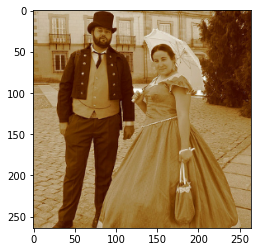

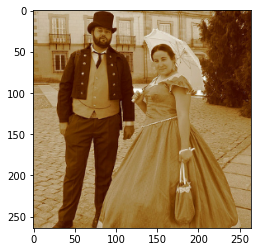

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pg_core import GaussianPolicyAgent

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.sum_axes = False
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'
config.use_dones = False
config.fixed_image_num = 1 #this is a nice image
config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])
actor_lr = 1e-4
dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

dataset = get_dataset(dataset_dir,
                                     'validation',
                                     config.batch_size,
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                    deterministic=True,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

# env = RetinaEnv(config, image_generator=dataset)
env = RetinaEnv(config) #freezing on first batch
for images,_ in dataset:
    break
    
images = images[config.fixed_image_num].numpy()
images = np.repeat(images[np.newaxis, :, :, :], config.batch_size, axis=0)
plt.imshow(images[0])
plt.figure()
plt.imshow(images[1])
if config.gym_mode:
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
else:
    num_states = env.observation_size
    num_actions = env.action_size
    upper_bound = env.action_upper_bound
    lower_bound = env.action_lower_bound


actor_model = create_actor_model(env.image_h, env.image_w,
                                 env.spectral_density_size, env.location_history_size,
                                 env.timestep_size, env.action_size)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
actor_model.optimizer = actor_optimizer
agent = GaussianPolicyAgent(std_deviation=1.0,model=actor_model)

In [ ]:
# Training loop
reward_records = []
epsilon_records = []
action_mean_records = []
action_var_records = []
action_statmean_records = []
action_statvar_records = []
episodes = 10000
for ep in range(episodes):
    prev_state = env.reset(images=images)
    episodic_reward = 0
    states, actions, rewards = [], [], []

#     epsilon = epsilon_scheduler(ep, floor_episode=1000)

    while True:

        deterministic_action, means,stdevs = agent.get_action(env.unflatten_observation(prev_state),
                                               return_stats=True)
        action = deterministic_action #hook in order to add noise if neccessary
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            states.append(prev_state)
            actions.append(action)
            rewards.append(reward)
                
            episodic_reward += reward
           
            action_mean_records.append(deterministic_action.mean(axis=0))
            action_var_records.append(deterministic_action.var(axis=0))
            action_statmean_records.append(means)
            action_statvar_records.append(stdevs)
        # End this episode when `done` is True
        if done:
            break

        prev_state = np.copy(state)
    
    agent.train(np.array(states), np.array(actions), np.array(rewards),shaper_fn=env.unflatten_observation_v2,
                max_iterations=1000, loud=True)
    reward_records.append(episodic_reward)
    print(f"Episode * {ep} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
#     print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    print("action means and variances at step -10:", action_mean_records[-10],action_var_records[-10])
    print("action means and variances at step -5:", action_mean_records[-5],action_var_records[-5])
    print("action statmeans and variances at step -10:", action_statmean_records[-10][0],action_statvar_records[-10][0])
    print("action statmeans and variances at step -5:", action_statmean_records[-5][0],action_statvar_records[-5][0])


Training for 17 iterations with batchsize 64
Episode * 0 * Episodic Reward is ==> -16.284866333007812
action means and variances at step -10: [ 0.56199215 -0.42189582] [0.87803206 1.34452383]
action means and variances at step -5: [-0.1686905  0.0885924] [0.96577104 1.07890222]
action statmeans and variances at step -10: [ 0.04865068 -0.0288178 ] [1. 1.]
action statmeans and variances at step -5: [ 0.03947006 -0.02774443] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1 * Episodic Reward is ==> -16.91128158569336
action means and variances at step -10: [-0.06073341  0.1409871 ] [0.77943156 1.12537369]
action means and variances at step -5: [-0.19039034 -0.03491839] [0.82583865 0.83810859]
action statmeans and variances at step -10: [-0.03342746 -0.05614394] [1. 1.]
action statmeans and variances at step -5: [-0.03260581 -0.05271905] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2 * Episodic Reward is ==> -17.499401092529297
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 12 * Episodic Reward is ==> -16.937461853027344
action means and variances at step -10: [0.15838477 0.4055122 ] [1.00948861 0.86182943]
action means and variances at step -5: [ 0.02623686 -0.16750908] [0.92105609 1.39599032]
action statmeans and variances at step -10: [-0.01436406  0.04097478] [1. 1.]
action statmeans and variances at step -5: [-0.02030438  0.02612312] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 13 * Episodic Reward is ==> -15.982499122619629
action means and variances at step -10: [-0.31008173  0.08957798] [0.59511748 0.5230148 ]
action means and variances at step -5: [0.01535623 0.11271809] [0.99881937 0.67715329]
action statmeans and variances at step -10: [0.0095316  0.07316533] [1. 1.]
action statmeans and variances at step -5: [0.00638778 0.06499048] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 14 * Episodic Reward is ==> -17.0438289642334
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 24 * Episodic Reward is ==> -17.221477508544922
action means and variances at step -10: [0.19414938 0.24256438] [1.34153758 1.32475614]
action means and variances at step -5: [-0.29753502  0.01623321] [0.83677962 0.97915535]
action statmeans and variances at step -10: [-0.06565872  0.00194626] [1. 1.]
action statmeans and variances at step -5: [-0.02615721  0.10773475] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 25 * Episodic Reward is ==> -16.68088150024414
action means and variances at step -10: [ 0.08401393 -0.10196869] [0.60259678 0.95065431]
action means and variances at step -5: [ 0.15529541 -0.0013305 ] [0.65371822 1.10105118]
action statmeans and variances at step -10: [-0.05234464  0.04948333] [1. 1.]
action statmeans and variances at step -5: [-0.05571139  0.05926138] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 26 * Episodic Reward is ==> -17.25878143310547
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 36 * Episodic Reward is ==> -15.948400497436523
action means and variances at step -10: [-0.24877418  0.15999585] [0.98658363 1.35524716]
action means and variances at step -5: [ 0.13241221 -0.05867383] [1.43752098 1.00723921]
action statmeans and variances at step -10: [-0.17050552  0.0976534 ] [1. 1.]
action statmeans and variances at step -5: [-0.1684832   0.10412248] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 37 * Episodic Reward is ==> -15.864338874816895
action means and variances at step -10: [0.00245167 0.045045  ] [0.7196371  0.51775888]
action means and variances at step -5: [-0.56416752  0.07488409] [1.15586889 1.17881571]
action statmeans and variances at step -10: [-0.16855115  0.08163956] [1. 1.]
action statmeans and variances at step -5: [-0.19046174  0.03287058] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 38 * Episodic Reward is ==> -15.971492767333984
action means and variance

Training for 17 iterations with batchsize 64
Episode * 48 * Episodic Reward is ==> -14.294931411743164
action means and variances at step -10: [-0.80251061 -0.02613598] [1.03355257 1.22833921]
action means and variances at step -5: [-0.83296116 -0.06055908] [0.90364437 1.26106519]
action statmeans and variances at step -10: [-0.7574467  0.075936 ] [1. 1.]
action statmeans and variances at step -5: [-0.76772726  0.05828186] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 49 * Episodic Reward is ==> -13.810201644897461
action means and variances at step -10: [-0.76030089 -0.03697182] [0.72725021 0.71948322]
action means and variances at step -5: [-0.72970048  0.38780949] [0.94569966 0.96248392]
action statmeans and variances at step -10: [-0.64058423  0.24150892] [1. 1.]
action statmeans and variances at step -5: [-0.6468291   0.22005165] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 50 * Episodic Reward is ==> -13.59089469909668
action means and variances

Training for 17 iterations with batchsize 64
Episode * 60 * Episodic Reward is ==> -14.040445327758789
action means and variances at step -10: [-0.55275432  0.05313727] [0.81307692 0.69498564]
action means and variances at step -5: [-0.69668807 -0.00386227] [0.91438371 0.98551305]
action statmeans and variances at step -10: [-0.67607665  0.11412895] [1. 1.]
action statmeans and variances at step -5: [-0.7066085   0.04120608] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 61 * Episodic Reward is ==> -13.864126205444336
action means and variances at step -10: [-0.73243125  0.09872513] [0.88945573 1.3711218 ]
action means and variances at step -5: [-0.86339361  0.04848704] [1.12449745 0.78930979]
action statmeans and variances at step -10: [-0.65678847  0.17614059] [1. 1.]
action statmeans and variances at step -5: [-0.6581582  0.1911371] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 62 * Episodic Reward is ==> -13.950296401977539
action means and variance

Training for 17 iterations with batchsize 64
Episode * 72 * Episodic Reward is ==> -12.967058181762695
action means and variances at step -10: [-0.56280297 -0.26444366] [1.1504614  0.89525634]
action means and variances at step -5: [-0.5620657   0.15242796] [0.85174827 1.00492078]
action statmeans and variances at step -10: [-0.61942875 -0.0595498 ] [1. 1.]
action statmeans and variances at step -5: [-0.61236954 -0.03169001] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 73 * Episodic Reward is ==> -13.371356010437012
action means and variances at step -10: [-0.74266043 -0.01134935] [1.2579617  0.56789205]
action means and variances at step -5: [-0.55583339  0.22191997] [0.63367112 0.73551038]
action statmeans and variances at step -10: [-0.6081943   0.09279695] [1. 1.]
action statmeans and variances at step -5: [-0.6269354  0.0368617] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 74 * Episodic Reward is ==> -14.168746948242188
action means and variance

Training for 17 iterations with batchsize 64
Episode * 84 * Episodic Reward is ==> -13.850276947021484
action means and variances at step -10: [-0.52981858 -0.08754177] [1.40678142 0.89152365]
action means and variances at step -5: [-0.71014931 -0.30178903] [0.77838595 1.13221059]
action statmeans and variances at step -10: [-0.59821075  0.01529511] [1. 1.]
action statmeans and variances at step -5: [-0.60141826  0.01513392] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 85 * Episodic Reward is ==> -12.934828758239746
action means and variances at step -10: [-0.66159934  0.07542997] [0.92419586 0.81533921]
action means and variances at step -5: [-0.80042325 -0.0640517 ] [0.81215141 1.73174582]
action statmeans and variances at step -10: [-0.73028076 -0.17713179] [1. 1.]
action statmeans and variances at step -5: [-0.7251886  -0.15238455] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 86 * Episodic Reward is ==> -13.388439178466797
action means and varian

Training for 17 iterations with batchsize 64
Episode * 96 * Episodic Reward is ==> -13.958588600158691
action means and variances at step -10: [-1.02985717 -0.38910702] [1.02456877 0.89589309]
action means and variances at step -5: [-0.7859987  -0.13537224] [0.76260216 0.70606119]
action statmeans and variances at step -10: [-0.7860781  -0.15255478] [1. 1.]
action statmeans and variances at step -5: [-0.783722   -0.13234927] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 97 * Episodic Reward is ==> -13.906233787536621
action means and variances at step -10: [-0.44223416  0.13216149] [0.72363315 0.90912838]
action means and variances at step -5: [-0.53585966 -0.39834851] [0.7253098  0.96449298]
action statmeans and variances at step -10: [-0.676538    0.12424736] [1. 1.]
action statmeans and variances at step -5: [-0.6815093   0.11714251] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 98 * Episodic Reward is ==> -13.430573463439941
action means and varian

Training for 17 iterations with batchsize 64
Episode * 108 * Episodic Reward is ==> -13.190937042236328
action means and variances at step -10: [-0.80566506  0.13212412] [1.2500034  0.74410241]
action means and variances at step -5: [-0.64467971 -0.4065006 ] [1.06426177 1.19425773]
action statmeans and variances at step -10: [-0.6047005 -0.2406761] [1. 1.]
action statmeans and variances at step -5: [-0.5801049 -0.171344 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 109 * Episodic Reward is ==> -12.93256664276123
action means and variances at step -10: [-0.8787565  -0.04864315] [1.0034768  1.46867809]
action means and variances at step -5: [-0.70640973  0.05104882] [1.34963476 0.73234351]
action statmeans and variances at step -10: [-0.57293904 -0.03416671] [1. 1.]
action statmeans and variances at step -5: [-0.50471056  0.1583554 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 110 * Episodic Reward is ==> -13.379179000854492
action means and variance

Training for 17 iterations with batchsize 64
Episode * 120 * Episodic Reward is ==> -13.654860496520996
action means and variances at step -10: [-0.9009554   0.05962072] [1.26332093 1.1130218 ]
action means and variances at step -5: [-0.93071263 -0.21029942] [1.03896757 0.62875322]
action statmeans and variances at step -10: [-0.93644655 -0.39075467] [1. 1.]
action statmeans and variances at step -5: [-0.9101119 -0.3150016] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 121 * Episodic Reward is ==> -13.295991897583008
action means and variances at step -10: [-0.34681301 -0.09970231] [0.74218452 0.70263866]
action means and variances at step -5: [-0.98398431  0.13147422] [0.57836673 0.86734307]
action statmeans and variances at step -10: [-0.8956884  -0.10905825] [1. 1.]
action statmeans and variances at step -5: [-0.89180124 -0.09262815] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 122 * Episodic Reward is ==> -13.251579284667969
action means and varia

Training for 17 iterations with batchsize 64
Episode * 132 * Episodic Reward is ==> -12.607372283935547
action means and variances at step -10: [-0.63088395 -0.22982697] [1.1232848  1.30559166]
action means and variances at step -5: [-0.55519139  0.18059695] [1.26495467 0.69003472]
action statmeans and variances at step -10: [-0.6671454  -0.01988304] [1. 1.]
action statmeans and variances at step -5: [-0.6864139  -0.08918147] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 133 * Episodic Reward is ==> -12.588963508605957
action means and variances at step -10: [-0.83243222 -0.26865862] [1.0884747  0.58841585]
action means and variances at step -5: [-1.02279944  0.06998538] [0.60817135 0.78883596]
action statmeans and variances at step -10: [-0.6675497  0.0117009] [1. 1.]
action statmeans and variances at step -5: [-0.6384962   0.13024977] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 134 * Episodic Reward is ==> -13.793187141418457
action means and varia

Training for 17 iterations with batchsize 64
Episode * 144 * Episodic Reward is ==> -13.021692276000977
action means and variances at step -10: [-1.0355831  -0.20120534] [1.23129691 0.99099904]
action means and variances at step -5: [-0.91089371  0.15268587] [1.29505664 0.99053418]
action statmeans and variances at step -10: [-0.7183648   0.02065362] [1. 1.]
action statmeans and variances at step -5: [-0.7256903  -0.00490578] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 145 * Episodic Reward is ==> -12.971565246582031
action means and variances at step -10: [-0.71708282 -0.20274237] [0.72282494 1.04793987]
action means and variances at step -5: [-0.6612639  -0.40139652] [0.8658119  0.85580639]
action statmeans and variances at step -10: [-0.7783834  -0.10454082] [1. 1.]
action statmeans and variances at step -5: [-0.7885494  -0.10003538] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 146 * Episodic Reward is ==> -12.87981128692627
action means and vari

Training for 17 iterations with batchsize 64
Episode * 156 * Episodic Reward is ==> -12.761080741882324
action means and variances at step -10: [-0.40763641 -0.20717544] [1.02318335 0.81321915]
action means and variances at step -5: [-0.40996663 -0.08692895] [1.23683264 0.79581109]
action statmeans and variances at step -10: [-0.66260266 -0.14029884] [1. 1.]
action statmeans and variances at step -5: [-0.4862851  0.5511011] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 157 * Episodic Reward is ==> -12.377420425415039
action means and variances at step -10: [-0.60413585  0.03452538] [1.40111427 1.23064557]
action means and variances at step -5: [-0.57002015 -0.15056557] [0.72690096 1.39257843]
action statmeans and variances at step -10: [-0.68194    -0.19936126] [1. 1.]
action statmeans and variances at step -5: [-0.6568328  -0.04149119] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 158 * Episodic Reward is ==> -12.928511619567871
action means and varia

Training for 17 iterations with batchsize 64
Episode * 168 * Episodic Reward is ==> -12.442058563232422
action means and variances at step -10: [-0.78538847  0.14001104] [0.97445714 1.08542009]
action means and variances at step -5: [-1.09884679 -0.34019278] [1.13233062 1.043935  ]
action statmeans and variances at step -10: [-0.75021505 -0.11827516] [1. 1.]
action statmeans and variances at step -5: [-0.69353175  0.10372493] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 169 * Episodic Reward is ==> -12.123409271240234
action means and variances at step -10: [-0.31265993 -0.04209161] [0.82146831 0.95473438]
action means and variances at step -5: [-0.62018097  0.21087395] [1.14054462 1.15418486]
action statmeans and variances at step -10: [-0.6394839  -0.00906336] [1. 1.]
action statmeans and variances at step -5: [-0.66313875 -0.05220176] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 170 * Episodic Reward is ==> -12.150230407714844
action means and var

Training for 17 iterations with batchsize 64
Episode * 180 * Episodic Reward is ==> -12.544608116149902
action means and variances at step -10: [-0.53915026  0.12590588] [0.67369993 0.64274762]
action means and variances at step -5: [-0.46303665 -0.11132601] [1.01110442 1.28082265]
action statmeans and variances at step -10: [-0.5710318 -0.200906 ] [1. 1.]
action statmeans and variances at step -5: [-0.5851809 -0.250184 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 181 * Episodic Reward is ==> -11.87727165222168
action means and variances at step -10: [-0.65554837  0.22561195] [1.13341041 1.3642148 ]
action means and variances at step -5: [-0.38134428 -0.09087718] [1.09404562 1.05664583]
action statmeans and variances at step -10: [-0.6405711  -0.13282265] [1. 1.]
action statmeans and variances at step -5: [-0.5577769  0.4411316] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 182 * Episodic Reward is ==> -11.92278003692627
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 192 * Episodic Reward is ==> -12.415000915527344
action means and variances at step -10: [-0.71113891  0.09877675] [0.85464855 0.96168785]
action means and variances at step -5: [-0.59799073  0.18932571] [1.02775634 1.21041249]
action statmeans and variances at step -10: [-0.6683473   0.41672266] [1. 1.]
action statmeans and variances at step -5: [-0.62950826  0.6330043 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 193 * Episodic Reward is ==> -12.13879108428955
action means and variances at step -10: [-0.3812189  0.244243 ] [0.61482367 1.26478483]
action means and variances at step -5: [-0.50993627  0.2219671 ] [0.81879843 1.09941541]
action statmeans and variances at step -10: [-0.787086   -0.34985623] [1. 1.]
action statmeans and variances at step -5: [-0.6610596   0.21629615] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 194 * Episodic Reward is ==> -12.547975540161133
action means and varian

Training for 17 iterations with batchsize 64
Episode * 204 * Episodic Reward is ==> -11.732522010803223
action means and variances at step -10: [-0.64279781  0.12658075] [0.9778411  0.92951552]
action means and variances at step -5: [-0.728596    0.08031323] [1.08687062 1.02357123]
action statmeans and variances at step -10: [-0.73043555 -0.23334566] [1. 1.]
action statmeans and variances at step -5: [-0.69035214 -0.06673359] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 205 * Episodic Reward is ==> -11.9344482421875
action means and variances at step -10: [-1.07504092 -0.14041906] [1.34352135 1.15351285]
action means and variances at step -5: [-0.59181671  0.18924924] [1.05515076 0.91326831]
action statmeans and variances at step -10: [-0.7531351 -0.3660353] [1. 1.]
action statmeans and variances at step -5: [-0.8045949 -0.4754597] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 206 * Episodic Reward is ==> -12.306882858276367
action means and variances

Training for 17 iterations with batchsize 64
Episode * 216 * Episodic Reward is ==> -13.158134460449219
action means and variances at step -10: [-0.62027308  0.65780076] [0.62172811 1.29494833]
action means and variances at step -5: [-0.83853574  0.16064745] [1.58150961 0.77132713]
action statmeans and variances at step -10: [-0.5885123  0.8681176] [1. 1.]
action statmeans and variances at step -5: [-0.76343656  0.13491452] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 217 * Episodic Reward is ==> -13.871854782104492
action means and variances at step -10: [-0.48763149  0.43387036] [0.77133969 0.88643032]
action means and variances at step -5: [-1.01444542  0.65987666] [1.38871967 1.71385158]
action statmeans and variances at step -10: [-0.67916584  0.12028222] [1. 1.]
action statmeans and variances at step -5: [-0.56547487  0.7425993 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 218 * Episodic Reward is ==> -13.931722640991211
action means and varia

Training for 17 iterations with batchsize 64
Episode * 228 * Episodic Reward is ==> -11.971856117248535
action means and variances at step -10: [-0.7721288  -0.11944759] [1.0213798  1.05126139]
action means and variances at step -5: [-0.93917395 -0.16423436] [1.20825106 0.63623991]
action statmeans and variances at step -10: [-0.6959715  0.0154355] [1. 1.]
action statmeans and variances at step -5: [-0.4851575   0.96848905] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 229 * Episodic Reward is ==> -12.150365829467773
action means and variances at step -10: [-0.97216511 -0.12463917] [0.6793755  1.02188336]
action means and variances at step -5: [-0.86301661 -0.21767285] [0.59540033 1.42671227]
action statmeans and variances at step -10: [-0.9180807  -0.88247216] [1. 1.]
action statmeans and variances at step -5: [-0.855279  -0.5118163] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 230 * Episodic Reward is ==> -11.748222351074219
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 240 * Episodic Reward is ==> -11.906793594360352
action means and variances at step -10: [-0.80146087  0.02545509] [1.15122092 1.56551741]
action means and variances at step -5: [-1.14954085  0.07449213] [1.87680085 0.92945516]
action statmeans and variances at step -10: [-0.72361946 -0.12036894] [1. 1.]
action statmeans and variances at step -5: [-0.69391525  0.26007086] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 241 * Episodic Reward is ==> -11.62002182006836
action means and variances at step -10: [-0.73997785  0.01126401] [0.77800556 0.90767402]
action means and variances at step -5: [-0.48361113 -0.04205939] [0.9798642  1.17338281]
action statmeans and variances at step -10: [-0.9192233 -0.9529203] [1. 1.]
action statmeans and variances at step -5: [-0.6724598   0.24632375] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 242 * Episodic Reward is ==> -11.568318367004395
action means and varian

Training for 17 iterations with batchsize 64
Episode * 252 * Episodic Reward is ==> -11.982927322387695
action means and variances at step -10: [-0.84531215 -0.19283326] [0.81794913 1.19543441]
action means and variances at step -5: [-0.89959695  0.18416514] [1.08160131 0.63923332]
action statmeans and variances at step -10: [-0.84699523 -0.29609126] [1. 1.]
action statmeans and variances at step -5: [-0.7915435  -0.09444271] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 253 * Episodic Reward is ==> -11.974130630493164
action means and variances at step -10: [-0.45345446  0.37715431] [1.17069575 1.12527016]
action means and variances at step -5: [-0.46764347  0.19457015] [1.18739011 0.65099034]
action statmeans and variances at step -10: [-0.8062037  -0.13179961] [1. 1.]
action statmeans and variances at step -5: [-0.82031846 -0.38103265] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 254 * Episodic Reward is ==> -11.970254898071289
action means and var

Training for 17 iterations with batchsize 64
Episode * 264 * Episodic Reward is ==> -11.923707008361816
action means and variances at step -10: [-0.57664004  0.01829507] [1.18015856 1.6085828 ]
action means and variances at step -5: [-0.41027284  0.25660275] [0.80733497 1.63509101]
action statmeans and variances at step -10: [-0.4796512   0.24291784] [1. 1.]
action statmeans and variances at step -5: [-0.34381276  0.8067179 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 265 * Episodic Reward is ==> -11.923782348632812
action means and variances at step -10: [-0.44320255  0.09163079] [0.82378845 1.4645416 ]
action means and variances at step -5: [-0.33396343 -0.02449754] [0.80461709 1.3538514 ]
action statmeans and variances at step -10: [-0.57334554  0.3457803 ] [1. 1.]
action statmeans and variances at step -5: [-0.5680149  0.2507827] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 266 * Episodic Reward is ==> -12.545835494995117
action means and varia

Training for 17 iterations with batchsize 64
Episode * 276 * Episodic Reward is ==> -11.86728286743164
action means and variances at step -10: [-0.42519094  0.17050014] [0.7873364  1.12683206]
action means and variances at step -5: [-0.63975877  0.03809562] [1.7877508  1.11921778]
action statmeans and variances at step -10: [-0.6160207   0.21101522] [1. 1.]
action statmeans and variances at step -5: [-0.6081894  0.2716189] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 277 * Episodic Reward is ==> -12.033693313598633
action means and variances at step -10: [-0.68148402  0.25868145] [1.25663986 1.71439236]
action means and variances at step -5: [-0.55396619  0.29310878] [1.28403073 0.91286945]
action statmeans and variances at step -10: [-0.6140655  0.7624231] [1. 1.]
action statmeans and variances at step -5: [-0.7163721   0.24514955] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 278 * Episodic Reward is ==> -11.781635284423828
action means and variance

Training for 17 iterations with batchsize 64
Episode * 288 * Episodic Reward is ==> -11.353580474853516
action means and variances at step -10: [-0.63825531  0.16314792] [1.8973014  1.14567026]
action means and variances at step -5: [-0.65936793 -0.17023032] [1.2697893  1.68085872]
action statmeans and variances at step -10: [-0.5028324   0.55181426] [1. 1.]
action statmeans and variances at step -5: [-0.6748108  -0.01242667] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 289 * Episodic Reward is ==> -11.527385711669922
action means and variances at step -10: [-0.85800041 -0.3261258 ] [0.7912791  1.27005628]
action means and variances at step -5: [-0.73768245 -0.01830823] [0.87174994 0.99305564]
action statmeans and variances at step -10: [-0.66804713 -0.375767  ] [1. 1.]
action statmeans and variances at step -5: [-0.43333828  0.5765853 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 290 * Episodic Reward is ==> -11.625418663024902
action means and var

Training for 17 iterations with batchsize 64
Episode * 300 * Episodic Reward is ==> -11.346881866455078
action means and variances at step -10: [-0.59861134 -0.12171957] [0.97477723 1.85833869]
action means and variances at step -5: [-0.94593956  0.3255555 ] [1.09522103 0.7896276 ]
action statmeans and variances at step -10: [-0.7647494  -0.15703967] [1. 1.]
action statmeans and variances at step -5: [-0.74240077  0.03471785] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 301 * Episodic Reward is ==> -11.182852745056152
action means and variances at step -10: [-0.55055669 -0.11496567] [0.95748058 2.50258961]
action means and variances at step -5: [-1.05074559  0.17754173] [0.99763918 1.03905815]
action statmeans and variances at step -10: [-0.8007523  -0.85222995] [1. 1.]
action statmeans and variances at step -5: [-0.67646015 -0.21220455] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 302 * Episodic Reward is ==> -11.310211181640625
action means and var

Training for 17 iterations with batchsize 64
Episode * 312 * Episodic Reward is ==> -11.122702598571777
action means and variances at step -10: [-0.54131145 -0.12442012] [1.51663974 1.23829767]
action means and variances at step -5: [-0.91321777 -0.05830542] [1.26497041 1.11324969]
action statmeans and variances at step -10: [-0.38059705  1.1970632 ] [1. 1.]
action statmeans and variances at step -5: [-0.6482672  -0.17893934] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 313 * Episodic Reward is ==> -12.025681495666504
action means and variances at step -10: [-0.40216586  0.11362702] [1.06897895 1.39072473]
action means and variances at step -5: [-0.66937137 -0.02768092] [1.40640729 1.93798356]
action statmeans and variances at step -10: [-0.7505852 -0.9751813] [1. 1.]
action statmeans and variances at step -5: [-0.8079194 -1.0318608] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 314 * Episodic Reward is ==> -11.647956848144531
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 324 * Episodic Reward is ==> -11.533207893371582
action means and variances at step -10: [-0.66677502 -0.04986294] [1.16232032 1.77315659]
action means and variances at step -5: [-0.76251978  0.14501087] [1.12594492 1.31033905]
action statmeans and variances at step -10: [-0.5947585   0.50778985] [1. 1.]
action statmeans and variances at step -5: [-0.7138654  -0.15859377] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 325 * Episodic Reward is ==> -11.17261028289795
action means and variances at step -10: [-0.62832934 -0.2201001 ] [0.88346584 2.4487141 ]
action means and variances at step -5: [-0.7253284  -0.13589684] [0.69524391 1.62406541]
action statmeans and variances at step -10: [-0.5110421   0.62737304] [1. 1.]
action statmeans and variances at step -5: [-0.7544222  -0.23688829] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 326 * Episodic Reward is ==> -11.480740547180176
action means and vari

Training for 17 iterations with batchsize 64
Episode * 336 * Episodic Reward is ==> -11.667476654052734
action means and variances at step -10: [-0.68106852 -0.32662812] [0.74160619 0.99132372]
action means and variances at step -5: [-0.43692036 -0.23543836] [0.85120258 1.0216689 ]
action statmeans and variances at step -10: [-0.70719206 -0.31766707] [1. 1.]
action statmeans and variances at step -5: [-0.7835932 -1.0821546] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 337 * Episodic Reward is ==> -11.825642585754395
action means and variances at step -10: [-0.66473274  0.12989636] [0.86054644 1.04104018]
action means and variances at step -5: [-0.59140512 -0.62201666] [1.09144896 1.00829496]
action statmeans and variances at step -10: [-0.6305649   0.25761127] [1. 1.]
action statmeans and variances at step -5: [-0.6975481   0.12020241] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 338 * Episodic Reward is ==> -11.461344718933105
action means and varia

Training for 17 iterations with batchsize 64
Episode * 348 * Episodic Reward is ==> -11.256038665771484
action means and variances at step -10: [-0.3456286  -0.13413775] [0.96303165 1.3030936 ]
action means and variances at step -5: [-0.72366304 -0.08582258] [0.5803977  1.28665753]
action statmeans and variances at step -10: [-0.57620764  0.1521266 ] [1. 1.]
action statmeans and variances at step -5: [-0.6551564   0.18915826] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 349 * Episodic Reward is ==> -11.290266990661621
action means and variances at step -10: [-0.79553599  0.09982393] [1.09324027 1.90819008]
action means and variances at step -5: [-0.83157134 -0.31045507] [0.89649997 1.47562515]
action statmeans and variances at step -10: [-0.60351884 -0.01510936] [1. 1.]
action statmeans and variances at step -5: [-0.74651647 -0.45710698] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 350 * Episodic Reward is ==> -11.132988929748535
action means and var

Training for 17 iterations with batchsize 64
Episode * 360 * Episodic Reward is ==> -13.003679275512695
action means and variances at step -10: [-0.66214286 -0.01263739] [1.24178365 1.24471749]
action means and variances at step -5: [-0.53547605  0.2332545 ] [0.94645311 1.20886854]
action statmeans and variances at step -10: [-0.58559227 -0.02042376] [1. 1.]
action statmeans and variances at step -5: [-0.9090296 -1.1980585] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 361 * Episodic Reward is ==> -11.706828117370605
action means and variances at step -10: [-0.60177879  0.01698409] [0.96133784 2.03440363]
action means and variances at step -5: [-0.49586951 -0.10105104] [1.5114036  1.43590564]
action statmeans and variances at step -10: [-0.56839395  0.61150104] [1. 1.]
action statmeans and variances at step -5: [-0.5595554   0.97401905] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 362 * Episodic Reward is ==> -11.257450103759766
action means and varia

Training for 17 iterations with batchsize 64
Episode * 372 * Episodic Reward is ==> -12.482080459594727
action means and variances at step -10: [-0.78641013  0.35536464] [1.45938843 1.44955166]
action means and variances at step -5: [-0.75516959 -0.13477361] [1.01776768 1.08089963]
action statmeans and variances at step -10: [-0.41389042  0.6004145 ] [1. 1.]
action statmeans and variances at step -5: [-0.66143334 -0.2133898 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 373 * Episodic Reward is ==> -12.233453750610352
action means and variances at step -10: [-0.5508972   0.04087389] [1.10565698 1.76408159]
action means and variances at step -5: [-0.63532047 -0.06216415] [0.82462749 1.78384085]
action statmeans and variances at step -10: [-0.51547307  0.65589356] [1. 1.]
action statmeans and variances at step -5: [-0.29597867  1.3868555 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 374 * Episodic Reward is ==> -13.248309135437012
action means and var

Training for 17 iterations with batchsize 64
Episode * 384 * Episodic Reward is ==> -11.525747299194336
action means and variances at step -10: [-0.51496421  0.4572313 ] [0.87152606 1.84233495]
action means and variances at step -5: [-0.72502492  0.24480965] [0.94473937 1.040052  ]
action statmeans and variances at step -10: [-0.65593636 -0.34340668] [1. 1.]
action statmeans and variances at step -5: [-0.48387453  0.7582843 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 385 * Episodic Reward is ==> -11.48787784576416
action means and variances at step -10: [-0.58525212  0.02728429] [0.68919581 1.72500178]
action means and variances at step -5: [-1.05174496  0.01539383] [0.97558804 1.74538433]
action statmeans and variances at step -10: [-0.51743484  0.08449066] [1. 1.]
action statmeans and variances at step -5: [-0.67781734 -0.3828777 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 386 * Episodic Reward is ==> -11.612601280212402
action means and vari

Training for 17 iterations with batchsize 64
Episode * 396 * Episodic Reward is ==> -11.389034271240234
action means and variances at step -10: [-0.46922856 -0.19556459] [0.68606835 1.26728402]
action means and variances at step -5: [-0.81773157  0.25547386] [0.89049122 1.58036287]
action statmeans and variances at step -10: [-0.70778614  0.8792459 ] [1. 1.]
action statmeans and variances at step -5: [-1.0685825  -0.53118646] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 397 * Episodic Reward is ==> -10.869430541992188
action means and variances at step -10: [-0.67134135 -0.26310978] [0.86590628 1.45477905]
action means and variances at step -5: [-1.11717007  0.14734833] [0.90379476 1.00049102]
action statmeans and variances at step -10: [-0.7567239   0.17930707] [1. 1.]
action statmeans and variances at step -5: [-1.1099744 -1.1961983] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 398 * Episodic Reward is ==> -11.37580394744873
action means and varian

Training for 17 iterations with batchsize 64
Episode * 408 * Episodic Reward is ==> -11.589248657226562
action means and variances at step -10: [-0.63028113  0.24532621] [0.74428925 1.05904809]
action means and variances at step -5: [-0.63057959  0.29303942] [0.9809178  1.83192672]
action statmeans and variances at step -10: [-0.22106066  1.8580678 ] [1. 1.]
action statmeans and variances at step -5: [-0.5981324   0.22987859] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 409 * Episodic Reward is ==> -11.727058410644531
action means and variances at step -10: [-0.67927621  0.33701354] [0.93918849 1.99016834]
action means and variances at step -5: [-0.2004261   0.07514215] [1.13396828 2.08929297]
action statmeans and variances at step -10: [-0.45104086  0.9431076 ] [1. 1.]
action statmeans and variances at step -5: [-0.82890254 -1.0210781 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 410 * Episodic Reward is ==> -11.687522888183594
action means and var

Training for 17 iterations with batchsize 64
Episode * 420 * Episodic Reward is ==> -11.110489845275879
action means and variances at step -10: [-0.39967928  0.08618117] [1.65347845 1.69952   ]
action means and variances at step -5: [-0.77024202  0.17648314] [1.11845345 1.52765577]
action statmeans and variances at step -10: [-0.25296333  1.5872543 ] [1. 1.]
action statmeans and variances at step -5: [-0.46030238  0.81593424] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 421 * Episodic Reward is ==> -11.077491760253906
action means and variances at step -10: [-0.65032448 -0.25338418] [1.30837815 0.88423187]
action means and variances at step -5: [-0.6124336  0.468625 ] [0.96545111 1.25238181]
action statmeans and variances at step -10: [-0.80393124 -0.938148  ] [1. 1.]
action statmeans and variances at step -5: [-0.24178527  1.7764617 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 422 * Episodic Reward is ==> -11.914863586425781
action means and varia

Training for 17 iterations with batchsize 64
Episode * 432 * Episodic Reward is ==> -10.997124671936035
action means and variances at step -10: [-0.82903472 -0.0353942 ] [1.35880856 2.43402979]
action means and variances at step -5: [-0.40342102 -0.17062451] [0.9217155  0.83405978]
action statmeans and variances at step -10: [-0.617805  -0.2538797] [1. 1.]
action statmeans and variances at step -5: [-0.41205657  0.8831606 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 433 * Episodic Reward is ==> -10.96905517578125
action means and variances at step -10: [-0.7824107  -0.07736717] [0.86765308 1.7988191 ]
action means and variances at step -5: [-0.72685211  0.0952052 ] [1.04235143 1.28034642]
action statmeans and variances at step -10: [-0.7833123 -1.4684186] [1. 1.]
action statmeans and variances at step -5: [-0.90786994 -1.5777595 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 434 * Episodic Reward is ==> -10.746536254882812
action means and variance

Training for 17 iterations with batchsize 64
Episode * 444 * Episodic Reward is ==> -11.265493392944336
action means and variances at step -10: [-0.85762485  0.08267276] [1.00033284 1.23271623]
action means and variances at step -5: [-1.13618412  0.154541  ] [0.95568746 0.94005776]
action statmeans and variances at step -10: [-0.52611333  0.29291016] [1. 1.]
action statmeans and variances at step -5: [-0.6454364  0.9760537] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 445 * Episodic Reward is ==> -11.252737045288086
action means and variances at step -10: [-0.65810836 -0.05533085] [1.04037572 1.67300791]
action means and variances at step -5: [-0.5772335  -0.00323219] [0.7032204  1.78405476]
action statmeans and variances at step -10: [-1.0522208 -1.2115299] [1. 1.]
action statmeans and variances at step -5: [-0.5027249  1.2944652] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 446 * Episodic Reward is ==> -11.096311569213867
action means and variances

Training for 17 iterations with batchsize 64
Episode * 456 * Episodic Reward is ==> -11.255911827087402
action means and variances at step -10: [-0.70514022  0.25461375] [1.06555218 1.54524866]
action means and variances at step -5: [-0.58135612 -0.14310226] [1.23413654 1.87417741]
action statmeans and variances at step -10: [-0.93013835 -0.99925214] [1. 1.]
action statmeans and variances at step -5: [-0.97314966 -0.16526249] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 457 * Episodic Reward is ==> -10.936182975769043
action means and variances at step -10: [-0.9311258  -0.09400386] [0.99218675 1.86677502]
action means and variances at step -5: [-0.50545957 -0.02488807] [0.7014947  1.62706956]
action statmeans and variances at step -10: [-0.62773335  0.21733639] [1. 1.]
action statmeans and variances at step -5: [-0.39528388  0.4413869 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 458 * Episodic Reward is ==> -10.947013854980469
action means and var

Training for 17 iterations with batchsize 64
Episode * 468 * Episodic Reward is ==> -10.726115226745605
action means and variances at step -10: [-0.7734056   0.59122216] [1.03530781 2.54369031]
action means and variances at step -5: [-0.42110775  0.41376018] [1.27092975 1.55784171]
action statmeans and variances at step -10: [-0.2242871  1.0072594] [1. 1.]
action statmeans and variances at step -5: [-0.91606975 -1.3221934 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 469 * Episodic Reward is ==> -10.95217514038086
action means and variances at step -10: [-0.58120992  0.33545872] [1.04351062 1.36608519]
action means and variances at step -5: [-0.58952446  0.35191473] [0.54369509 1.79133801]
action statmeans and variances at step -10: [-0.716119   -0.08996589] [1. 1.]
action statmeans and variances at step -5: [-0.84736794 -0.08251689] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 470 * Episodic Reward is ==> -10.676342010498047
action means and varian

Training for 17 iterations with batchsize 64
Episode * 480 * Episodic Reward is ==> -11.064167976379395
action means and variances at step -10: [-0.20437231  0.25009119] [1.19552447 1.68149624]
action means and variances at step -5: [-0.85828932 -0.12922307] [0.98166638 2.19820109]
action statmeans and variances at step -10: [-0.6311122   0.55773723] [1. 1.]
action statmeans and variances at step -5: [-0.8738011  -0.40548193] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 481 * Episodic Reward is ==> -11.005655288696289
action means and variances at step -10: [-0.64750846  0.68179497] [1.28259519 2.34867482]
action means and variances at step -5: [-1.07173145  0.15754001] [1.1027627  1.65562508]
action statmeans and variances at step -10: [-0.11613618  1.6191577 ] [1. 1.]
action statmeans and variances at step -5: [-0.202564   1.2867589] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 482 * Episodic Reward is ==> -11.11799144744873
action means and varian

Training for 17 iterations with batchsize 64
Episode * 492 * Episodic Reward is ==> -10.872556686401367
action means and variances at step -10: [-0.78836794  0.09274738] [0.6972362  2.55277465]
action means and variances at step -5: [-0.88045188 -0.21350375] [1.14045629 1.53592817]
action statmeans and variances at step -10: [-0.9321362 -1.4176447] [1. 1.]
action statmeans and variances at step -5: [-0.262876   1.1411556] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 493 * Episodic Reward is ==> -10.94587230682373
action means and variances at step -10: [-0.60966834  0.24842377] [0.85336296 1.79790245]
action means and variances at step -5: [-0.66805538  0.1504831 ] [1.11427805 1.52406633]
action statmeans and variances at step -10: [-1.2066729 -1.4399546] [1. 1.]
action statmeans and variances at step -5: [-0.8986561 -1.4091485] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 494 * Episodic Reward is ==> -10.874323844909668
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 504 * Episodic Reward is ==> -11.520702362060547
action means and variances at step -10: [-0.94554486 -0.40441246] [1.13051374 1.81791234]
action means and variances at step -5: [-0.72389489 -0.25782377] [0.74251792 1.490213  ]
action statmeans and variances at step -10: [-0.6535073  -0.10629755] [1. 1.]
action statmeans and variances at step -5: [-0.72639066 -0.01170904] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 505 * Episodic Reward is ==> -11.571844100952148
action means and variances at step -10: [-0.85746569  0.18374416] [0.77604485 1.44881412]
action means and variances at step -5: [-0.72722541  0.17553302] [0.56218864 1.54207929]
action statmeans and variances at step -10: [-0.8878611  -0.05121647] [1. 1.]
action statmeans and variances at step -5: [-0.8087373   0.21020861] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 506 * Episodic Reward is ==> -11.27925968170166
action means and vari

Training for 17 iterations with batchsize 64
Episode * 516 * Episodic Reward is ==> -11.605953216552734
action means and variances at step -10: [-0.58204202 -0.1341432 ] [1.16090694 1.34413925]
action means and variances at step -5: [-1.01866297  0.08741978] [0.79123438 1.47133058]
action statmeans and variances at step -10: [-1.0449331 -0.6039696] [1. 1.]
action statmeans and variances at step -5: [-0.8973489   0.05882244] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 517 * Episodic Reward is ==> -11.384883880615234
action means and variances at step -10: [-0.42612462 -0.21197623] [1.49181244 2.34147598]
action means and variances at step -5: [-0.89838794 -0.17934468] [0.89945368 1.91252508]
action statmeans and variances at step -10: [-0.36848402  1.3259099 ] [1. 1.]
action statmeans and variances at step -5: [-0.23881546  1.4154876 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 518 * Episodic Reward is ==> -11.326824188232422
action means and varia

Training for 17 iterations with batchsize 64
Episode * 528 * Episodic Reward is ==> -17.199901580810547
action means and variances at step -10: [-1.64071719 -1.49318243] [1.24289656 1.19820744]
action means and variances at step -5: [-1.80858228 -1.70628411] [0.86604481 1.30569199]
action statmeans and variances at step -10: [-1.7109566 -1.8126426] [1. 1.]
action statmeans and variances at step -5: [-1.8250647 -2.1528516] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 529 * Episodic Reward is ==> -11.47310733795166
action means and variances at step -10: [-0.4429038   0.20131422] [1.26812288 2.45695742]
action means and variances at step -5: [-0.43245605  0.36488345] [0.79118138 1.02989675]
action statmeans and variances at step -10: [-0.35376674  0.04777582] [1. 1.]
action statmeans and variances at step -5: [-0.31460536 -0.18492483] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 530 * Episodic Reward is ==> -11.062803268432617
action means and variance

Training for 17 iterations with batchsize 64
Episode * 540 * Episodic Reward is ==> -11.099634170532227
action means and variances at step -10: [-0.82978516 -0.21418622] [1.33756376 2.12394632]
action means and variances at step -5: [-0.76800913 -0.2596274 ] [1.27090419 2.50287967]
action statmeans and variances at step -10: [-0.3537062  1.4408516] [1. 1.]
action statmeans and variances at step -5: [-0.9817593 -1.1660365] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 541 * Episodic Reward is ==> -11.205835342407227
action means and variances at step -10: [-0.63320839  0.12323943] [0.96243106 1.74303553]
action means and variances at step -5: [-0.69983856 -0.29312223] [0.87995381 2.05200647]
action statmeans and variances at step -10: [-0.37795812  1.8909869 ] [1. 1.]
action statmeans and variances at step -5: [-0.6734692  -0.42395025] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 542 * Episodic Reward is ==> -11.334246635437012
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 552 * Episodic Reward is ==> -11.67944622039795
action means and variances at step -10: [-0.66105324 -0.27155686] [1.35596144 2.02486862]
action means and variances at step -5: [-0.8181501  -0.14891508] [0.77567102 2.13731933]
action statmeans and variances at step -10: [-0.92230535 -1.0325977 ] [1. 1.]
action statmeans and variances at step -5: [-0.4326862   0.08765543] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 553 * Episodic Reward is ==> -11.223458290100098
action means and variances at step -10: [-0.70140927  0.22529631] [1.47336551 1.98878171]
action means and variances at step -5: [-0.82240571 -0.4564257 ] [0.85636933 1.60175847]
action statmeans and variances at step -10: [-0.6986044  -0.80432135] [1. 1.]
action statmeans and variances at step -5: [-0.9718131 -1.6456811] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 554 * Episodic Reward is ==> -11.337074279785156
action means and varian

Training for 17 iterations with batchsize 64
Episode * 564 * Episodic Reward is ==> -10.937643051147461
action means and variances at step -10: [-0.51098957  0.02780437] [1.36334027 2.53080357]
action means and variances at step -5: [-0.684606    0.24655763] [1.03145611 1.89724778]
action statmeans and variances at step -10: [-0.48926586  0.5540063 ] [1. 1.]
action statmeans and variances at step -5: [-0.4225372  -0.14572133] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 565 * Episodic Reward is ==> -11.013910293579102
action means and variances at step -10: [-0.72099834 -0.18568166] [0.82317029 1.18099935]
action means and variances at step -5: [-0.63460841  0.17900387] [1.29635887 1.74555605]
action statmeans and variances at step -10: [-0.7908952 -1.3261011] [1. 1.]
action statmeans and variances at step -5: [-0.41030788  1.0665259 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 566 * Episodic Reward is ==> -11.434003829956055
action means and varia

Training for 17 iterations with batchsize 64
Episode * 576 * Episodic Reward is ==> -11.910868644714355
action means and variances at step -10: [-0.63698088 -0.52544639] [1.16261528 1.37923498]
action means and variances at step -5: [-0.39691288  0.04139533] [1.43279584 2.43858111]
action statmeans and variances at step -10: [-0.60273886  1.1120889 ] [1. 1.]
action statmeans and variances at step -5: [-0.9453906 -1.300908 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 577 * Episodic Reward is ==> -11.598165512084961
action means and variances at step -10: [-0.5734153  -0.15363493] [1.06276435 2.07885955]
action means and variances at step -5: [-0.64394711 -0.22447506] [0.99332861 1.67725096]
action statmeans and variances at step -10: [-0.45003957  1.0670408 ] [1. 1.]
action statmeans and variances at step -5: [-0.7187625  -0.27818924] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 578 * Episodic Reward is ==> -11.2747802734375
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 588 * Episodic Reward is ==> -11.007451057434082
action means and variances at step -10: [-0.62399945 -0.19647375] [1.02102722 2.37148943]
action means and variances at step -5: [-0.58762268  0.25174591] [0.77973708 1.49374215]
action statmeans and variances at step -10: [-0.40539283  0.8790417 ] [1. 1.]
action statmeans and variances at step -5: [-0.98230815 -0.3700085 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 589 * Episodic Reward is ==> -11.456216812133789
action means and variances at step -10: [-0.51136239 -0.30443611] [1.13426835 2.65512031]
action means and variances at step -5: [-1.00686463 -0.05925612] [0.76624918 1.52314198]
action statmeans and variances at step -10: [-0.58319396  0.8510939 ] [1. 1.]
action statmeans and variances at step -5: [-0.9668001  -0.13557875] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 590 * Episodic Reward is ==> -11.275317192077637
action means and var

Training for 17 iterations with batchsize 64
Episode * 600 * Episodic Reward is ==> -11.141948699951172
action means and variances at step -10: [-0.65504267 -0.31220034] [0.99984804 1.5349207 ]
action means and variances at step -5: [-0.6483061  -0.57357134] [0.90773193 2.51841614]
action statmeans and variances at step -10: [-0.4531927  0.4855485] [1. 1.]
action statmeans and variances at step -5: [-0.90040064 -0.2640029 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 601 * Episodic Reward is ==> -11.534989356994629
action means and variances at step -10: [-0.52679376 -0.25582149] [1.04266606 1.98340828]
action means and variances at step -5: [-0.66374261  0.01613258] [1.55353158 1.5055863 ]
action statmeans and variances at step -10: [-1.0780246 -1.8935684] [1. 1.]
action statmeans and variances at step -5: [-0.60716295 -0.9894322 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 602 * Episodic Reward is ==> -11.609471321105957
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 612 * Episodic Reward is ==> -11.131837844848633
action means and variances at step -10: [-0.37794352  0.2980808 ] [1.33194238 1.88670192]
action means and variances at step -5: [-0.51307068 -0.56946372] [1.31857769 1.63240339]
action statmeans and variances at step -10: [-0.07803434  0.82647324] [1. 1.]
action statmeans and variances at step -5: [-0.34457338 -0.1239842 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 613 * Episodic Reward is ==> -11.438905715942383
action means and variances at step -10: [-0.50917536 -0.42161223] [1.06102098 1.17395371]
action means and variances at step -5: [-0.68397175  0.23127735] [1.20876255 2.11457025]
action statmeans and variances at step -10: [-1.1493285 -1.6392213] [1. 1.]
action statmeans and variances at step -5: [-1.1369084 -1.77917  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 614 * Episodic Reward is ==> -11.297722816467285
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 624 * Episodic Reward is ==> -11.589393615722656
action means and variances at step -10: [-0.39684125 -0.45362572] [0.59840211 2.13997745]
action means and variances at step -5: [-0.56173819 -0.01435989] [0.91230716 2.30314885]
action statmeans and variances at step -10: [-1.1706593 -1.8996918] [1. 1.]
action statmeans and variances at step -5: [-0.77433133 -1.5598311 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 625 * Episodic Reward is ==> -10.928961753845215
action means and variances at step -10: [-0.45516172  0.2029511 ] [1.22232127 3.3344704 ]
action means and variances at step -5: [-0.61595417  0.36190016] [1.5274238  2.61403871]
action statmeans and variances at step -10: [-1.0964286 -1.0011551] [1. 1.]
action statmeans and variances at step -5: [-0.8257445   0.72997063] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 626 * Episodic Reward is ==> -11.054746627807617
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 636 * Episodic Reward is ==> -11.331914901733398
action means and variances at step -10: [-0.68970896 -0.1629037 ] [0.99497973 2.95842557]
action means and variances at step -5: [-0.74268699  0.09488309] [1.33077552 2.47851694]
action statmeans and variances at step -10: [-1.1819212 -1.2566999] [1. 1.]
action statmeans and variances at step -5: [-0.36976674  0.9712939 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 637 * Episodic Reward is ==> -11.57191276550293
action means and variances at step -10: [-0.65864502  0.48615487] [1.01672544 1.85363338]
action means and variances at step -5: [-0.59055304 -0.02494141] [1.07295728 2.60862625]
action statmeans and variances at step -10: [-0.34175128  1.109189  ] [1. 1.]
action statmeans and variances at step -5: [-0.6735722 -0.5041003] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 638 * Episodic Reward is ==> -11.065937995910645
action means and variance

Training for 17 iterations with batchsize 64
Episode * 648 * Episodic Reward is ==> -11.015992164611816
action means and variances at step -10: [-0.51342017 -0.59749102] [0.97125634 2.62712348]
action means and variances at step -5: [-0.2800487  -0.51937465] [0.63807183 2.17451112]
action statmeans and variances at step -10: [-0.64879566  0.7460903 ] [1. 1.]
action statmeans and variances at step -5: [-0.8264159 -1.0844898] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 649 * Episodic Reward is ==> -10.984487533569336
action means and variances at step -10: [-0.6320007   0.05899063] [0.95929836 1.84160269]
action means and variances at step -5: [-0.60174739  0.13352564] [1.09021761 1.61521824]
action statmeans and variances at step -10: [-1.7175424 -2.06582  ] [1. 1.]
action statmeans and variances at step -5: [-0.6031903  0.8413423] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 650 * Episodic Reward is ==> -11.218409538269043
action means and variances

Training for 17 iterations with batchsize 64
Episode * 660 * Episodic Reward is ==> -11.323721885681152
action means and variances at step -10: [-0.38217919  0.15073432] [1.23916197 2.33610384]
action means and variances at step -5: [-0.77566202 -0.26334221] [1.26944907 1.97841799]
action statmeans and variances at step -10: [-0.8481319 -1.1909255] [1. 1.]
action statmeans and variances at step -5: [-0.9711317 -1.5092177] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 661 * Episodic Reward is ==> -11.663824081420898
action means and variances at step -10: [-0.87803888 -0.02808934] [1.27699134 2.52108367]
action means and variances at step -5: [-0.58120886  0.35032551] [0.43391736 1.69544295]
action statmeans and variances at step -10: [-0.41729265  1.4934716 ] [1. 1.]
action statmeans and variances at step -5: [-1.4105062 -1.7181306] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 662 * Episodic Reward is ==> -11.796700477600098
action means and variances

Training for 17 iterations with batchsize 64
Episode * 672 * Episodic Reward is ==> -11.758304595947266
action means and variances at step -10: [-0.58654721  0.20008755] [0.48441666 1.7188699 ]
action means and variances at step -5: [-0.79248605  0.43988099] [1.87041812 2.08409038]
action statmeans and variances at step -10: [-0.2270122  1.1826595] [1. 1.]
action statmeans and variances at step -5: [-0.48356128  1.7043207 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 673 * Episodic Reward is ==> -11.023460388183594
action means and variances at step -10: [-0.69850615 -0.1387543 ] [0.94762442 2.10065224]
action means and variances at step -5: [-0.91361219 -0.55704589] [1.37629024 2.33209827]
action statmeans and variances at step -10: [-0.62308705  1.1249094 ] [1. 1.]
action statmeans and variances at step -5: [-0.91324914 -0.03664961] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 674 * Episodic Reward is ==> -11.707246780395508
action means and varia

Training for 17 iterations with batchsize 64
Episode * 684 * Episodic Reward is ==> -11.5137939453125
action means and variances at step -10: [-0.60301007  0.02536742] [0.64761452 1.74278917]
action means and variances at step -5: [-0.28918123 -0.02754309] [0.78458811 1.79317234]
action statmeans and variances at step -10: [-0.13271387  0.7014822 ] [1. 1.]
action statmeans and variances at step -5: [-0.5813288   0.61628807] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 685 * Episodic Reward is ==> -11.29110050201416
action means and variances at step -10: [-0.50365246 -0.25506914] [1.42994898 1.69859363]
action means and variances at step -5: [-0.44672357  0.26263482] [0.89262075 2.90285463]
action statmeans and variances at step -10: [-0.36497933  1.6724292 ] [1. 1.]
action statmeans and variances at step -5: [-0.6661916 -0.2720338] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 686 * Episodic Reward is ==> -11.50935173034668
action means and variances

Training for 17 iterations with batchsize 64
Episode * 696 * Episodic Reward is ==> -11.227590560913086
action means and variances at step -10: [-0.33172969 -0.34419308] [1.09104491 2.56757857]
action means and variances at step -5: [-0.52888356 -0.32070231] [0.66035805 1.280353  ]
action statmeans and variances at step -10: [-0.4239779   0.17246932] [1. 1.]
action statmeans and variances at step -5: [-1.0255194 -1.372456 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 697 * Episodic Reward is ==> -11.61051082611084
action means and variances at step -10: [-0.47891059 -0.24054588] [1.06143628 2.16320035]
action means and variances at step -5: [-0.44388617  0.2033764 ] [1.0744081  2.30936965]
action statmeans and variances at step -10: [-0.99649304 -1.644261  ] [1. 1.]
action statmeans and variances at step -5: [-0.80001223 -0.6043381 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 698 * Episodic Reward is ==> -11.8444185256958
action means and variance

Training for 17 iterations with batchsize 64
Episode * 708 * Episodic Reward is ==> -11.309086799621582
action means and variances at step -10: [-0.79774894 -0.52691689] [1.4749162  2.38965318]
action means and variances at step -5: [-0.36464943 -0.19940884] [1.37760902 2.27377061]
action statmeans and variances at step -10: [-0.5412725   0.78751516] [1. 1.]
action statmeans and variances at step -5: [-0.45663708  0.75319844] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 709 * Episodic Reward is ==> -10.816226959228516
action means and variances at step -10: [-0.7185056  -0.09495015] [0.8495719  1.36600668]
action means and variances at step -5: [-0.33312281 -0.26342732] [1.52314708 2.51041643]
action statmeans and variances at step -10: [-0.87307036  0.30511004] [1. 1.]
action statmeans and variances at step -5: [-1.3622121 -1.7020115] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 710 * Episodic Reward is ==> -11.126319885253906
action means and varia

Training for 17 iterations with batchsize 64
Episode * 720 * Episodic Reward is ==> -11.715165138244629
action means and variances at step -10: [-0.33906637 -0.09222524] [0.96940027 3.57754972]
action means and variances at step -5: [-0.53280753  0.23206829] [1.2239926  2.50160492]
action statmeans and variances at step -10: [-0.6951171 -1.2456414] [1. 1.]
action statmeans and variances at step -5: [-0.2963992  1.3951013] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 721 * Episodic Reward is ==> -11.519638061523438
action means and variances at step -10: [-0.58223852 -0.22417152] [0.80242136 2.75619576]
action means and variances at step -5: [-0.52541455 -0.15839032] [1.40676322 2.22810733]
action statmeans and variances at step -10: [-0.48418584 -0.8028058 ] [1. 1.]
action statmeans and variances at step -5: [-0.72411895 -0.14764245] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 722 * Episodic Reward is ==> -11.46028995513916
action means and variance

Training for 17 iterations with batchsize 64
Episode * 732 * Episodic Reward is ==> -11.375025749206543
action means and variances at step -10: [-0.36855433  0.02043238] [1.16138623 2.44806988]
action means and variances at step -5: [-0.47149093 -0.31063437] [1.07214427 2.3666766 ]
action statmeans and variances at step -10: [-0.27628833  1.563081  ] [1. 1.]
action statmeans and variances at step -5: [-0.80123603 -1.209543  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 733 * Episodic Reward is ==> -10.765361785888672
action means and variances at step -10: [-0.78135953 -0.1204704 ] [1.04437324 2.39826001]
action means and variances at step -5: [-0.92129884  0.55228165] [0.82924167 1.76370334]
action statmeans and variances at step -10: [-0.85863215 -0.7380379 ] [1. 1.]
action statmeans and variances at step -5: [-1.0049254   0.11981744] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 734 * Episodic Reward is ==> -11.576045989990234
action means and var

Training for 17 iterations with batchsize 64
Episode * 744 * Episodic Reward is ==> -11.536844253540039
action means and variances at step -10: [-0.57310291 -0.29433037] [0.90282381 1.57048438]
action means and variances at step -5: [-0.83579449 -0.44260102] [0.82568827 1.40681469]
action statmeans and variances at step -10: [-1.0961325 -1.4343808] [1. 1.]
action statmeans and variances at step -5: [-0.73776567  0.12699465] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 745 * Episodic Reward is ==> -11.715127944946289
action means and variances at step -10: [-0.45276205 -0.1062334 ] [1.04685532 1.63116524]
action means and variances at step -5: [-0.47313375  0.54771242] [1.04076309 2.61501372]
action statmeans and variances at step -10: [-1.0617796 -1.7665339] [1. 1.]
action statmeans and variances at step -5: [-0.4274503 -0.5533212] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 746 * Episodic Reward is ==> -11.130010604858398
action means and variances

Training for 17 iterations with batchsize 64
Episode * 756 * Episodic Reward is ==> -11.420551300048828
action means and variances at step -10: [-0.31190734 -0.05293268] [0.77830773 1.92004166]
action means and variances at step -5: [-0.80570052 -0.19951704] [0.79119105 1.53257903]
action statmeans and variances at step -10: [-0.80414486  0.26860684] [1. 1.]
action statmeans and variances at step -5: [-1.059367 -1.684115] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 757 * Episodic Reward is ==> -11.330681800842285
action means and variances at step -10: [-0.91766506  0.09033635] [0.60261789 2.54008129]
action means and variances at step -5: [-0.56862631  0.13217161] [0.704656  2.3165874]
action statmeans and variances at step -10: [-0.6486943 -0.8586569] [1. 1.]
action statmeans and variances at step -5: [-0.736145    0.53968006] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 758 * Episodic Reward is ==> -11.299906730651855
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 768 * Episodic Reward is ==> -11.014492988586426
action means and variances at step -10: [-0.85558409 -0.41146368] [1.12835351 3.03258506]
action means and variances at step -5: [-0.64848604  0.70667825] [0.93778385 1.78268295]
action statmeans and variances at step -10: [-1.0406144 -1.0274835] [1. 1.]
action statmeans and variances at step -5: [-0.60323024  2.2688067 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 769 * Episodic Reward is ==> -11.029593467712402
action means and variances at step -10: [-0.71173336 -0.26700878] [1.27551189 2.21124099]
action means and variances at step -5: [-0.73833098 -0.10727285] [1.15856841 1.81172244]
action statmeans and variances at step -10: [-0.74809265 -1.1421161 ] [1. 1.]
action statmeans and variances at step -5: [-1.2280252 -1.7028389] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 770 * Episodic Reward is ==> -11.195058822631836
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 780 * Episodic Reward is ==> -11.80698013305664
action means and variances at step -10: [-0.47436958 -0.27929029] [1.31428822 3.70825968]
action means and variances at step -5: [-0.27576555  0.3346353 ] [1.24217079 2.78332318]
action statmeans and variances at step -10: [-0.82122374  0.582193  ] [1. 1.]
action statmeans and variances at step -5: [-0.2342699   0.04139236] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 781 * Episodic Reward is ==> -11.242609024047852
action means and variances at step -10: [-0.54977321 -0.23417997] [1.41852756 2.87792625]
action means and variances at step -5: [-0.65377151  0.06367319] [1.20737224 2.6069427 ]
action statmeans and variances at step -10: [-0.86632794 -1.1062099 ] [1. 1.]
action statmeans and variances at step -5: [-0.80956984 -1.2189888 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 782 * Episodic Reward is ==> -11.118711471557617
action means and vari

Training for 17 iterations with batchsize 64
Episode * 792 * Episodic Reward is ==> -11.561226844787598
action means and variances at step -10: [-0.73348855  0.66394494] [1.09709042 2.26243745]
action means and variances at step -5: [-1.01388646 -0.04080997] [1.04388499 2.11604032]
action statmeans and variances at step -10: [-0.46885765  2.1916077 ] [1. 1.]
action statmeans and variances at step -5: [-1.0562489 -1.8278649] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 793 * Episodic Reward is ==> -11.098909378051758
action means and variances at step -10: [-0.76931977  0.41334122] [1.19369531 1.77436876]
action means and variances at step -5: [-0.36333536  0.06168981] [0.92587802 2.15469652]
action statmeans and variances at step -10: [-0.37708145  0.76643836] [1. 1.]
action statmeans and variances at step -5: [-0.9821958 -1.502518 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 794 * Episodic Reward is ==> -11.863845825195312
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 804 * Episodic Reward is ==> -11.13442611694336
action means and variances at step -10: [-0.33164175  0.31853983] [1.25533175 2.23620669]
action means and variances at step -5: [-0.49999875  0.53315535] [1.10694937 2.3961044 ]
action statmeans and variances at step -10: [-0.4085058  2.04006  ] [1. 1.]
action statmeans and variances at step -5: [-0.29431784  1.7121992 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 805 * Episodic Reward is ==> -11.106307029724121
action means and variances at step -10: [-0.7086874   0.31007287] [2.08476242 3.36154325]
action means and variances at step -5: [-0.46405994 -0.09042421] [0.78044607 2.76020718]
action statmeans and variances at step -10: [-0.10824164 -0.17021605] [1. 1.]
action statmeans and variances at step -5: [-0.43410224 -0.64143556] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 806 * Episodic Reward is ==> -11.719757080078125
action means and varian

Training for 17 iterations with batchsize 64
Episode * 816 * Episodic Reward is ==> -11.034614562988281
action means and variances at step -10: [-0.42885978  0.17375347] [1.54337493 3.67257835]
action means and variances at step -5: [-0.82095633  0.35357151] [0.86464139 2.39198534]
action statmeans and variances at step -10: [-0.918517   1.3550271] [1. 1.]
action statmeans and variances at step -5: [-1.4150243 -1.8434454] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 817 * Episodic Reward is ==> -11.54892635345459
action means and variances at step -10: [-0.60563318  0.32967206] [1.48679924 3.11973643]
action means and variances at step -5: [-0.79795907  0.14256983] [1.18180793 2.51852746]
action statmeans and variances at step -10: [-0.44334835  0.8470231 ] [1. 1.]
action statmeans and variances at step -5: [-0.5416133  -0.47079575] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 818 * Episodic Reward is ==> -11.80767822265625
action means and variances

Training for 17 iterations with batchsize 64
Episode * 828 * Episodic Reward is ==> -11.652234077453613
action means and variances at step -10: [-0.56863956 -0.34868609] [0.79462341 2.59024288]
action means and variances at step -5: [-0.92551649  0.19313008] [1.02561604 1.54337882]
action statmeans and variances at step -10: [-0.6904945  1.3813989] [1. 1.]
action statmeans and variances at step -5: [-0.7190714  1.0462573] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 829 * Episodic Reward is ==> -12.170377731323242
action means and variances at step -10: [-0.68077549  0.11338548] [1.01634844 3.8023926 ]
action means and variances at step -5: [-0.52321908  0.16856177] [1.49754786 2.38513258]
action statmeans and variances at step -10: [-0.7547781  -0.89289045] [1. 1.]
action statmeans and variances at step -5: [-0.47494188  1.0599456 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 830 * Episodic Reward is ==> -12.091262817382812
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 840 * Episodic Reward is ==> -11.508451461791992
action means and variances at step -10: [-1.00613353  0.16624542] [1.45126452 4.00920887]
action means and variances at step -5: [-0.84720705  0.28607072] [1.16979841 3.36931892]
action statmeans and variances at step -10: [-0.80241627  0.873135  ] [1. 1.]
action statmeans and variances at step -5: [-0.64512634  1.6753294 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 841 * Episodic Reward is ==> -11.412846565246582
action means and variances at step -10: [-0.92569018 -0.20033552] [1.0903022  2.75223212]
action means and variances at step -5: [-0.56983057  0.27617246] [0.90529451 2.89327393]
action statmeans and variances at step -10: [-0.716857   0.9793584] [1. 1.]
action statmeans and variances at step -5: [-0.18941729  0.5913264 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 842 * Episodic Reward is ==> -10.735754013061523
action means and varia

Training for 17 iterations with batchsize 64
Episode * 852 * Episodic Reward is ==> -11.770156860351562
action means and variances at step -10: [-0.70512501 -0.22232798] [1.40608939 2.21689033]
action means and variances at step -5: [-0.42145518  0.91847754] [1.37615597 1.82142338]
action statmeans and variances at step -10: [-0.730894   0.7036633] [1. 1.]
action statmeans and variances at step -5: [-0.591254   0.8732414] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 853 * Episodic Reward is ==> -10.976845741271973
action means and variances at step -10: [-0.57241009  0.11019404] [1.40175949 2.43471018]
action means and variances at step -5: [-0.65897849  0.26163582] [1.32591545 3.07173332]
action statmeans and variances at step -10: [-1.0530627 -1.637288 ] [1. 1.]
action statmeans and variances at step -5: [-1.1123451 -1.0990407] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 854 * Episodic Reward is ==> -11.369979858398438
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 864 * Episodic Reward is ==> -12.687823295593262
action means and variances at step -10: [-0.87620862 -0.16191081] [1.3923823  1.25709503]
action means and variances at step -5: [-1.2267137  -0.32428909] [1.29396859 2.06407479]
action statmeans and variances at step -10: [-0.9687339 -1.2983917] [1. 1.]
action statmeans and variances at step -5: [-0.9360131  -0.11293279] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 865 * Episodic Reward is ==> -13.685766220092773
action means and variances at step -10: [-1.25546904 -0.38125205] [1.43974942 1.43431386]
action means and variances at step -5: [-1.18799596 -0.14608217] [1.01063372 0.91147547]
action statmeans and variances at step -10: [-0.5060989   0.01948956] [1. 1.]
action statmeans and variances at step -5: [-1.0643511 -1.5288212] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 866 * Episodic Reward is ==> -15.762500762939453
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 876 * Episodic Reward is ==> -19.487567901611328
action means and variances at step -10: [-2.35221566 -2.72214898] [0.93036877 1.27204466]
action means and variances at step -5: [-2.62752876 -2.82001879] [0.81363274 0.87257949]
action statmeans and variances at step -10: [-2.2584622 -2.660286 ] [1. 1.]
action statmeans and variances at step -5: [-2.372864 -2.765862] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 877 * Episodic Reward is ==> -19.682435989379883
action means and variances at step -10: [-2.34409981 -2.49846246] [1.65342731 1.05043523]
action means and variances at step -5: [-2.09706069 -2.83749049] [1.14093067 1.09925572]
action statmeans and variances at step -10: [-2.3563213 -2.708202 ] [1. 1.]
action statmeans and variances at step -5: [-2.4486573 -2.802536 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 878 * Episodic Reward is ==> -19.364259719848633
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 888 * Episodic Reward is ==> -11.852006912231445
action means and variances at step -10: [-0.11199713 -0.14258865] [0.88453302 1.85303999]
action means and variances at step -5: [-0.58130453  0.01276457] [1.0003698  2.58388807]
action statmeans and variances at step -10: [-0.13878682  0.5020232 ] [1. 1.]
action statmeans and variances at step -5: [-0.8208569 -1.027122 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 889 * Episodic Reward is ==> -12.264750480651855
action means and variances at step -10: [-0.38873544  0.16690743] [0.96520303 1.99329599]
action means and variances at step -5: [-0.50967247 -0.24007474] [0.97221792 1.41588368]
action statmeans and variances at step -10: [-0.20808733  0.7502072 ] [1. 1.]
action statmeans and variances at step -5: [-0.70625156 -0.3562238 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 890 * Episodic Reward is ==> -12.044283866882324
action means and varia

Training for 17 iterations with batchsize 64
Episode * 900 * Episodic Reward is ==> -11.284872055053711
action means and variances at step -10: [-0.75940502  0.1416966 ] [1.27299456 3.17728595]
action means and variances at step -5: [-0.97687838  0.209339  ] [0.99332672 2.8117177 ]
action statmeans and variances at step -10: [-0.88062555  0.49739593] [1. 1.]
action statmeans and variances at step -5: [-1.0476886 -1.4427648] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 901 * Episodic Reward is ==> -11.278179168701172
action means and variances at step -10: [-0.70426315  0.12119465] [0.85612579 2.96605204]
action means and variances at step -5: [-0.86226715 -0.05807954] [1.36688044 2.48167012]
action statmeans and variances at step -10: [-0.02720857  1.0726569 ] [1. 1.]
action statmeans and variances at step -5: [-0.9153047 -1.4391613] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 902 * Episodic Reward is ==> -11.505288124084473
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 912 * Episodic Reward is ==> -11.089340209960938
action means and variances at step -10: [-0.40206709  0.26727226] [0.95589193 2.76775998]
action means and variances at step -5: [-0.37106696 -0.29909715] [0.88140121 2.16752074]
action statmeans and variances at step -10: [-1.0647116 -1.2910714] [1. 1.]
action statmeans and variances at step -5: [-0.636539   -0.78993326] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 913 * Episodic Reward is ==> -11.405984878540039
action means and variances at step -10: [-0.47457119  0.39221478] [1.24726632 2.92625885]
action means and variances at step -5: [-0.57635057  0.32953604] [0.97413222 2.18642426]
action statmeans and variances at step -10: [-0.07015091 -0.5472165 ] [1. 1.]
action statmeans and variances at step -5: [0.05179505 0.44781464] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 914 * Episodic Reward is ==> -11.692268371582031
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 924 * Episodic Reward is ==> -11.82552719116211
action means and variances at step -10: [-0.90054302  0.59619672] [1.07432938 3.12464072]
action means and variances at step -5: [-0.50943508 -0.12423656] [1.67879029 2.30311542]
action statmeans and variances at step -10: [-0.2075057  2.0560932] [1. 1.]
action statmeans and variances at step -5: [-0.8064034   0.02675002] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 925 * Episodic Reward is ==> -11.430587768554688
action means and variances at step -10: [-0.55080034 -0.21391617] [1.24486816 3.8414374 ]
action means and variances at step -5: [-0.85644966  0.09304378] [0.93855879 2.12596047]
action statmeans and variances at step -10: [-1.0672443 -1.0857819] [1. 1.]
action statmeans and variances at step -5: [-0.12212773  1.0468813 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 926 * Episodic Reward is ==> -11.662776947021484
action means and variance

Training for 17 iterations with batchsize 64
Episode * 936 * Episodic Reward is ==> -11.5355863571167
action means and variances at step -10: [-0.25059168  0.37226787] [1.34876455 2.72791166]
action means and variances at step -5: [-0.6415212   0.31064048] [1.1039702  2.88770216]
action statmeans and variances at step -10: [-0.03050305  0.84308946] [1. 1.]
action statmeans and variances at step -5: [-0.2657524  1.711719 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 937 * Episodic Reward is ==> -11.650327682495117
action means and variances at step -10: [-0.56462931  0.01757103] [1.20101794 1.27468847]
action means and variances at step -5: [-0.53424989 -0.28141893] [0.89288551 3.15658473]
action statmeans and variances at step -10: [0.00545681 0.2950931 ] [1. 1.]
action statmeans and variances at step -5: [-0.5977391 -0.8082433] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 938 * Episodic Reward is ==> -11.190317153930664
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 948 * Episodic Reward is ==> -12.277597427368164
action means and variances at step -10: [-0.24784571  0.58609466] [1.07522831 2.70713435]
action means and variances at step -5: [-0.25237316 -0.09536279] [1.08361612 3.49855238]
action statmeans and variances at step -10: [-0.4326133  2.4757886] [1. 1.]
action statmeans and variances at step -5: [-0.7753342 -1.800662 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 949 * Episodic Reward is ==> -11.869627952575684
action means and variances at step -10: [-0.29079156  0.22013394] [1.13091522 2.05093858]
action means and variances at step -5: [-0.14924801 -0.17893862] [1.4594168  4.03802721]
action statmeans and variances at step -10: [-0.37590182  2.2208214 ] [1. 1.]
action statmeans and variances at step -5: [-0.17992179  2.0541368 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 950 * Episodic Reward is ==> -11.540962219238281
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 960 * Episodic Reward is ==> -11.372923851013184
action means and variances at step -10: [-0.34424916  0.24403263] [0.97153106 0.96303671]
action means and variances at step -5: [-0.58255483  0.07255874] [1.24220677 3.03059453]
action statmeans and variances at step -10: [-1.1492523 -0.9184613] [1. 1.]
action statmeans and variances at step -5: [-1.0768037 -1.6748546] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 961 * Episodic Reward is ==> -11.713305473327637
action means and variances at step -10: [-0.21633687 -0.09000842] [1.02526598 2.05448008]
action means and variances at step -5: [-0.31484261 -0.16407954] [0.73539031 2.39977409]
action statmeans and variances at step -10: [-0.7428402 -1.5214022] [1. 1.]
action statmeans and variances at step -5: [-0.2965841  1.4995577] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 962 * Episodic Reward is ==> -11.315224647521973
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 972 * Episodic Reward is ==> -13.14212417602539
action means and variances at step -10: [-0.36498     0.08238287] [1.28468901 2.21622708]
action means and variances at step -5: [-0.25992769 -0.13143405] [0.70264103 2.91310561]
action statmeans and variances at step -10: [ 0.05306041 -0.03628893] [1. 1.]
action statmeans and variances at step -5: [-0.07752521  0.5946269 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 973 * Episodic Reward is ==> -12.146100044250488
action means and variances at step -10: [-0.48839069 -0.14141174] [0.82902648 1.71224789]
action means and variances at step -5: [-0.36235989  0.12348626] [1.73314158 1.45789386]
action statmeans and variances at step -10: [-0.03787503  0.78914046] [1. 1.]
action statmeans and variances at step -5: [-0.2204071 -0.8670862] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 974 * Episodic Reward is ==> -11.705045700073242
action means and varian

Training for 17 iterations with batchsize 64
Episode * 984 * Episodic Reward is ==> -11.741177558898926
action means and variances at step -10: [-0.08351579  0.28847761] [1.34823596 2.64999394]
action means and variances at step -5: [-0.22024907  0.69838987] [0.70987101 2.18726626]
action statmeans and variances at step -10: [-0.2830724  2.0837097] [1. 1.]
action statmeans and variances at step -5: [-0.30812916  0.51672137] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 985 * Episodic Reward is ==> -11.865132331848145
action means and variances at step -10: [-0.67789889 -0.28132639] [1.48141367 2.11453108]
action means and variances at step -5: [-0.62944116  0.44973212] [1.07490028 1.50474707]
action statmeans and variances at step -10: [-0.90239656 -0.5972301 ] [1. 1.]
action statmeans and variances at step -5: [-0.1280446  1.6211507] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 986 * Episodic Reward is ==> -12.833830833435059
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 996 * Episodic Reward is ==> -12.011720657348633
action means and variances at step -10: [-0.55253727 -0.18782066] [0.8460079  2.49765803]
action means and variances at step -5: [-0.40104887  0.09062807] [0.83050667 1.98335556]
action statmeans and variances at step -10: [-0.08654333  0.42003188] [1. 1.]
action statmeans and variances at step -5: [-0.39835924  1.1404128 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 997 * Episodic Reward is ==> -12.755002975463867
action means and variances at step -10: [-0.47945898  0.30540717] [0.45862357 2.79637984]
action means and variances at step -5: [-1.26248794 -0.54841139] [1.43330054 1.77105642]
action statmeans and variances at step -10: [-1.1372715 -0.9151585] [1. 1.]
action statmeans and variances at step -5: [-1.3677367 -0.4356696] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 998 * Episodic Reward is ==> -13.528097152709961
action means and varianc

Training for 17 iterations with batchsize 64
Episode * 1008 * Episodic Reward is ==> -12.115896224975586
action means and variances at step -10: [-0.65192539 -0.38339672] [1.10184415 2.50878448]
action means and variances at step -5: [-0.0618977   0.06864284] [0.99475581 2.09812004]
action statmeans and variances at step -10: [-0.20231076  1.3320363 ] [1. 1.]
action statmeans and variances at step -5: [-1.3117718 -2.2559083] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1009 * Episodic Reward is ==> -12.114402770996094
action means and variances at step -10: [ 0.00869978 -0.01251217] [1.14162042 2.3752472 ]
action means and variances at step -5: [-0.26583799  0.07750717] [1.14326243 1.90905774]
action statmeans and variances at step -10: [-0.9560028 -1.9338666] [1. 1.]
action statmeans and variances at step -5: [0.01549974 0.11883262] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1010 * Episodic Reward is ==> -11.864773750305176
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1020 * Episodic Reward is ==> -11.532137870788574
action means and variances at step -10: [-0.53006922 -0.37051898] [0.94280214 2.72109516]
action means and variances at step -5: [-0.22901659 -0.30803993] [1.01602723 2.048629  ]
action statmeans and variances at step -10: [-0.8433213 -1.6375878] [1. 1.]
action statmeans and variances at step -5: [-1.2136608 -1.8347608] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1021 * Episodic Reward is ==> -11.978023529052734
action means and variances at step -10: [-0.38778067  0.20026118] [0.56371297 2.63732624]
action means and variances at step -5: [-0.67322714 -0.3905281 ] [1.06380015 2.33368762]
action statmeans and variances at step -10: [-0.09549013  0.78075314] [1. 1.]
action statmeans and variances at step -5: [-0.2531697  1.9095442] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1022 * Episodic Reward is ==> -11.283520698547363
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1032 * Episodic Reward is ==> -11.55826473236084
action means and variances at step -10: [-0.45098392  0.0459803 ] [1.04560656 2.4201824 ]
action means and variances at step -5: [-0.45110256 -0.11061437] [0.75718413 2.11908502]
action statmeans and variances at step -10: [-0.06168304  0.2101636 ] [1. 1.]
action statmeans and variances at step -5: [-0.27783972  1.5490828 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1033 * Episodic Reward is ==> -11.07687759399414
action means and variances at step -10: [-0.50098377 -0.21640938] [0.84470753 2.44961539]
action means and variances at step -5: [-0.23304254 -0.00249321] [0.95832519 2.09710589]
action statmeans and variances at step -10: [-1.2823852 -1.4219238] [1. 1.]
action statmeans and variances at step -5: [-0.17149451  0.76926416] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1034 * Episodic Reward is ==> -11.432376861572266
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1044 * Episodic Reward is ==> -16.273714065551758
action means and variances at step -10: [-1.94668747 -0.91449711] [0.89646959 2.36887369]
action means and variances at step -5: [-2.14053558 -1.55150254] [1.0570361  2.07129502]
action statmeans and variances at step -10: [-2.2663846 -2.2246482] [1. 1.]
action statmeans and variances at step -5: [-2.4725235 -2.3132367] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1045 * Episodic Reward is ==> -18.39291000366211
action means and variances at step -10: [-2.39218599 -2.31152924] [1.26845283 1.32856878]
action means and variances at step -5: [-2.56093578 -2.35102006] [0.97368532 1.10906174]
action statmeans and variances at step -10: [-2.2599065 -2.0110917] [1. 1.]
action statmeans and variances at step -5: [-2.501092  -2.4118834] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1046 * Episodic Reward is ==> -18.44236946105957
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 1056 * Episodic Reward is ==> -12.751890182495117
action means and variances at step -10: [-0.46607956 -0.31722393] [1.63176575 3.14421113]
action means and variances at step -5: [-0.00612099 -0.06926188] [1.16951745 1.76714296]
action statmeans and variances at step -10: [-0.6221333 -1.424431 ] [1. 1.]
action statmeans and variances at step -5: [-0.07314311  0.6157818 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1057 * Episodic Reward is ==> -13.7498779296875
action means and variances at step -10: [0.05820108 0.13447599] [1.02096001 1.24504984]
action means and variances at step -5: [-0.19631767 -0.21525045] [1.29536575 1.54826865]
action statmeans and variances at step -10: [-0.45186603 -0.96453047] [1. 1.]
action statmeans and variances at step -5: [-0.00431127 -0.11261672] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1058 * Episodic Reward is ==> -12.649118423461914
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1068 * Episodic Reward is ==> -11.786019325256348
action means and variances at step -10: [-0.18771164  0.08385016] [1.13279599 1.80397841]
action means and variances at step -5: [-0.24379778 -0.12566026] [1.05116857 0.97748646]
action statmeans and variances at step -10: [-0.3587848  -0.48098928] [1. 1.]
action statmeans and variances at step -5: [-0.07414749  0.12588564] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1069 * Episodic Reward is ==> -11.975760459899902
action means and variances at step -10: [-0.38522152  0.00579994] [1.08727681 1.32968935]
action means and variances at step -5: [-0.25243249 -0.19307002] [1.19999374 1.24609837]
action statmeans and variances at step -10: [-0.66387945 -1.1406841 ] [1. 1.]
action statmeans and variances at step -5: [-0.17618287  0.22207077] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1070 * Episodic Reward is ==> -11.390144348144531
action means and 

Training for 17 iterations with batchsize 64
Episode * 1080 * Episodic Reward is ==> -11.346174240112305
action means and variances at step -10: [-0.58628189 -0.15660752] [0.88097543 1.35772814]
action means and variances at step -5: [-0.4294296  -0.35502942] [0.81756563 1.25284916]
action statmeans and variances at step -10: [-0.2855335   0.06099975] [1. 1.]
action statmeans and variances at step -5: [-0.35979807  0.23217098] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1081 * Episodic Reward is ==> -11.637158393859863
action means and variances at step -10: [-0.4593985  -0.21857956] [1.44093862 1.95682019]
action means and variances at step -5: [-0.73182961 -0.42422144] [1.30857209 1.87151581]
action statmeans and variances at step -10: [-0.23857208  0.6611944 ] [1. 1.]
action statmeans and variances at step -5: [-0.23899609  0.6575412 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1082 * Episodic Reward is ==> -11.192239761352539
action means and 

Training for 17 iterations with batchsize 64
Episode * 1092 * Episodic Reward is ==> -11.594192504882812
action means and variances at step -10: [-0.14917492 -0.22690006] [1.12865244 1.64474053]
action means and variances at step -5: [-0.29051092 -0.26602686] [1.1332262  1.82660263]
action statmeans and variances at step -10: [-0.37595335 -0.14268349] [1. 1.]
action statmeans and variances at step -5: [-0.63995373 -0.12180845] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1093 * Episodic Reward is ==> -11.100961685180664
action means and variances at step -10: [-0.36573561  0.10945772] [0.6633974  1.87577329]
action means and variances at step -5: [-0.45413339 -0.03062497] [1.13975533 1.56224906]
action statmeans and variances at step -10: [-0.3269213  -0.28683677] [1. 1.]
action statmeans and variances at step -5: [-0.87606406 -1.2411186 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1094 * Episodic Reward is ==> -11.540573120117188
action means and 

Training for 17 iterations with batchsize 64
Episode * 1104 * Episodic Reward is ==> -11.355173110961914
action means and variances at step -10: [-0.68298955 -0.47269589] [1.00862019 1.24696755]
action means and variances at step -5: [-0.1178974   0.00981086] [0.70308803 1.58949231]
action statmeans and variances at step -10: [-0.47119886  0.2888893 ] [1. 1.]
action statmeans and variances at step -5: [-0.9297922 -1.2395743] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1105 * Episodic Reward is ==> -11.969061851501465
action means and variances at step -10: [-0.17740515 -0.00731929] [0.64478013 1.91822861]
action means and variances at step -5: [-0.58339663 -0.10296334] [0.80545069 1.55755837]
action statmeans and variances at step -10: [-0.5915599  -0.74807703] [1. 1.]
action statmeans and variances at step -5: [-0.58927083 -0.6653689 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1106 * Episodic Reward is ==> -11.654083251953125
action means and va

Training for 17 iterations with batchsize 64
Episode * 1116 * Episodic Reward is ==> -11.15841293334961
action means and variances at step -10: [-0.38674321  0.22137207] [1.19115634 1.46565755]
action means and variances at step -5: [-0.51999524 -0.37818532] [0.92595524 2.56410937]
action statmeans and variances at step -10: [-0.3389382  1.1619915] [1. 1.]
action statmeans and variances at step -5: [-0.20159677  1.9483413 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1117 * Episodic Reward is ==> -11.675840377807617
action means and variances at step -10: [-0.65726284  0.22106883] [0.903692   2.26277506]
action means and variances at step -5: [-0.71530743 -0.0062152 ] [0.97812032 2.00028526]
action statmeans and variances at step -10: [-0.5951376  -0.73408765] [1. 1.]
action statmeans and variances at step -5: [-0.34436473  0.47616827] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1118 * Episodic Reward is ==> -11.451864242553711
action means and var

Training for 17 iterations with batchsize 64
Episode * 1128 * Episodic Reward is ==> -11.172807693481445
action means and variances at step -10: [-0.8793141   0.47132728] [1.19392384 3.24790126]
action means and variances at step -5: [-0.58863021  0.52721465] [0.99266925 3.00626125]
action statmeans and variances at step -10: [-0.2592252  2.1478252] [1. 1.]
action statmeans and variances at step -5: [-1.0270698  -0.75747496] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1129 * Episodic Reward is ==> -11.247431755065918
action means and variances at step -10: [-0.4904162   0.17597495] [0.77084899 4.07876474]
action means and variances at step -5: [-0.54646788 -0.1827929 ] [1.14272464 2.81761194]
action statmeans and variances at step -10: [-0.72018003 -0.1929241 ] [1. 1.]
action statmeans and variances at step -5: [-0.41343093  0.7131363 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1130 * Episodic Reward is ==> -11.12823486328125
action means and var

Training for 17 iterations with batchsize 64
Episode * 1140 * Episodic Reward is ==> -17.763031005859375
action means and variances at step -10: [-1.77533305 -1.43026694] [1.27369819 1.99706177]
action means and variances at step -5: [-1.68944216 -1.67103235] [1.5823154  1.48908892]
action statmeans and variances at step -10: [-2.148618  -2.4240713] [1. 1.]
action statmeans and variances at step -5: [-2.0220757  -0.37362805] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1141 * Episodic Reward is ==> -13.199955940246582
action means and variances at step -10: [-0.33163173 -0.19084556] [1.07867927 1.56411685]
action means and variances at step -5: [-0.43110435 -0.31575693] [0.89610347 2.27251214]
action statmeans and variances at step -10: [-0.6942643 -1.47662  ] [1. 1.]
action statmeans and variances at step -5: [-0.5156835 -1.3290421] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1142 * Episodic Reward is ==> -12.704965591430664
action means and varian

Training for 17 iterations with batchsize 64
Episode * 1152 * Episodic Reward is ==> -11.649717330932617
action means and variances at step -10: [-0.29209814 -0.07566742] [1.35800841 1.53094936]
action means and variances at step -5: [-0.35131353 -0.1328569 ] [1.16095546 2.05812353]
action statmeans and variances at step -10: [-0.72769207 -1.0954807 ] [1. 1.]
action statmeans and variances at step -5: [-0.09630058  1.2748135 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1153 * Episodic Reward is ==> -11.320042610168457
action means and variances at step -10: [-0.27491431  0.33271966] [0.71047845 2.06703494]
action means and variances at step -5: [-0.37600238 -0.01991152] [1.33647036 2.14915954]
action statmeans and variances at step -10: [-0.13155812  0.24399379] [1. 1.]
action statmeans and variances at step -5: [-0.6313517 -0.8389483] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1154 * Episodic Reward is ==> -11.194379806518555
action means and va

Training for 17 iterations with batchsize 64
Episode * 1164 * Episodic Reward is ==> -11.58604621887207
action means and variances at step -10: [-0.22791827  0.00500346] [1.15518782 2.06671938]
action means and variances at step -5: [-0.46701963  0.23283615] [1.11041179 2.60314215]
action statmeans and variances at step -10: [-0.19752258  0.5775543 ] [1. 1.]
action statmeans and variances at step -5: [-0.17959711  1.8574802 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1165 * Episodic Reward is ==> -11.0048189163208
action means and variances at step -10: [-0.49244739  0.20034591] [0.93604298 1.43246184]
action means and variances at step -5: [-0.5134341  -0.13901637] [1.25124141 0.88945068]
action statmeans and variances at step -10: [-0.17276159  0.20913984] [1. 1.]
action statmeans and variances at step -5: [-0.18209922  1.5975688 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1166 * Episodic Reward is ==> -11.302665710449219
action means and var

Training for 17 iterations with batchsize 64
Episode * 1176 * Episodic Reward is ==> -11.404702186584473
action means and variances at step -10: [-0.23686656 -0.2133614 ] [0.81254338 1.82125035]
action means and variances at step -5: [-0.89349201  0.13698311] [1.37424724 3.31041977]
action statmeans and variances at step -10: [-0.34279266 -0.3250659 ] [1. 1.]
action statmeans and variances at step -5: [-0.13183658  2.4450223 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1177 * Episodic Reward is ==> -11.803098678588867
action means and variances at step -10: [-0.24002972 -0.06841038] [0.82128095 1.17022005]
action means and variances at step -5: [-0.70775008  0.01963319] [1.20197662 1.66633528]
action statmeans and variances at step -10: [-0.10420058  0.18814123] [1. 1.]
action statmeans and variances at step -5: [-0.15666193  0.77238977] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1178 * Episodic Reward is ==> -11.509803771972656
action means and 

Training for 17 iterations with batchsize 64
Episode * 1188 * Episodic Reward is ==> -13.23957633972168
action means and variances at step -10: [-0.60021291  0.3088709 ] [0.85325011 1.55144204]
action means and variances at step -5: [-0.35960751 -0.01536206] [1.21583172 1.28264332]
action statmeans and variances at step -10: [-0.25480056  0.69827014] [1. 1.]
action statmeans and variances at step -5: [-0.46134    -0.07313074] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1189 * Episodic Reward is ==> -13.114532470703125
action means and variances at step -10: [-0.39895811 -0.2389004 ] [0.89366185 0.96816488]
action means and variances at step -5: [-0.27292452 -0.27022979] [0.98592049 1.54417369]
action statmeans and variances at step -10: [-0.4900608  -0.23768851] [1. 1.]
action statmeans and variances at step -5: [-0.8014796 -0.7882203] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1190 * Episodic Reward is ==> -13.113186836242676
action means and var

Training for 17 iterations with batchsize 64
Episode * 1200 * Episodic Reward is ==> -12.655797958374023
action means and variances at step -10: [-0.27173272  0.3228259 ] [1.17516644 1.87372589]
action means and variances at step -5: [-0.72284426 -0.00561777] [1.28720675 1.12141015]
action statmeans and variances at step -10: [-0.29897863  1.2706826 ] [1. 1.]
action statmeans and variances at step -5: [-0.43940848  1.148554  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1201 * Episodic Reward is ==> -12.827190399169922
action means and variances at step -10: [-0.71258343 -0.08079247] [0.5759462  0.95866912]
action means and variances at step -5: [-0.41714912  0.29366714] [0.95134606 1.18523777]
action statmeans and variances at step -10: [-0.9672755  -0.67600554] [1. 1.]
action statmeans and variances at step -5: [-0.8573343 -0.5609009] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1202 * Episodic Reward is ==> -11.73697280883789
action means and var

Training for 17 iterations with batchsize 64
Episode * 1212 * Episodic Reward is ==> -11.310582160949707
action means and variances at step -10: [-0.71247766 -0.11805702] [1.67689573 3.03136214]
action means and variances at step -5: [-0.75752147  0.00639064] [1.18252107 2.72971635]
action statmeans and variances at step -10: [-0.7243183 -0.6918496] [1. 1.]
action statmeans and variances at step -5: [-0.9097283 -0.7099043] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1213 * Episodic Reward is ==> -12.078699111938477
action means and variances at step -10: [-0.87974853 -0.08106231] [0.85954175 2.63879046]
action means and variances at step -5: [-0.99113118 -0.22424394] [1.1151731 3.9066507]
action statmeans and variances at step -10: [-1.0759848 -1.3407617] [1. 1.]
action statmeans and variances at step -5: [-1.2934602 -1.660713 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1214 * Episodic Reward is ==> -14.065698623657227
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 1224 * Episodic Reward is ==> -18.1130428314209
action means and variances at step -10: [-2.6875547  -2.89052251] [0.7638862 1.1044647]
action means and variances at step -5: [-2.90984186 -3.09077913] [0.75481326 1.44464458]
action statmeans and variances at step -10: [-2.9038427 -2.9836106] [1. 1.]
action statmeans and variances at step -5: [-2.9054737 -2.9843564] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1225 * Episodic Reward is ==> -18.818866729736328
action means and variances at step -10: [-2.99404177 -2.59634364] [1.12922156 0.92162342]
action means and variances at step -5: [-2.6106462  -2.89569919] [0.94642424 0.8469552 ]
action statmeans and variances at step -10: [-2.7660117 -2.93404  ] [1. 1.]
action statmeans and variances at step -5: [-2.8674583 -2.9768014] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1226 * Episodic Reward is ==> -18.819564819335938
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 1236 * Episodic Reward is ==> -11.648881912231445
action means and variances at step -10: [-0.00611975  0.10717626] [1.57695436 2.11373267]
action means and variances at step -5: [-0.02418574  0.23270593] [1.81610705 3.299318  ]
action statmeans and variances at step -10: [0.09161417 2.0254655 ] [1. 1.]
action statmeans and variances at step -5: [0.05608572 1.5072216 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1237 * Episodic Reward is ==> -11.736432075500488
action means and variances at step -10: [-0.56285854 -0.06304807] [1.39522255 2.51322413]
action means and variances at step -5: [-0.37213526  0.04018814] [0.66786836 2.91244163]
action statmeans and variances at step -10: [-0.7981769  -0.84414357] [1. 1.]
action statmeans and variances at step -5: [-0.09916862  0.2946754 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1238 * Episodic Reward is ==> -12.055195808410645
action means and vari

Training for 17 iterations with batchsize 64
Episode * 1248 * Episodic Reward is ==> -17.097244262695312
action means and variances at step -10: [0.54730848 2.8053732 ] [1.00191478 0.65174816]
action means and variances at step -5: [0.19333731 3.19695406] [1.31068144 1.33370823]
action statmeans and variances at step -10: [0.45703155 2.9203527 ] [1. 1.]
action statmeans and variances at step -5: [0.44597384 2.9128656 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1249 * Episodic Reward is ==> -17.039331436157227
action means and variances at step -10: [0.33695648 3.19201421] [0.85048476 0.75931902]
action means and variances at step -5: [0.47672773 2.82212076] [0.97210337 1.00405509]
action statmeans and variances at step -10: [0.48856384 2.9089346 ] [1. 1.]
action statmeans and variances at step -5: [0.4860096 2.9099362] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1250 * Episodic Reward is ==> -17.22356605529785
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 1260 * Episodic Reward is ==> -15.955588340759277
action means and variances at step -10: [0.32268394 2.96232059] [0.68319734 0.8505844 ]
action means and variances at step -5: [0.120461  2.7472165] [1.27320712 1.00584824]
action statmeans and variances at step -10: [0.54697  2.925096] [1. 1.]
action statmeans and variances at step -5: [0.5449401 2.9263163] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1261 * Episodic Reward is ==> -16.27951431274414
action means and variances at step -10: [0.65225697 3.02942806] [0.89420607 1.06446171]
action means and variances at step -5: [0.43727355 2.88089874] [1.21422931 1.48309077]
action statmeans and variances at step -10: [0.49471027 2.908419  ] [1. 1.]
action statmeans and variances at step -5: [0.48628783 2.901974  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1262 * Episodic Reward is ==> -17.04816246032715
action means and variances at step -10: [0.

Training for 17 iterations with batchsize 64
Episode * 1272 * Episodic Reward is ==> -17.086227416992188
action means and variances at step -10: [0.36360456 2.81191602] [0.99287122 0.93474014]
action means and variances at step -5: [0.53027658 3.18541687] [0.91105302 1.58747103]
action statmeans and variances at step -10: [0.47784707 2.9031363 ] [1. 1.]
action statmeans and variances at step -5: [0.46516442 2.8932245 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1273 * Episodic Reward is ==> -17.272125244140625
action means and variances at step -10: [0.65628511 2.84941053] [1.17936031 1.19913361]
action means and variances at step -5: [0.26143097 2.9427362 ] [1.49694931 1.43116275]
action statmeans and variances at step -10: [0.5374627 2.9201584] [1. 1.]
action statmeans and variances at step -5: [0.5205623 2.9098766] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1274 * Episodic Reward is ==> -16.34398078918457
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 1284 * Episodic Reward is ==> -16.7226619720459
action means and variances at step -10: [0.80509288 2.98171502] [0.9811807  1.67240449]
action means and variances at step -5: [0.11321688 2.72790909] [1.11196961 0.84065305]
action statmeans and variances at step -10: [0.46650904 2.8913894 ] [1. 1.]
action statmeans and variances at step -5: [0.454795  2.8806643] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1285 * Episodic Reward is ==> -16.190208435058594
action means and variances at step -10: [0.67568914 2.91591977] [1.06978016 0.62687854]
action means and variances at step -5: [0.2893072  3.08604623] [0.34498973 0.88764065]
action statmeans and variances at step -10: [0.450283 2.867158] [1. 1.]
action statmeans and variances at step -5: [0.46088442 2.8858962 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1286 * Episodic Reward is ==> -17.292186737060547
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 1296 * Episodic Reward is ==> -15.05337142944336
action means and variances at step -10: [0.6183375  3.08441075] [0.86676542 0.88167638]
action means and variances at step -5: [0.418526   2.77212963] [0.8238657  1.03423536]
action statmeans and variances at step -10: [0.5708419 2.9383008] [1. 1.]
action statmeans and variances at step -5: [0.57892954 2.9412184 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1297 * Episodic Reward is ==> -15.285841941833496
action means and variances at step -10: [0.31729279 2.84316705] [1.13488234 0.75745357]
action means and variances at step -5: [0.35490938 2.85760434] [1.36637246 1.2982094 ]
action statmeans and variances at step -10: [0.47963178 2.915913  ] [1. 1.]
action statmeans and variances at step -5: [0.48581737 2.9237018 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1298 * Episodic Reward is ==> -15.021982192993164
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 1308 * Episodic Reward is ==> -15.713208198547363
action means and variances at step -10: [0.30561035 2.74374462] [1.15887819 1.31922292]
action means and variances at step -5: [0.56934912 3.16985789] [1.47683841 0.95488371]
action statmeans and variances at step -10: [0.51065654 2.9147618 ] [1. 1.]
action statmeans and variances at step -5: [0.50421053 2.9089444 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1309 * Episodic Reward is ==> -15.16842269897461
action means and variances at step -10: [0.35576762 3.29719205] [0.64101512 1.05186074]
action means and variances at step -5: [0.59485544 2.97337722] [1.2529181  0.99927187]
action statmeans and variances at step -10: [0.45815516 2.88952   ] [1. 1.]
action statmeans and variances at step -5: [0.46106702 2.8966002 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1310 * Episodic Reward is ==> -15.594573974609375
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 1320 * Episodic Reward is ==> -15.147006034851074
action means and variances at step -10: [0.59549605 2.99662695] [0.77608115 0.83207757]
action means and variances at step -5: [0.81879145 2.97010748] [0.89654736 0.91930765]
action statmeans and variances at step -10: [0.6643635 2.9593225] [1. 1.]
action statmeans and variances at step -5: [0.6577351 2.9574468] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1321 * Episodic Reward is ==> -15.881684303283691
action means and variances at step -10: [0.60807837 3.09888931] [1.13709266 1.48187857]
action means and variances at step -5: [0.77160453 3.07260839] [0.84246119 1.29266458]
action statmeans and variances at step -10: [0.6730721 2.95543  ] [1. 1.]
action statmeans and variances at step -5: [0.6601522 2.9496737] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1322 * Episodic Reward is ==> -15.375017166137695
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 1332 * Episodic Reward is ==> -15.267948150634766
action means and variances at step -10: [0.59101392 3.22707228] [1.17483627 0.59043041]
action means and variances at step -5: [0.79701083 2.95108943] [1.05932252 0.91930916]
action statmeans and variances at step -10: [0.67739815 2.9660401 ] [1. 1.]
action statmeans and variances at step -5: [0.72361225 2.977899  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1333 * Episodic Reward is ==> -16.07894515991211
action means and variances at step -10: [0.54451944 2.77413034] [0.74693392 1.32807359]
action means and variances at step -5: [0.55064303 3.10840617] [1.17725228 0.8665864 ]
action statmeans and variances at step -10: [0.7128465 2.979587 ] [1. 1.]
action statmeans and variances at step -5: [0.75747955 2.9866352 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1334 * Episodic Reward is ==> -15.266824722290039
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 1344 * Episodic Reward is ==> -15.879463195800781
action means and variances at step -10: [0.57933703 2.70041835] [1.20480693 1.03805982]
action means and variances at step -5: [0.33075161 2.61051019] [0.89396955 1.6339153 ]
action statmeans and variances at step -10: [0.532945 2.937548] [1. 1.]
action statmeans and variances at step -5: [0.52710027 2.9341986 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1345 * Episodic Reward is ==> -15.385107040405273
action means and variances at step -10: [0.52063676 2.71232936] [1.04555449 0.99844741]
action means and variances at step -5: [0.57536804 3.09777323] [0.61900108 0.70445302]
action statmeans and variances at step -10: [0.53980803 2.9229472 ] [1. 1.]
action statmeans and variances at step -5: [0.5369731 2.9216597] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1346 * Episodic Reward is ==> -15.455917358398438
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 1356 * Episodic Reward is ==> -14.60949420928955
action means and variances at step -10: [0.7217217  3.10171929] [1.18097391 0.92422893]
action means and variances at step -5: [0.67189435 2.78995402] [1.34175394 0.78530375]
action statmeans and variances at step -10: [0.6154807 2.9686475] [1. 1.]
action statmeans and variances at step -5: [0.60792613 2.9664102 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1357 * Episodic Reward is ==> -14.623202323913574
action means and variances at step -10: [0.47733153 3.13243549] [0.70530937 1.01100227]
action means and variances at step -5: [0.69628774 2.86505968] [0.74692323 0.65284658]
action statmeans and variances at step -10: [0.57738125 2.9587593 ] [1. 1.]
action statmeans and variances at step -5: [0.5955614 2.9664316] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1358 * Episodic Reward is ==> -14.979097366333008
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 1368 * Episodic Reward is ==> -15.007347106933594
action means and variances at step -10: [0.49750567 2.68211158] [0.94356666 0.91172307]
action means and variances at step -5: [0.24806356 2.79903744] [1.43498296 0.99592131]
action statmeans and variances at step -10: [0.56138873 2.9552264 ] [1. 1.]
action statmeans and variances at step -5: [0.5603196 2.9562802] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1369 * Episodic Reward is ==> -15.156609535217285
action means and variances at step -10: [0.48680802 2.87774672] [1.02702494 1.08011301]
action means and variances at step -5: [0.52659555 2.93725614] [0.99902503 1.25331905]
action statmeans and variances at step -10: [0.53016883 2.9609323 ] [1. 1.]
action statmeans and variances at step -5: [0.5275434 2.9603477] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1370 * Episodic Reward is ==> -14.735241889953613
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 1380 * Episodic Reward is ==> -14.57065200805664
action means and variances at step -10: [0.78655041 2.88148635] [0.86922371 1.07877252]
action means and variances at step -5: [0.75968457 3.04188794] [1.33064456 0.75397005]
action statmeans and variances at step -10: [0.4967022 2.9485435] [1. 1.]
action statmeans and variances at step -5: [0.4972039 2.949838 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1381 * Episodic Reward is ==> -15.140487670898438
action means and variances at step -10: [0.79613513 3.16229413] [1.68308669 1.00778688]
action means and variances at step -5: [0.55679358 2.91750785] [1.23836644 0.80600095]
action statmeans and variances at step -10: [0.48888105 2.9500132 ] [1. 1.]
action statmeans and variances at step -5: [0.49152356 2.9524832 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1382 * Episodic Reward is ==> -14.82668399810791
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 1392 * Episodic Reward is ==> -15.54585075378418
action means and variances at step -10: [0.46634648 3.15054406] [0.97907082 0.91619328]
action means and variances at step -5: [0.80039066 3.11770741] [1.07910639 1.25419363]
action statmeans and variances at step -10: [0.6133532 2.9378352] [1. 1.]
action statmeans and variances at step -5: [0.6077623 2.934259 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1393 * Episodic Reward is ==> -15.503705978393555
action means and variances at step -10: [0.51737424 2.9048074 ] [0.90016963 0.95907401]
action means and variances at step -5: [0.31493143 2.7922134 ] [0.90016536 0.84873652]
action statmeans and variances at step -10: [0.5959065 2.94499  ] [1. 1.]
action statmeans and variances at step -5: [0.5937867 2.9446576] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1394 * Episodic Reward is ==> -14.503386497497559
action means and variances at step -10: [0

Training for 17 iterations with batchsize 64
Episode * 1404 * Episodic Reward is ==> -15.135619163513184
action means and variances at step -10: [0.60563781 3.22238877] [0.69437912 0.74917168]
action means and variances at step -5: [0.84894446 3.05395238] [1.15107893 1.15164045]
action statmeans and variances at step -10: [0.581373  2.9480364] [1. 1.]
action statmeans and variances at step -5: [0.5862779 2.9530592] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1405 * Episodic Reward is ==> -15.48459529876709
action means and variances at step -10: [0.68595919 2.76226934] [0.50077288 0.924991  ]
action means and variances at step -5: [0.28754112 2.9679659 ] [1.21030574 0.74789028]
action statmeans and variances at step -10: [0.53221506 2.9481869 ] [1. 1.]
action statmeans and variances at step -5: [0.5443875 2.9561622] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1406 * Episodic Reward is ==> -15.38705062866211
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 1416 * Episodic Reward is ==> -15.008707046508789
action means and variances at step -10: [0.50330066 2.9524631 ] [1.07201142 0.77186758]
action means and variances at step -5: [0.37209287 3.32654652] [0.90312239 0.90873569]
action statmeans and variances at step -10: [0.56777585 2.954523  ] [1. 1.]
action statmeans and variances at step -5: [0.5816914 2.963017 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1417 * Episodic Reward is ==> -14.929557800292969
action means and variances at step -10: [0.49962942 3.07237689] [0.60606718 0.95198957]
action means and variances at step -5: [0.47927572 2.97738903] [1.20645053 1.05575067]
action statmeans and variances at step -10: [0.6208025 2.9568503] [1. 1.]
action statmeans and variances at step -5: [0.6176677 2.9566293] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1418 * Episodic Reward is ==> -14.985054016113281
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 1428 * Episodic Reward is ==> -14.931275367736816
action means and variances at step -10: [0.69577455 2.9392385 ] [1.26880264 1.67935843]
action means and variances at step -5: [0.94492824 3.04147141] [0.89625001 0.74974253]
action statmeans and variances at step -10: [0.7252955 2.9671402] [1. 1.]
action statmeans and variances at step -5: [0.7323617 2.9703503] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1429 * Episodic Reward is ==> -14.703743934631348
action means and variances at step -10: [0.33125199 2.96361554] [0.96678187 0.87455462]
action means and variances at step -5: [0.59505155 3.19651469] [0.89444441 0.63601307]
action statmeans and variances at step -10: [0.659577  2.9704268] [1. 1.]
action statmeans and variances at step -5: [0.6918351 2.9799812] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1430 * Episodic Reward is ==> -14.962661743164062
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 1440 * Episodic Reward is ==> -14.947532653808594
action means and variances at step -10: [0.54091306 2.94854281] [0.80591615 0.8198132 ]
action means and variances at step -5: [0.77934262 3.23040372] [0.99016121 1.58437599]
action statmeans and variances at step -10: [0.6557323 2.9819894] [1. 1.]
action statmeans and variances at step -5: [0.67458355 2.9863496 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1441 * Episodic Reward is ==> -14.8155517578125
action means and variances at step -10: [0.7095229  3.01122685] [0.8875707  0.83381389]
action means and variances at step -5: [0.68982171 2.91794807] [1.10647642 0.90446004]
action statmeans and variances at step -10: [0.6696138 2.9872372] [1. 1.]
action statmeans and variances at step -5: [0.67843395 2.9894412 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1442 * Episodic Reward is ==> -14.759749412536621
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 1452 * Episodic Reward is ==> -14.823722839355469
action means and variances at step -10: [0.93658052 2.75983508] [1.28234222 0.62779845]
action means and variances at step -5: [0.27317657 3.10725639] [0.78511845 1.22489313]
action statmeans and variances at step -10: [0.6812794 2.9736228] [1. 1.]
action statmeans and variances at step -5: [0.69457746 2.9780912 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1453 * Episodic Reward is ==> -14.537933349609375
action means and variances at step -10: [0.72526924 2.96090438] [1.19808387 0.7587364 ]
action means and variances at step -5: [0.45370151 3.08926536] [0.67529102 1.17403593]
action statmeans and variances at step -10: [0.6440997 2.9696636] [1. 1.]
action statmeans and variances at step -5: [0.64855105 2.9731097 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1454 * Episodic Reward is ==> -14.529969215393066
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 1464 * Episodic Reward is ==> -14.516075134277344
action means and variances at step -10: [0.29209096 3.35692379] [1.32842042 0.83328294]
action means and variances at step -5: [0.98121357 2.66478916] [1.01081554 0.7675326 ]
action statmeans and variances at step -10: [0.6051584 2.9627614] [1. 1.]
action statmeans and variances at step -5: [0.62522763 2.9726667 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1465 * Episodic Reward is ==> -14.655808448791504
action means and variances at step -10: [0.67733392 2.8688694 ] [1.12155649 1.12519127]
action means and variances at step -5: [0.70373586 2.99563456] [0.89478286 1.10712026]
action statmeans and variances at step -10: [0.66775286 2.9737887 ] [1. 1.]
action statmeans and variances at step -5: [0.67210233 2.9745178 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1466 * Episodic Reward is ==> -14.781991958618164
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 1476 * Episodic Reward is ==> -15.10123062133789
action means and variances at step -10: [0.96431155 3.24875788] [0.84952612 1.2736853 ]
action means and variances at step -5: [0.82499092 3.08790494] [0.91676276 1.80489911]
action statmeans and variances at step -10: [0.8071835 2.9867315] [1. 1.]
action statmeans and variances at step -5: [0.8322606 2.9904916] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1477 * Episodic Reward is ==> -15.322568893432617
action means and variances at step -10: [0.45532716 2.86033581] [0.85997061 0.85855593]
action means and variances at step -5: [0.7803925  3.06670877] [0.91549097 0.60916601]
action statmeans and variances at step -10: [0.739359  2.9761472] [1. 1.]
action statmeans and variances at step -5: [0.7378541 2.9759626] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1478 * Episodic Reward is ==> -14.683298110961914
action means and variances at step -10: [0

Training for 17 iterations with batchsize 64
Episode * 1488 * Episodic Reward is ==> -14.830300331115723
action means and variances at step -10: [0.94166899 3.28683712] [0.72651199 1.37986354]
action means and variances at step -5: [0.97644559 3.03482321] [0.85490114 0.98494941]
action statmeans and variances at step -10: [0.7281686 2.976965 ] [1. 1.]
action statmeans and variances at step -5: [0.75344026 2.984073  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1489 * Episodic Reward is ==> -15.268289566040039
action means and variances at step -10: [0.42758486 2.9661596 ] [1.45053463 1.00019666]
action means and variances at step -5: [0.6181907  3.36740016] [1.22711888 1.08243497]
action statmeans and variances at step -10: [0.7492058 2.9768205] [1. 1.]
action statmeans and variances at step -5: [0.7531893 2.9786031] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1490 * Episodic Reward is ==> -14.947800636291504
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 1500 * Episodic Reward is ==> -16.135719299316406
action means and variances at step -10: [0.7501464  3.15799805] [0.77730557 0.93019313]
action means and variances at step -5: [0.55092851 2.79211802] [0.91154368 0.84002567]
action statmeans and variances at step -10: [0.6518542 2.9506998] [1. 1.]
action statmeans and variances at step -5: [0.6473479 2.9468045] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1501 * Episodic Reward is ==> -15.661186218261719
action means and variances at step -10: [0.44793018 3.17314453] [1.16580763 0.77862827]
action means and variances at step -5: [0.66775947 3.02309204] [0.72827947 0.85410213]
action statmeans and variances at step -10: [0.6544084 2.9364982] [1. 1.]
action statmeans and variances at step -5: [0.6665113 2.9464967] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1502 * Episodic Reward is ==> -15.729158401489258
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 1512 * Episodic Reward is ==> -16.556360244750977
action means and variances at step -10: [0.62555001 3.16888821] [1.19406029 1.20139137]
action means and variances at step -5: [1.06066248 2.96007034] [0.88820432 0.67333544]
action statmeans and variances at step -10: [0.84916544 2.9683466 ] [1. 1.]
action statmeans and variances at step -5: [0.8430741 2.9686184] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1513 * Episodic Reward is ==> -15.187356948852539
action means and variances at step -10: [0.97283443 2.97460357] [0.75096841 0.58594121]
action means and variances at step -5: [1.21377284 3.17825422] [0.76634677 1.13842431]
action statmeans and variances at step -10: [0.9074512 2.981853 ] [1. 1.]
action statmeans and variances at step -5: [0.9287306 2.987183 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1514 * Episodic Reward is ==> -16.341445922851562
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 1524 * Episodic Reward is ==> -15.102492332458496
action means and variances at step -10: [0.53998704 2.49080614] [1.05397549 0.66971354]
action means and variances at step -5: [0.92121974 3.00041913] [0.5523509  0.99222854]
action statmeans and variances at step -10: [0.6981472 2.9752948] [1. 1.]
action statmeans and variances at step -5: [0.69480324 2.9758363 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1525 * Episodic Reward is ==> -15.680054664611816
action means and variances at step -10: [0.45347467 2.70896637] [0.89404286 0.8506439 ]
action means and variances at step -5: [0.75642597 2.79243047] [0.98690701 1.33530874]
action statmeans and variances at step -10: [0.7700268 2.9764194] [1. 1.]
action statmeans and variances at step -5: [0.76966643 2.9785275 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1526 * Episodic Reward is ==> -15.148441314697266
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 1536 * Episodic Reward is ==> -14.874717712402344
action means and variances at step -10: [0.25263421 3.03622328] [1.13800952 0.65046916]
action means and variances at step -5: [0.75265002 2.96534403] [0.88360302 1.54797066]
action statmeans and variances at step -10: [0.6221013 2.9647512] [1. 1.]
action statmeans and variances at step -5: [0.6472988 2.9762812] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1537 * Episodic Reward is ==> -14.605528831481934
action means and variances at step -10: [0.54045413 2.77193842] [1.20513772 0.56864828]
action means and variances at step -5: [0.832593   3.00906452] [0.5622406 0.6450144]
action statmeans and variances at step -10: [0.6973418 2.9759042] [1. 1.]
action statmeans and variances at step -5: [0.71577454 2.9838376 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1538 * Episodic Reward is ==> -14.973936080932617
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 1548 * Episodic Reward is ==> -14.629589080810547
action means and variances at step -10: [0.27356427 2.73667713] [0.83166833 0.87818701]
action means and variances at step -5: [0.61513791 3.14415183] [0.59003501 0.83698179]
action statmeans and variances at step -10: [0.76126623 2.9816544 ] [1. 1.]
action statmeans and variances at step -5: [0.76131356 2.9832902 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1549 * Episodic Reward is ==> -14.725223541259766
action means and variances at step -10: [0.72840601 3.17653951] [0.7947111  1.27390357]
action means and variances at step -5: [0.74446842 2.96300618] [0.93784296 1.14476108]
action statmeans and variances at step -10: [0.7428808 2.9810326] [1. 1.]
action statmeans and variances at step -5: [0.7473533 2.9855738] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1550 * Episodic Reward is ==> -14.483919143676758
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 1560 * Episodic Reward is ==> -14.46042251586914
action means and variances at step -10: [0.60003542 2.95344007] [1.35813041 0.77353365]
action means and variances at step -5: [0.4777016  3.06471893] [0.9885813  1.17888876]
action statmeans and variances at step -10: [0.6321113 2.9803734] [1. 1.]
action statmeans and variances at step -5: [0.63240486 2.9830058 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1561 * Episodic Reward is ==> -14.903423309326172
action means and variances at step -10: [0.62644231 3.12480261] [1.10015656 0.67156143]
action means and variances at step -5: [0.36831568 2.89329071] [0.86481431 0.88772351]
action statmeans and variances at step -10: [0.60920095 2.9802384 ] [1. 1.]
action statmeans and variances at step -5: [0.611676  2.9808052] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1562 * Episodic Reward is ==> -14.776680946350098
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 1572 * Episodic Reward is ==> -14.489782333374023
action means and variances at step -10: [0.36533302 2.86449174] [0.98506057 0.82642754]
action means and variances at step -5: [0.74881401 3.27510986] [1.33496575 1.03827854]
action statmeans and variances at step -10: [0.66239095 2.9863079 ] [1. 1.]
action statmeans and variances at step -5: [0.66376674 2.989993  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1573 * Episodic Reward is ==> -14.894390106201172
action means and variances at step -10: [0.55089315 3.01075851] [1.04610965 1.02840757]
action means and variances at step -5: [0.60911844 3.05885555] [0.97431048 0.81933461]
action statmeans and variances at step -10: [0.635166  2.9785461] [1. 1.]
action statmeans and variances at step -5: [0.6390234 2.981159 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1574 * Episodic Reward is ==> -14.459197044372559
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 1584 * Episodic Reward is ==> -14.511015892028809
action means and variances at step -10: [0.44320921 3.07373126] [0.75587483 0.83256203]
action means and variances at step -5: [0.42565944 2.64212962] [1.45672539 0.7866558 ]
action statmeans and variances at step -10: [0.58067876 2.984756  ] [1. 1.]
action statmeans and variances at step -5: [0.57892317 2.9850078 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1585 * Episodic Reward is ==> -14.271553039550781
action means and variances at step -10: [0.78860308 3.28481084] [1.15038698 0.41482852]
action means and variances at step -5: [0.63309959 2.72163909] [1.10752208 0.871629  ]
action statmeans and variances at step -10: [0.6020425 2.9820628] [1. 1.]
action statmeans and variances at step -5: [0.5942919 2.9844384] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1586 * Episodic Reward is ==> -14.537958145141602
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 1596 * Episodic Reward is ==> -14.806014060974121
action means and variances at step -10: [0.40658258 2.43354212] [1.00175292 0.68646032]
action means and variances at step -5: [0.8063787  2.89737059] [1.23456224 1.06423085]
action statmeans and variances at step -10: [0.55615413 2.9719071 ] [1. 1.]
action statmeans and variances at step -5: [0.578734  2.9765751] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1597 * Episodic Reward is ==> -14.187089920043945
action means and variances at step -10: [0.47905844 2.63349515] [1.27267122 0.87095627]
action means and variances at step -5: [0.36794153 2.96313549] [1.30602992 0.79599855]
action statmeans and variances at step -10: [0.67470443 2.9769335 ] [1. 1.]
action statmeans and variances at step -5: [0.65879923 2.9790907 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1598 * Episodic Reward is ==> -14.550342559814453
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 1608 * Episodic Reward is ==> -14.448225021362305
action means and variances at step -10: [0.67576322 2.97174556] [0.8399894  0.67033937]
action means and variances at step -5: [1.01214413 3.10309085] [0.81385065 0.97601928]
action statmeans and variances at step -10: [0.61518306 2.9574032 ] [1. 1.]
action statmeans and variances at step -5: [0.60339797 2.9605927 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1609 * Episodic Reward is ==> -14.33340072631836
action means and variances at step -10: [0.6653653  3.07127518] [1.01662675 0.96344099]
action means and variances at step -5: [0.10408603 3.26073645] [0.97227132 0.66355256]
action statmeans and variances at step -10: [0.7334603 2.968055 ] [1. 1.]
action statmeans and variances at step -5: [0.72746557 2.967696  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1610 * Episodic Reward is ==> -14.396878242492676
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 1620 * Episodic Reward is ==> -14.663290977478027
action means and variances at step -10: [0.46772453 2.8933192 ] [1.05551665 1.08651008]
action means and variances at step -5: [1.00201564 2.94041553] [0.95564567 0.86040337]
action statmeans and variances at step -10: [0.685554  2.9800484] [1. 1.]
action statmeans and variances at step -5: [0.6922655 2.9827662] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1621 * Episodic Reward is ==> -14.125054359436035
action means and variances at step -10: [0.5351926  3.01749973] [1.31053704 0.93434631]
action means and variances at step -5: [0.79266526 3.19452046] [1.1509218  1.34467548]
action statmeans and variances at step -10: [0.71982145 2.9784157 ] [1. 1.]
action statmeans and variances at step -5: [0.73796403 2.9798021 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1622 * Episodic Reward is ==> -15.225818634033203
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 1632 * Episodic Reward is ==> -14.653364181518555
action means and variances at step -10: [0.77731337 3.21794413] [0.782826   0.90116562]
action means and variances at step -5: [0.83496355 3.30794251] [0.7846839  0.76943989]
action statmeans and variances at step -10: [0.7499308 2.9704533] [1. 1.]
action statmeans and variances at step -5: [0.74758106 2.9710543 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1633 * Episodic Reward is ==> -14.343878746032715
action means and variances at step -10: [0.92151014 2.99609662] [1.11253254 0.75174833]
action means and variances at step -5: [0.8280016  2.84701209] [1.12056989 0.84226935]
action statmeans and variances at step -10: [0.822225  2.9784842] [1. 1.]
action statmeans and variances at step -5: [0.79436994 2.9779665 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1634 * Episodic Reward is ==> -14.786115646362305
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 1644 * Episodic Reward is ==> -14.195510864257812
action means and variances at step -10: [0.56559066 2.80000615] [0.8829603  1.43749787]
action means and variances at step -5: [0.50991577 2.84763891] [1.27363611 1.12040849]
action statmeans and variances at step -10: [0.7301029 2.9825659] [1. 1.]
action statmeans and variances at step -5: [0.69144595 2.9854898 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1645 * Episodic Reward is ==> -14.337807655334473
action means and variances at step -10: [0.50295327 3.14710508] [0.87115687 0.85001551]
action means and variances at step -5: [0.71278897 3.10208436] [0.59674542 0.80363922]
action statmeans and variances at step -10: [0.56373024 2.9824011 ] [1. 1.]
action statmeans and variances at step -5: [0.5948332 2.9878972] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1646 * Episodic Reward is ==> -14.334349632263184
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 1656 * Episodic Reward is ==> -14.364421844482422
action means and variances at step -10: [0.59631635 2.97972859] [0.64163129 1.42058104]
action means and variances at step -5: [0.87926778 2.93009088] [0.98641507 0.82366406]
action statmeans and variances at step -10: [0.74341506 2.9789963 ] [1. 1.]
action statmeans and variances at step -5: [0.7300391 2.978273 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1657 * Episodic Reward is ==> -14.321311950683594
action means and variances at step -10: [0.58979175 2.83210577] [1.00339971 1.06962286]
action means and variances at step -5: [0.63385818 2.79267608] [1.11880026 1.20835051]
action statmeans and variances at step -10: [0.52875304 2.9691389 ] [1. 1.]
action statmeans and variances at step -5: [0.5487436 2.9734216] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1658 * Episodic Reward is ==> -14.197355270385742
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 1668 * Episodic Reward is ==> -14.149148941040039
action means and variances at step -10: [0.59391234 3.07943519] [0.86566738 0.78555362]
action means and variances at step -5: [0.83580175 2.6737851 ] [1.11879621 0.78428171]
action statmeans and variances at step -10: [0.47982636 2.9744778 ] [1. 1.]
action statmeans and variances at step -5: [0.52917093 2.9851146 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1669 * Episodic Reward is ==> -14.152246475219727
action means and variances at step -10: [0.61204105 2.93827121] [0.74464188 0.67703202]
action means and variances at step -5: [0.55419077 2.93810723] [0.98650981 0.74148566]
action statmeans and variances at step -10: [0.6037123 2.9731138] [1. 1.]
action statmeans and variances at step -5: [0.6286434 2.978473 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1670 * Episodic Reward is ==> -14.041756629943848
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 1680 * Episodic Reward is ==> -13.945793151855469
action means and variances at step -10: [0.87969973 2.97865912] [0.78134541 1.19311974]
action means and variances at step -5: [0.6181331  2.99511586] [0.97649342 0.68081148]
action statmeans and variances at step -10: [0.7738061 2.9841774] [1. 1.]
action statmeans and variances at step -5: [0.73937887 2.9828537 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1681 * Episodic Reward is ==> -14.524927139282227
action means and variances at step -10: [0.59065203 2.82000256] [0.44119179 0.92677345]
action means and variances at step -5: [0.80221075 3.0252007 ] [1.09969966 1.14805997]
action statmeans and variances at step -10: [0.50128525 2.9677467 ] [1. 1.]
action statmeans and variances at step -5: [0.5057496 2.9728506] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1682 * Episodic Reward is ==> -13.90951919555664
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 1692 * Episodic Reward is ==> -14.194561004638672
action means and variances at step -10: [0.67267426 2.54088248] [0.60228006 0.84060363]
action means and variances at step -5: [0.90243444 3.06239876] [1.11474712 0.63742449]
action statmeans and variances at step -10: [0.7833924 2.9680617] [1. 1.]
action statmeans and variances at step -5: [0.7977839 2.98037  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1693 * Episodic Reward is ==> -14.229175567626953
action means and variances at step -10: [0.81416648 3.00069164] [0.85326685 1.26908339]
action means and variances at step -5: [0.88169491 3.09275859] [1.06231049 1.36969772]
action statmeans and variances at step -10: [0.6085422 2.9461095] [1. 1.]
action statmeans and variances at step -5: [0.6121975 2.9615617] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1694 * Episodic Reward is ==> -14.582967758178711
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 1704 * Episodic Reward is ==> -15.82655143737793
action means and variances at step -10: [0.79088508 3.03229374] [0.97665888 1.02733399]
action means and variances at step -5: [1.10356376 3.08299052] [0.52499498 1.26585568]
action statmeans and variances at step -10: [1.0074893 2.9336138] [1. 1.]
action statmeans and variances at step -5: [0.9990717 2.9321244] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1705 * Episodic Reward is ==> -15.776924133300781
action means and variances at step -10: [1.32418066 2.77474257] [0.78840523 1.1044701 ]
action means and variances at step -5: [1.01983196 3.08154191] [1.15652085 1.00649311]
action statmeans and variances at step -10: [1.0325365 2.9602046] [1. 1.]
action statmeans and variances at step -5: [1.0290252 2.9603074] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1706 * Episodic Reward is ==> -15.01338005065918
action means and variances at step -10: [0.

Training for 17 iterations with batchsize 64
Episode * 1716 * Episodic Reward is ==> -14.07243537902832
action means and variances at step -10: [0.66610931 3.1120078 ] [1.5153365  0.80309569]
action means and variances at step -5: [0.59472756 2.80068035] [0.55386493 0.92656214]
action statmeans and variances at step -10: [0.74133164 2.955856  ] [1. 1.]
action statmeans and variances at step -5: [0.7186392 2.9558873] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1717 * Episodic Reward is ==> -14.808793067932129
action means and variances at step -10: [1.12265039 2.71838234] [0.53870772 1.42771584]
action means and variances at step -5: [0.9731157  2.87329122] [1.16682737 1.01366474]
action statmeans and variances at step -10: [0.82304096 2.957749  ] [1. 1.]
action statmeans and variances at step -5: [0.7703959 2.9603324] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1718 * Episodic Reward is ==> -15.077117919921875
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 1728 * Episodic Reward is ==> -15.513476371765137
action means and variances at step -10: [1.09592778 2.77762604] [1.23804175 1.22432893]
action means and variances at step -5: [0.93229206 2.91385799] [0.71104398 1.21593664]
action statmeans and variances at step -10: [0.7646862 2.9449396] [1. 1.]
action statmeans and variances at step -5: [0.6691683 2.9477713] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1729 * Episodic Reward is ==> -14.935504913330078
action means and variances at step -10: [0.66748726 2.97522145] [0.67280309 0.85437367]
action means and variances at step -5: [0.52656852 2.99632046] [0.66411224 0.49407153]
action statmeans and variances at step -10: [0.7522055 2.9469264] [1. 1.]
action statmeans and variances at step -5: [0.7643695 2.9429357] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1730 * Episodic Reward is ==> -14.917791366577148
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 1740 * Episodic Reward is ==> -14.567310333251953
action means and variances at step -10: [0.928709  2.8478921] [1.02529047 0.99367012]
action means and variances at step -5: [0.54281648 2.98506901] [0.63727879 0.84241825]
action statmeans and variances at step -10: [0.7728419 2.9628   ] [1. 1.]
action statmeans and variances at step -5: [0.8189033 2.9712417] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1741 * Episodic Reward is ==> -14.821667671203613
action means and variances at step -10: [0.71157029 3.11022194] [1.01559827 1.20214664]
action means and variances at step -5: [0.83658385 2.91617568] [0.65798908 1.11738853]
action statmeans and variances at step -10: [0.7201558 2.9690611] [1. 1.]
action statmeans and variances at step -5: [0.6778488 2.9635167] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1742 * Episodic Reward is ==> -14.570549964904785
action means and variances at step -10: [0.

Training for 17 iterations with batchsize 64
Episode * 1752 * Episodic Reward is ==> -14.630271911621094
action means and variances at step -10: [0.58367024 3.23204705] [0.99209745 0.59518917]
action means and variances at step -5: [0.55387544 2.96182656] [1.55810127 1.04216688]
action statmeans and variances at step -10: [0.8512281 2.9696379] [1. 1.]
action statmeans and variances at step -5: [0.83230484 2.9646552 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1753 * Episodic Reward is ==> -14.735170364379883
action means and variances at step -10: [0.73656961 3.18404493] [1.09213243 0.74612144]
action means and variances at step -5: [0.83257613 3.33283585] [1.03453874 0.7082732 ]
action statmeans and variances at step -10: [0.75749445 2.9678235 ] [1. 1.]
action statmeans and variances at step -5: [0.7203313 2.9647827] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1754 * Episodic Reward is ==> -14.763283729553223
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 1764 * Episodic Reward is ==> -14.802745819091797
action means and variances at step -10: [1.15346138 2.89791084] [1.30050253 0.86821453]
action means and variances at step -5: [0.97760198 3.41112248] [0.93527373 0.93202306]
action statmeans and variances at step -10: [0.8239349 2.9657357] [1. 1.]
action statmeans and variances at step -5: [0.81494   2.9717484] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1765 * Episodic Reward is ==> -14.707681655883789
action means and variances at step -10: [0.93376454 2.81575147] [0.76678245 0.77440589]
action means and variances at step -5: [0.94571443 3.02499426] [0.45868343 1.29800431]
action statmeans and variances at step -10: [0.9186288 2.9805603] [1. 1.]
action statmeans and variances at step -5: [0.84586984 2.9743295 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1766 * Episodic Reward is ==> -15.0641450881958
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 1776 * Episodic Reward is ==> -14.78890323638916
action means and variances at step -10: [0.87463156 2.93923548] [1.05079176 1.25937888]
action means and variances at step -5: [1.12387649 3.03446703] [1.38883821 1.37506378]
action statmeans and variances at step -10: [0.6034138 2.9460628] [1. 1.]
action statmeans and variances at step -5: [0.7033632 2.9651518] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1777 * Episodic Reward is ==> -14.583526611328125
action means and variances at step -10: [0.90997958 2.98608657] [1.22107762 1.12544532]
action means and variances at step -5: [0.89781888 2.89765544] [1.13565065 0.96694083]
action statmeans and variances at step -10: [0.7629559 2.9628072] [1. 1.]
action statmeans and variances at step -5: [0.75899273 2.9663255 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1778 * Episodic Reward is ==> -14.50015640258789
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 1788 * Episodic Reward is ==> -14.209805488586426
action means and variances at step -10: [1.01650065 3.02823149] [1.32792575 0.98981765]
action means and variances at step -5: [0.62340584 2.86739149] [0.72212858 0.89079795]
action statmeans and variances at step -10: [0.7935059 2.97542  ] [1. 1.]
action statmeans and variances at step -5: [0.7981615 2.981069 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1789 * Episodic Reward is ==> -14.279901504516602
action means and variances at step -10: [0.56420722 3.11183928] [1.10155965 0.72587683]
action means and variances at step -5: [1.06173826 3.11567683] [0.92174972 0.85262064]
action statmeans and variances at step -10: [0.6955613 2.9730384] [1. 1.]
action statmeans and variances at step -5: [0.69222593 2.9777536 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1790 * Episodic Reward is ==> -14.1521577835083
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 1800 * Episodic Reward is ==> -14.509171485900879
action means and variances at step -10: [0.55414098 3.24153461] [0.91156191 1.24143747]
action means and variances at step -5: [0.68098899 3.15941575] [0.57678892 1.09225079]
action statmeans and variances at step -10: [0.94610035 2.9874713 ] [1. 1.]
action statmeans and variances at step -5: [0.9525931 2.9865198] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1801 * Episodic Reward is ==> -14.4820556640625
action means and variances at step -10: [0.95048753 3.00843415] [0.77423045 1.45473917]
action means and variances at step -5: [0.80120777 2.84261267] [0.64857092 1.20464784]
action statmeans and variances at step -10: [0.83514   2.9765677] [1. 1.]
action statmeans and variances at step -5: [0.8393873 2.9751835] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1802 * Episodic Reward is ==> -14.446844100952148
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 1812 * Episodic Reward is ==> -14.532268524169922
action means and variances at step -10: [0.67643578 2.97331281] [0.82958172 1.17961142]
action means and variances at step -5: [1.15337296 2.78874438] [1.31514809 0.68909055]
action statmeans and variances at step -10: [0.8145996 2.9765701] [1. 1.]
action statmeans and variances at step -5: [0.7889271 2.9777455] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1813 * Episodic Reward is ==> -14.492721557617188
action means and variances at step -10: [0.9898502  2.96122784] [0.92326798 0.71320806]
action means and variances at step -5: [0.55256812 3.03587259] [0.52204982 0.9695227 ]
action statmeans and variances at step -10: [0.76491797 2.9749627 ] [1. 1.]
action statmeans and variances at step -5: [0.8402211 2.97734  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1814 * Episodic Reward is ==> -13.801061630249023
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 1824 * Episodic Reward is ==> -14.74260425567627
action means and variances at step -10: [1.40369506 3.12042667] [1.06576221 1.14662396]
action means and variances at step -5: [0.72152672 2.69994012] [0.83875303 1.23661561]
action statmeans and variances at step -10: [0.84924173 2.9733202 ] [1. 1.]
action statmeans and variances at step -5: [0.7805339 2.9724307] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1825 * Episodic Reward is ==> -14.798650741577148
action means and variances at step -10: [0.98632313 2.63447377] [1.22333215 1.04669197]
action means and variances at step -5: [0.89988837 2.65237991] [0.6582891  0.90223387]
action statmeans and variances at step -10: [0.6771498 2.9640045] [1. 1.]
action statmeans and variances at step -5: [0.6908857 2.9769387] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1826 * Episodic Reward is ==> -14.455440521240234
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 1836 * Episodic Reward is ==> -14.694915771484375
action means and variances at step -10: [0.56032892 3.10470317] [0.73660577 1.11909884]
action means and variances at step -5: [0.49321227 2.94241414] [0.72620363 0.61467645]
action statmeans and variances at step -10: [0.6721439 2.9616656] [1. 1.]
action statmeans and variances at step -5: [0.6698462 2.9611573] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1837 * Episodic Reward is ==> -14.396103858947754
action means and variances at step -10: [0.84988469 3.15223533] [1.25140889 1.08531048]
action means and variances at step -5: [0.63648358 3.29296547] [0.90775959 0.65421303]
action statmeans and variances at step -10: [0.54345065 2.9520702 ] [1. 1.]
action statmeans and variances at step -5: [0.54002494 2.948589  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1838 * Episodic Reward is ==> -14.87333869934082
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 1848 * Episodic Reward is ==> -15.49717903137207
action means and variances at step -10: [0.67003832 2.90700856] [1.26387818 0.62421579]
action means and variances at step -5: [0.44419326 3.12929822] [0.97874551 1.41922516]
action statmeans and variances at step -10: [0.8048289 2.9440372] [1. 1.]
action statmeans and variances at step -5: [0.80709136 2.9483674 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1849 * Episodic Reward is ==> -14.511902809143066
action means and variances at step -10: [0.71858125 2.94226482] [0.78944274 0.59421616]
action means and variances at step -5: [0.73703746 3.0152322 ] [1.06246528 1.0167991 ]
action statmeans and variances at step -10: [0.56546086 2.950563  ] [1. 1.]
action statmeans and variances at step -5: [0.42958465 2.9391375 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1850 * Episodic Reward is ==> -14.824109077453613
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 1860 * Episodic Reward is ==> -21.263961791992188
action means and variances at step -10: [0.45925479 2.72714846] [0.99182592 1.04834967]
action means and variances at step -5: [0.60164609 2.81405794] [1.03423181 1.20475762]
action statmeans and variances at step -10: [0.33670026 2.5023394 ] [1. 1.]
action statmeans and variances at step -5: [0.28418177 2.5898101 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1861 * Episodic Reward is ==> -13.252889633178711
action means and variances at step -10: [-0.2896199   0.39858138] [1.5626808  5.72471331]
action means and variances at step -5: [-0.66164006 -0.27072331] [2.40798606 3.22111994]
action statmeans and variances at step -10: [-1.8271618 -2.2277408] [1. 1.]
action statmeans and variances at step -5: [-1.7534411 -2.3830857] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1862 * Episodic Reward is ==> -12.613651275634766
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 1872 * Episodic Reward is ==> -21.178211212158203
action means and variances at step -10: [0.08237638 1.65331219] [1.08190394 1.58892097]
action means and variances at step -5: [0.49644695 1.79405493] [0.81997615 1.27822888]
action statmeans and variances at step -10: [-0.42824996  1.4981232 ] [1. 1.]
action statmeans and variances at step -5: [0.45054844 2.5321546 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1873 * Episodic Reward is ==> -21.431121826171875
action means and variances at step -10: [0.29564064 1.76170799] [0.79509294 1.0575758 ]
action means and variances at step -5: [0.31369574 1.99000074] [0.88143326 1.22392129]
action statmeans and variances at step -10: [0.13769506 2.1451094 ] [1. 1.]
action statmeans and variances at step -5: [0.25698185 2.4770668 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1874 * Episodic Reward is ==> -21.36244010925293
action means and variances at st

Training for 17 iterations with batchsize 64
Episode * 1884 * Episodic Reward is ==> -16.220569610595703
action means and variances at step -10: [0.81384869 2.77094825] [0.97523065 0.95214878]
action means and variances at step -5: [0.63553545 2.77447994] [0.98939976 0.71550055]
action statmeans and variances at step -10: [0.64665395 2.9281912 ] [1. 1.]
action statmeans and variances at step -5: [0.7432102 2.9464908] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1885 * Episodic Reward is ==> -15.724639892578125
action means and variances at step -10: [1.12201732 2.78093335] [1.17318639 0.59698585]
action means and variances at step -5: [0.59604434 3.29978223] [0.72129223 0.71264255]
action statmeans and variances at step -10: [1.007805  2.9589887] [1. 1.]
action statmeans and variances at step -5: [0.964053  2.9546218] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1886 * Episodic Reward is ==> -15.866565704345703
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 1896 * Episodic Reward is ==> -16.019973754882812
action means and variances at step -10: [0.93103556 2.84891159] [1.1882318 0.6684615]
action means and variances at step -5: [0.73525005 3.16917679] [0.90419551 0.9821932 ]
action statmeans and variances at step -10: [0.9518001 2.9608178] [1. 1.]
action statmeans and variances at step -5: [0.94293004 2.96918   ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1897 * Episodic Reward is ==> -15.771293640136719
action means and variances at step -10: [0.75096432 2.93018531] [1.16188604 0.75098955]
action means and variances at step -5: [0.69032809 2.98751328] [0.94950768 1.23247903]
action statmeans and variances at step -10: [0.6817448 2.9129283] [1. 1.]
action statmeans and variances at step -5: [0.6824783 2.919324 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1898 * Episodic Reward is ==> -15.724990844726562
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 1908 * Episodic Reward is ==> -16.073028564453125
action means and variances at step -10: [0.64723029 3.02361545] [0.9475612  0.91606637]
action means and variances at step -5: [0.8225509  3.13880263] [1.71110661 1.25921099]
action statmeans and variances at step -10: [0.98877954 2.951848  ] [1. 1.]
action statmeans and variances at step -5: [0.9441421 2.9628205] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1909 * Episodic Reward is ==> -16.003398895263672
action means and variances at step -10: [0.52874469 2.66025888] [1.34941108 0.74675635]
action means and variances at step -5: [0.64590323 2.88704279] [1.59404222 1.41611483]
action statmeans and variances at step -10: [0.67217606 2.9225817 ] [1. 1.]
action statmeans and variances at step -5: [0.57503366 2.9076402 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1910 * Episodic Reward is ==> -16.294776916503906
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 1920 * Episodic Reward is ==> -16.86341667175293
action means and variances at step -10: [0.70572009 2.7783145 ] [0.9294826  1.65472497]
action means and variances at step -5: [0.71277485 3.00822984] [1.02992629 1.14155567]
action statmeans and variances at step -10: [0.5683888 2.9342878] [1. 1.]
action statmeans and variances at step -5: [0.6200682 2.938567 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1921 * Episodic Reward is ==> -16.802536010742188
action means and variances at step -10: [0.79985239 3.18998901] [0.85310196 1.39562558]
action means and variances at step -5: [0.64901498 3.04966727] [1.2063591  1.15486121]
action statmeans and variances at step -10: [0.75675905 2.9556556 ] [1. 1.]
action statmeans and variances at step -5: [0.647157  2.9385686] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1922 * Episodic Reward is ==> -17.046401977539062
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 1932 * Episodic Reward is ==> -16.411577224731445
action means and variances at step -10: [0.82329745 2.91109881] [1.19596536 1.27901439]
action means and variances at step -5: [0.83857652 2.97343044] [1.18449461 1.04558878]
action statmeans and variances at step -10: [0.7477929 2.918907 ] [1. 1.]
action statmeans and variances at step -5: [0.79335237 2.9239275 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1933 * Episodic Reward is ==> -16.376604080200195
action means and variances at step -10: [0.62777079 2.8072441 ] [0.97160263 1.09215302]
action means and variances at step -5: [0.72292439 2.57162063] [0.82697531 0.86699186]
action statmeans and variances at step -10: [0.7842579 2.9328265] [1. 1.]
action statmeans and variances at step -5: [0.8174498 2.9256618] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1934 * Episodic Reward is ==> -16.79810333251953
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 1944 * Episodic Reward is ==> -16.516845703125
action means and variances at step -10: [0.60943012 2.78603259] [1.35244459 1.35991974]
action means and variances at step -5: [1.01808346 2.86698578] [0.53084211 0.90735998]
action statmeans and variances at step -10: [0.50209755 2.9051962 ] [1. 1.]
action statmeans and variances at step -5: [0.662337  2.9261246] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1945 * Episodic Reward is ==> -17.567855834960938
action means and variances at step -10: [0.81769506 2.9361653 ] [1.10645528 0.7015853 ]
action means and variances at step -5: [1.11778329 2.79370676] [0.86970161 0.73114133]
action statmeans and variances at step -10: [0.12557258 2.7576773 ] [1. 1.]
action statmeans and variances at step -5: [0.1955153 2.8074489] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1946 * Episodic Reward is ==> -17.00827407836914
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 1956 * Episodic Reward is ==> -18.11353302001953
action means and variances at step -10: [0.65039235 2.97827538] [1.27547405 0.73293119]
action means and variances at step -5: [0.81295005 3.21093689] [0.92104043 0.53867024]
action statmeans and variances at step -10: [1.26209   2.9580755] [1. 1.]
action statmeans and variances at step -5: [1.2046397 2.9629412] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1957 * Episodic Reward is ==> -17.016159057617188
action means and variances at step -10: [0.75429083 3.06506722] [0.82632499 1.10692013]
action means and variances at step -5: [0.66599735 2.81583931] [0.56003269 1.30831304]
action statmeans and variances at step -10: [0.45407885 2.8224337 ] [1. 1.]
action statmeans and variances at step -5: [0.44293588 2.8294306 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1958 * Episodic Reward is ==> -16.253841400146484
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 1968 * Episodic Reward is ==> -16.262062072753906
action means and variances at step -10: [0.570496   2.82526369] [1.05038826 0.87867815]
action means and variances at step -5: [0.72985274 2.81374689] [0.86829031 0.67081727]
action statmeans and variances at step -10: [0.7498211 2.9035332] [1. 1.]
action statmeans and variances at step -5: [0.7771062 2.9258578] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1969 * Episodic Reward is ==> -16.53460693359375
action means and variances at step -10: [0.73899007 2.88433993] [1.85398793 1.1175001 ]
action means and variances at step -5: [0.89835692 3.07523382] [1.13785262 0.9633463 ]
action statmeans and variances at step -10: [0.554741  2.8207388] [1. 1.]
action statmeans and variances at step -5: [0.47209498 2.7956684 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1970 * Episodic Reward is ==> -17.026792526245117
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 1980 * Episodic Reward is ==> -19.512283325195312
action means and variances at step -10: [-0.14970988  0.66660764] [1.84132354 2.74448942]
action means and variances at step -5: [-0.13040131  0.62583637] [1.07534917 2.94881974]
action statmeans and variances at step -10: [0.04921444 1.2046492 ] [1. 1.]
action statmeans and variances at step -5: [0.35776433 1.8397546 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1981 * Episodic Reward is ==> -21.778825759887695
action means and variances at step -10: [0.65350844 3.06736045] [0.75827869 0.8420106 ]
action means and variances at step -5: [0.70250422 2.99321915] [1.3127712 1.1941792]
action statmeans and variances at step -10: [0.71992576 2.8229263 ] [1. 1.]
action statmeans and variances at step -5: [0.38863313 2.7175145 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1982 * Episodic Reward is ==> -17.706817626953125
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 1992 * Episodic Reward is ==> -14.088221549987793
action means and variances at step -10: [0.61477817 2.89389638] [0.84065305 1.46302746]
action means and variances at step -5: [0.94909261 3.03718141] [0.8080212  1.00269569]
action statmeans and variances at step -10: [0.44390762 2.9772916 ] [1. 1.]
action statmeans and variances at step -5: [0.51577115 2.981707  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1993 * Episodic Reward is ==> -14.2843017578125
action means and variances at step -10: [0.79355669 2.91051356] [0.99083371 0.81793268]
action means and variances at step -5: [0.77917292 2.97894528] [0.90088089 1.13585917]
action statmeans and variances at step -10: [0.7023115 2.986364 ] [1. 1.]
action statmeans and variances at step -5: [0.69411325 2.9859605 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 1994 * Episodic Reward is ==> -14.371234893798828
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2004 * Episodic Reward is ==> -14.042147636413574
action means and variances at step -10: [0.90984179 3.07875652] [1.36968055 1.2147889 ]
action means and variances at step -5: [0.89202784 3.03858007] [0.97117913 0.95899584]
action statmeans and variances at step -10: [0.77258754 2.9879818 ] [1. 1.]
action statmeans and variances at step -5: [0.70296377 2.9855242 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2005 * Episodic Reward is ==> -14.661839485168457
action means and variances at step -10: [0.90417388 3.08350209] [0.54987928 1.03567762]
action means and variances at step -5: [0.82113468 3.06477904] [0.76472179 1.08136048]
action statmeans and variances at step -10: [0.8065751 2.9873662] [1. 1.]
action statmeans and variances at step -5: [0.7312303 2.98732  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2006 * Episodic Reward is ==> -14.277261734008789
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2016 * Episodic Reward is ==> -14.055424690246582
action means and variances at step -10: [0.63845672 2.84566751] [0.76326336 1.21619951]
action means and variances at step -5: [1.08493844 2.8063637 ] [1.07418115 1.00915591]
action statmeans and variances at step -10: [0.48564035 2.9801633 ] [1. 1.]
action statmeans and variances at step -5: [0.48516285 2.982051  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2017 * Episodic Reward is ==> -13.993182182312012
action means and variances at step -10: [0.51365096 2.85301034] [0.8448769  0.65501802]
action means and variances at step -5: [1.00487064 2.82825075] [1.03603269 0.84911761]
action statmeans and variances at step -10: [0.9275192 2.9934714] [1. 1.]
action statmeans and variances at step -5: [0.8484105 2.992653 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2018 * Episodic Reward is ==> -14.127901077270508
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2028 * Episodic Reward is ==> -14.133726119995117
action means and variances at step -10: [0.81104345 2.82065577] [0.82284907 0.68544535]
action means and variances at step -5: [0.78468029 2.73854854] [1.12954024 0.98253533]
action statmeans and variances at step -10: [0.7382948 2.9863307] [1. 1.]
action statmeans and variances at step -5: [0.72544664 2.9880586 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2029 * Episodic Reward is ==> -14.172757148742676
action means and variances at step -10: [0.89510629 2.88772377] [1.23533649 0.55520894]
action means and variances at step -5: [0.89847377 2.66563706] [0.84260981 1.03865669]
action statmeans and variances at step -10: [0.68359756 2.9833133 ] [1. 1.]
action statmeans and variances at step -5: [0.7212073 2.9875422] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2030 * Episodic Reward is ==> -14.687500953674316
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2040 * Episodic Reward is ==> -14.45916748046875
action means and variances at step -10: [0.70628425 2.79327214] [0.78280537 0.55165845]
action means and variances at step -5: [0.82699271 3.03721413] [0.83714108 0.86736547]
action statmeans and variances at step -10: [0.6725429 2.9865887] [1. 1.]
action statmeans and variances at step -5: [0.65742815 2.9862828 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2041 * Episodic Reward is ==> -14.089513778686523
action means and variances at step -10: [0.90879524 3.01939718] [0.77050044 0.8796669 ]
action means and variances at step -5: [0.47280195 3.30445744] [1.30639989 1.09308424]
action statmeans and variances at step -10: [0.85498023 2.9904494 ] [1. 1.]
action statmeans and variances at step -5: [0.9559628 2.9928062] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2042 * Episodic Reward is ==> -14.03782844543457
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2052 * Episodic Reward is ==> -14.145610809326172
action means and variances at step -10: [0.90260706 2.98326505] [0.61227002 1.11108297]
action means and variances at step -5: [0.28944685 3.00940503] [0.7903185  1.12605508]
action statmeans and variances at step -10: [0.5614305 2.9874246] [1. 1.]
action statmeans and variances at step -5: [0.5932006 2.9880428] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2053 * Episodic Reward is ==> -14.345951080322266
action means and variances at step -10: [0.66311063 2.83678459] [0.77206718 0.77707534]
action means and variances at step -5: [0.61786325 2.78341192] [1.08612921 0.89134256]
action statmeans and variances at step -10: [0.6132885 2.990039 ] [1. 1.]
action statmeans and variances at step -5: [0.5619515 2.9914753] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2054 * Episodic Reward is ==> -14.177560806274414
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 2064 * Episodic Reward is ==> -14.32384204864502
action means and variances at step -10: [1.02439356 2.60607204] [1.34548114 0.89388913]
action means and variances at step -5: [0.86639834 2.85731419] [0.90515485 1.11721189]
action statmeans and variances at step -10: [0.8057864 2.9909039] [1. 1.]
action statmeans and variances at step -5: [0.7927485 2.991248 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2065 * Episodic Reward is ==> -14.641578674316406
action means and variances at step -10: [0.88481256 3.2361826 ] [0.91321039 1.10935033]
action means and variances at step -5: [0.95619732 3.17624131] [0.95689102 1.21222574]
action statmeans and variances at step -10: [0.79767585 2.990865  ] [1. 1.]
action statmeans and variances at step -5: [0.81526303 2.9912994 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2066 * Episodic Reward is ==> -14.358560562133789
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 2076 * Episodic Reward is ==> -13.993507385253906
action means and variances at step -10: [0.77718255 3.33830768] [1.01525031 0.63204911]
action means and variances at step -5: [0.70724438 3.12762014] [1.08456392 1.03655255]
action statmeans and variances at step -10: [0.81975985 2.9924054 ] [1. 1.]
action statmeans and variances at step -5: [0.819536 2.991548] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2077 * Episodic Reward is ==> -14.168745040893555
action means and variances at step -10: [0.63206749 3.24642154] [0.64564034 0.7642026 ]
action means and variances at step -5: [0.90990435 2.81850259] [0.67882604 0.78115531]
action statmeans and variances at step -10: [0.70234555 2.989954  ] [1. 1.]
action statmeans and variances at step -5: [0.66485965 2.991273  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2078 * Episodic Reward is ==> -14.291048049926758
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2088 * Episodic Reward is ==> -14.222262382507324
action means and variances at step -10: [0.55475576 3.08505315] [1.07237962 0.97333527]
action means and variances at step -5: [0.63700821 2.66316347] [1.1593767  1.51656959]
action statmeans and variances at step -10: [0.7289467 2.9804413] [1. 1.]
action statmeans and variances at step -5: [0.71684813 2.9844193 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2089 * Episodic Reward is ==> -14.25961685180664
action means and variances at step -10: [0.56665781 3.20264924] [1.12936506 0.71568431]
action means and variances at step -5: [0.47112934 3.22559155] [0.88980653 0.63113942]
action statmeans and variances at step -10: [0.7868743 2.9891229] [1. 1.]
action statmeans and variances at step -5: [0.6697588 2.9879866] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2090 * Episodic Reward is ==> -14.241706848144531
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 2100 * Episodic Reward is ==> -14.096100807189941
action means and variances at step -10: [0.85613244 2.84066535] [0.84501477 1.14428785]
action means and variances at step -5: [0.72013591 2.90067264] [0.84452342 0.97345402]
action statmeans and variances at step -10: [0.72558886 2.9913034 ] [1. 1.]
action statmeans and variances at step -5: [0.709849  2.9916022] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2101 * Episodic Reward is ==> -14.600327491760254
action means and variances at step -10: [0.47030516 2.90088214] [1.24810637 1.401545  ]
action means and variances at step -5: [0.78890706 2.75835404] [1.08077268 0.88438396]
action statmeans and variances at step -10: [0.6874173 2.9873257] [1. 1.]
action statmeans and variances at step -5: [0.7984654 2.9899282] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2102 * Episodic Reward is ==> -14.645763397216797
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2112 * Episodic Reward is ==> -14.787888526916504
action means and variances at step -10: [0.54195043 2.91700885] [1.21364764 0.94119817]
action means and variances at step -5: [0.85680772 2.8562332 ] [1.1764959  1.02720383]
action statmeans and variances at step -10: [0.46299398 2.9720497 ] [1. 1.]
action statmeans and variances at step -5: [0.6125955 2.979234 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2113 * Episodic Reward is ==> -14.176267623901367
action means and variances at step -10: [0.79015932 3.08355863] [0.85904187 1.89116822]
action means and variances at step -5: [0.79594788 3.37922859] [0.91437366 1.09593284]
action statmeans and variances at step -10: [0.6914788 2.9806926] [1. 1.]
action statmeans and variances at step -5: [0.5161282 2.980285 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2114 * Episodic Reward is ==> -14.462632179260254
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2124 * Episodic Reward is ==> -14.694050788879395
action means and variances at step -10: [0.6048841  2.99518402] [0.74947738 1.25307187]
action means and variances at step -5: [0.56638264 2.66378502] [1.21428004 1.16125822]
action statmeans and variances at step -10: [0.6628002 2.9817104] [1. 1.]
action statmeans and variances at step -5: [0.70212936 2.9848921 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2125 * Episodic Reward is ==> -13.977516174316406
action means and variances at step -10: [1.09910056 2.96525246] [0.95924978 1.14100768]
action means and variances at step -5: [0.509673   3.21649006] [1.29368186 1.42859751]
action statmeans and variances at step -10: [0.28270924 2.9740114 ] [1. 1.]
action statmeans and variances at step -5: [0.4192673 2.9758458] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2126 * Episodic Reward is ==> -14.126262664794922
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2136 * Episodic Reward is ==> -14.011375427246094
action means and variances at step -10: [0.47291786 2.67005173] [1.18784832 0.98215959]
action means and variances at step -5: [1.06950575 3.08540906] [0.86690215 0.68797468]
action statmeans and variances at step -10: [0.6043268 2.984734 ] [1. 1.]
action statmeans and variances at step -5: [0.5583582 2.9862032] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2137 * Episodic Reward is ==> -14.086265563964844
action means and variances at step -10: [0.37053252 3.17209931] [1.02054199 0.99278473]
action means and variances at step -5: [0.98747612 3.04727875] [1.08929183 0.67387734]
action statmeans and variances at step -10: [0.59302044 2.9869857 ] [1. 1.]
action statmeans and variances at step -5: [0.7227597 2.9895356] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2138 * Episodic Reward is ==> -13.983903884887695
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2148 * Episodic Reward is ==> -14.21658992767334
action means and variances at step -10: [0.30625254 2.9170034 ] [1.47165696 0.86768705]
action means and variances at step -5: [0.66761555 2.64893237] [1.26410523 1.08092828]
action statmeans and variances at step -10: [0.76431996 2.9914863 ] [1. 1.]
action statmeans and variances at step -5: [0.7270726 2.9896019] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2149 * Episodic Reward is ==> -14.61638069152832
action means and variances at step -10: [0.72840474 3.25652434] [0.80555583 0.6263117 ]
action means and variances at step -5: [0.67695361 2.77031318] [1.29663328 0.69544775]
action statmeans and variances at step -10: [0.48141497 2.9835403 ] [1. 1.]
action statmeans and variances at step -5: [0.8271946 2.9916863] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2150 * Episodic Reward is ==> -14.117137908935547
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2160 * Episodic Reward is ==> -14.012360572814941
action means and variances at step -10: [0.96829556 3.0041478 ] [1.17497172 1.19614786]
action means and variances at step -5: [0.76985025 3.09757762] [0.75152092 1.50774559]
action statmeans and variances at step -10: [0.5790483 2.989937 ] [1. 1.]
action statmeans and variances at step -5: [0.80778956 2.9907694 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2161 * Episodic Reward is ==> -13.861641883850098
action means and variances at step -10: [0.38856872 3.14627808] [1.03541774 1.07828839]
action means and variances at step -5: [0.70553552 3.25780581] [0.66359493 1.16327036]
action statmeans and variances at step -10: [0.4168878 2.9867873] [1. 1.]
action statmeans and variances at step -5: [0.5517231 2.9899743] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2162 * Episodic Reward is ==> -14.226469993591309
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2172 * Episodic Reward is ==> -14.173698425292969
action means and variances at step -10: [0.60833518 2.96444334] [1.03855934 1.30916622]
action means and variances at step -5: [0.43475073 3.23952153] [1.54623301 1.09234986]
action statmeans and variances at step -10: [0.9862491 2.9798899] [1. 1.]
action statmeans and variances at step -5: [0.9098028 2.9873185] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2173 * Episodic Reward is ==> -14.045172691345215
action means and variances at step -10: [0.64473757 3.10765612] [0.79975087 1.27025791]
action means and variances at step -5: [0.64331456 2.85655633] [1.08057887 1.36817872]
action statmeans and variances at step -10: [1.1974748 2.986683 ] [1. 1.]
action statmeans and variances at step -5: [1.1493778 2.9926076] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2174 * Episodic Reward is ==> -14.177770614624023
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 2184 * Episodic Reward is ==> -14.152267456054688
action means and variances at step -10: [0.81232494 2.9941481 ] [0.97818749 1.0928966 ]
action means and variances at step -5: [0.91521909 2.73654937] [0.75690345 1.27632457]
action statmeans and variances at step -10: [1.1435088 2.9891233] [1. 1.]
action statmeans and variances at step -5: [1.0225312 2.9888766] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2185 * Episodic Reward is ==> -13.963861465454102
action means and variances at step -10: [0.32554816 3.14454508] [1.07356661 0.90096622]
action means and variances at step -5: [0.98286538 2.93517392] [1.17743038 0.7606919 ]
action statmeans and variances at step -10: [0.8967363 2.9849458] [1. 1.]
action statmeans and variances at step -5: [0.9655597 2.989273 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2186 * Episodic Reward is ==> -14.332575798034668
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 2196 * Episodic Reward is ==> -14.195417404174805
action means and variances at step -10: [0.84217359 2.76405809] [1.00185091 0.9667357 ]
action means and variances at step -5: [0.85562091 2.77570537] [1.39129267 0.53261673]
action statmeans and variances at step -10: [0.8471265 2.9929812] [1. 1.]
action statmeans and variances at step -5: [0.99417484 2.9959779 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2197 * Episodic Reward is ==> -13.846920013427734
action means and variances at step -10: [0.37272945 3.06224312] [1.21378932 0.67351278]
action means and variances at step -5: [0.54430375 3.05517459] [1.046494   1.30443957]
action statmeans and variances at step -10: [0.53941804 2.9910102 ] [1. 1.]
action statmeans and variances at step -5: [0.6058187 2.9928732] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2198 * Episodic Reward is ==> -13.664324760437012
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2208 * Episodic Reward is ==> -13.711333274841309
action means and variances at step -10: [0.49601611 2.83527848] [1.09602187 0.90678856]
action means and variances at step -5: [0.66076433 3.001334  ] [1.08646125 0.99452983]
action statmeans and variances at step -10: [0.7342442 2.9950871] [1. 1.]
action statmeans and variances at step -5: [0.7454691 2.996471 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2209 * Episodic Reward is ==> -13.50876235961914
action means and variances at step -10: [0.45238338 3.05397231] [0.79647272 0.85041692]
action means and variances at step -5: [0.54511827 2.9665205 ] [0.77524529 0.90532415]
action statmeans and variances at step -10: [1.0269775 2.9978132] [1. 1.]
action statmeans and variances at step -5: [0.80087745 2.9970546 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2210 * Episodic Reward is ==> -13.93375015258789
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 2220 * Episodic Reward is ==> -13.885162353515625
action means and variances at step -10: [0.63342735 3.02530028] [0.72920111 0.92722838]
action means and variances at step -5: [0.3881947  3.26587986] [1.37507677 1.3552927 ]
action statmeans and variances at step -10: [0.8986392 2.99721  ] [1. 1.]
action statmeans and variances at step -5: [1.0079646 2.998073 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2221 * Episodic Reward is ==> -14.092828750610352
action means and variances at step -10: [0.732145   3.08467304] [0.83423677 0.83948441]
action means and variances at step -5: [0.38963959 3.28518933] [1.07980832 0.93944415]
action statmeans and variances at step -10: [0.5957095 2.9923913] [1. 1.]
action statmeans and variances at step -5: [0.05190655 2.986295  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2222 * Episodic Reward is ==> -13.910490036010742
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2232 * Episodic Reward is ==> -14.185199737548828
action means and variances at step -10: [0.79514246 2.8799479 ] [0.77688766 0.61837306]
action means and variances at step -5: [0.47162401 3.11208214] [1.33113859 0.8189574 ]
action statmeans and variances at step -10: [0.8419093 2.9928553] [1. 1.]
action statmeans and variances at step -5: [0.76559114 2.9929295 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2233 * Episodic Reward is ==> -15.743322372436523
action means and variances at step -10: [0.46721918 3.19315421] [1.14043381 0.67767994]
action means and variances at step -5: [0.82525882 3.34725824] [1.31701079 0.67168498]
action statmeans and variances at step -10: [0.5420418 2.9879477] [1. 1.]
action statmeans and variances at step -5: [0.46940738 2.9881222 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2234 * Episodic Reward is ==> -22.764522552490234
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2244 * Episodic Reward is ==> -13.693405151367188
action means and variances at step -10: [0.81816385 3.15818313] [0.85654489 0.61444924]
action means and variances at step -5: [0.59148063 3.13344724] [1.64020033 0.97323256]
action statmeans and variances at step -10: [0.67931366 2.996917  ] [1. 1.]
action statmeans and variances at step -5: [0.6636313 2.997677 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2245 * Episodic Reward is ==> -13.80388355255127
action means and variances at step -10: [0.38051296 3.17072387] [1.16243432 0.80122319]
action means and variances at step -5: [0.64444065 3.161812  ] [0.57625647 1.5180159 ]
action statmeans and variances at step -10: [0.58196187 2.9958296 ] [1. 1.]
action statmeans and variances at step -5: [0.87595165 2.9978635 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2246 * Episodic Reward is ==> -13.885213851928711
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 2256 * Episodic Reward is ==> -13.34898567199707
action means and variances at step -10: [0.65974423 2.99375517] [0.87223019 1.20794416]
action means and variances at step -5: [0.3300991  2.88103593] [0.8791201  0.99474391]
action statmeans and variances at step -10: [0.45658225 2.9957342 ] [1. 1.]
action statmeans and variances at step -5: [0.15908116 2.9943538 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2257 * Episodic Reward is ==> -13.213292121887207
action means and variances at step -10: [0.8317211  3.34528206] [0.94486324 0.88664407]
action means and variances at step -5: [0.93567434 3.02380296] [0.66970739 0.99351405]
action statmeans and variances at step -10: [1.0638366 2.9988952] [1. 1.]
action statmeans and variances at step -5: [1.0818713 2.9988184] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2258 * Episodic Reward is ==> -13.943397521972656
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 2268 * Episodic Reward is ==> -13.709023475646973
action means and variances at step -10: [0.59046046 2.96234184] [1.6638324  0.92867952]
action means and variances at step -5: [0.72207126 2.87948852] [1.27177402 0.61446768]
action statmeans and variances at step -10: [0.6815601 2.9987679] [1. 1.]
action statmeans and variances at step -5: [0.47516584 2.9985423 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2269 * Episodic Reward is ==> -13.161643981933594
action means and variances at step -10: [0.5611359  2.94677056] [0.69221552 0.72015375]
action means and variances at step -5: [0.84886289 3.00386224] [1.45194791 0.7178253 ]
action statmeans and variances at step -10: [0.36168718 2.998079  ] [1. 1.]
action statmeans and variances at step -5: [0.6447092 2.998892 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2270 * Episodic Reward is ==> -13.196794509887695
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2280 * Episodic Reward is ==> -13.472291946411133
action means and variances at step -10: [0.78603056 3.34951189] [0.93755155 1.35948837]
action means and variances at step -5: [0.93863955 2.95938854] [1.04657016 0.4986603 ]
action statmeans and variances at step -10: [0.6421827 2.999125 ] [1. 1.]
action statmeans and variances at step -5: [0.5499044 2.9989667] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2281 * Episodic Reward is ==> -13.364714622497559
action means and variances at step -10: [0.53822525 3.12652805] [1.07999025 0.73704745]
action means and variances at step -5: [0.7296403  3.02418033] [1.26150022 0.55333346]
action statmeans and variances at step -10: [-0.20440243  2.9962587 ] [1. 1.]
action statmeans and variances at step -5: [0.32458422 2.9983253 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2282 * Episodic Reward is ==> -12.875329971313477
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 2292 * Episodic Reward is ==> -13.280410766601562
action means and variances at step -10: [0.66678399 2.90843059] [0.53369936 0.72565732]
action means and variances at step -5: [0.49320967 3.02999866] [1.04479631 0.62953962]
action statmeans and variances at step -10: [0.76726246 2.999528  ] [1. 1.]
action statmeans and variances at step -5: [0.6635845 2.9994397] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2293 * Episodic Reward is ==> -13.243022918701172
action means and variances at step -10: [0.37501801 3.14948752] [1.02849992 1.39742095]
action means and variances at step -5: [0.4042046  3.09439762] [1.02751258 1.04051291]
action statmeans and variances at step -10: [-0.00493902  2.9982116 ] [1. 1.]
action statmeans and variances at step -5: [0.31151536 2.998997  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2294 * Episodic Reward is ==> -13.401317596435547
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 2304 * Episodic Reward is ==> -13.575282096862793
action means and variances at step -10: [0.38242272 2.97890116] [1.20738449 1.00183269]
action means and variances at step -5: [0.67771445 3.28572308] [0.66457703 1.06067224]
action statmeans and variances at step -10: [0.0097754 2.9946003] [1. 1.]
action statmeans and variances at step -5: [0.7923948 2.9985561] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2305 * Episodic Reward is ==> -13.532271385192871
action means and variances at step -10: [0.34506598 2.93856411] [1.0033815  0.66123093]
action means and variances at step -5: [0.78312612 2.82308589] [1.64601406 1.50228273]
action statmeans and variances at step -10: [0.4210145 2.996455 ] [1. 1.]
action statmeans and variances at step -5: [0.70487934 2.9984856 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2306 * Episodic Reward is ==> -13.567956924438477
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2316 * Episodic Reward is ==> -13.46902847290039
action means and variances at step -10: [0.41859787 3.20136095] [1.15641384 1.13490316]
action means and variances at step -5: [0.68145992 3.4431341 ] [1.21935949 0.89644138]
action statmeans and variances at step -10: [0.31963432 2.997995  ] [1. 1.]
action statmeans and variances at step -5: [0.4567579 2.9985569] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2317 * Episodic Reward is ==> -13.392476081848145
action means and variances at step -10: [0.47942218 3.15215423] [0.95651417 0.72191724]
action means and variances at step -5: [0.95938059 3.10933071] [0.83749914 1.47322201]
action statmeans and variances at step -10: [0.74362934 2.9987836 ] [1. 1.]
action statmeans and variances at step -5: [1.1628158 2.9994805] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2318 * Episodic Reward is ==> -13.016885757446289
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 2328 * Episodic Reward is ==> -13.241941452026367
action means and variances at step -10: [0.66918977 2.80069588] [1.08750001 0.87580915]
action means and variances at step -5: [0.96213675 3.04805908] [0.92102783 1.06023667]
action statmeans and variances at step -10: [0.847639  2.9991348] [1. 1.]
action statmeans and variances at step -5: [0.9505898 2.9991825] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2329 * Episodic Reward is ==> -13.615798950195312
action means and variances at step -10: [0.76585324 3.06539973] [0.75115244 1.12023094]
action means and variances at step -5: [0.61125841 3.0499389 ] [0.61615603 0.8901721 ]
action statmeans and variances at step -10: [0.32791123 2.9980314 ] [1. 1.]
action statmeans and variances at step -5: [0.11475916 2.997044  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2330 * Episodic Reward is ==> -13.822686195373535
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2340 * Episodic Reward is ==> -13.656468391418457
action means and variances at step -10: [0.28409942 3.14857648] [0.70129307 0.82507347]
action means and variances at step -5: [0.69005616 2.6818435 ] [1.46919689 0.97654777]
action statmeans and variances at step -10: [0.3536715 2.9980998] [1. 1.]
action statmeans and variances at step -5: [0.8822837 2.999169 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2341 * Episodic Reward is ==> -13.973979949951172
action means and variances at step -10: [0.85291607 3.0687483 ] [1.51367703 1.23331345]
action means and variances at step -5: [1.04218901 3.2283818 ] [0.82723839 1.14167326]
action statmeans and variances at step -10: [0.5708622 2.9987714] [1. 1.]
action statmeans and variances at step -5: [0.93043596 2.999373  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2342 * Episodic Reward is ==> -13.840482711791992
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2352 * Episodic Reward is ==> -13.731705665588379
action means and variances at step -10: [0.82193675 2.81189734] [0.81110591 0.80115685]
action means and variances at step -5: [0.69744293 3.18893197] [0.63436816 0.85390512]
action statmeans and variances at step -10: [0.6330496 2.998915 ] [1. 1.]
action statmeans and variances at step -5: [0.958244 2.999297] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2353 * Episodic Reward is ==> -13.296707153320312
action means and variances at step -10: [0.71751719 2.92162333] [1.80357791 0.50131864]
action means and variances at step -5: [0.43663794 3.02709683] [0.86021306 0.95612989]
action statmeans and variances at step -10: [1.5053369 2.9997315] [1. 1.]
action statmeans and variances at step -5: [1.4561222 2.9997513] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2354 * Episodic Reward is ==> -13.86430549621582
action means and variances at step -10: [0.6

Training for 17 iterations with batchsize 64
Episode * 2364 * Episodic Reward is ==> -13.413379669189453
action means and variances at step -10: [0.33274722 3.03184   ] [1.34872819 1.19063783]
action means and variances at step -5: [0.5385626  2.94909125] [1.15702377 0.98201837]
action statmeans and variances at step -10: [0.7515625 2.9996076] [1. 1.]
action statmeans and variances at step -5: [0.58147395 2.999537  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2365 * Episodic Reward is ==> -13.021860122680664
action means and variances at step -10: [0.79067318 2.90595853] [1.31379222 0.7051512 ]
action means and variances at step -5: [0.86128    2.74770327] [0.97694119 1.21415045]
action statmeans and variances at step -10: [1.1021575 2.9997435] [1. 1.]
action statmeans and variances at step -5: [0.91876626 2.9996705 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2366 * Episodic Reward is ==> -13.66130256652832
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 2376 * Episodic Reward is ==> -13.722794532775879
action means and variances at step -10: [0.55204332 3.23536013] [1.69935574 1.10747067]
action means and variances at step -5: [0.89399762 2.81661749] [0.88309148 0.75799774]
action statmeans and variances at step -10: [1.3153367 2.9997401] [1. 1.]
action statmeans and variances at step -5: [1.2218162 2.9996798] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2377 * Episodic Reward is ==> -13.647672653198242
action means and variances at step -10: [0.65483656 2.96548479] [0.85851994 0.97892164]
action means and variances at step -5: [1.01537558 3.1075749 ] [1.52616416 0.68596107]
action statmeans and variances at step -10: [0.9320662 2.9995103] [1. 1.]
action statmeans and variances at step -5: [1.2568824 2.999769 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2378 * Episodic Reward is ==> -13.172285079956055
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 2388 * Episodic Reward is ==> -13.468398094177246
action means and variances at step -10: [1.04897288 3.04990827] [1.09306603 0.58764401]
action means and variances at step -5: [0.7431573  2.67678428] [1.56659783 0.81256433]
action statmeans and variances at step -10: [0.49244884 2.9991534 ] [1. 1.]
action statmeans and variances at step -5: [0.67772365 2.9992597 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2389 * Episodic Reward is ==> -13.521299362182617
action means and variances at step -10: [0.67910527 3.08827628] [1.05154103 0.72967058]
action means and variances at step -5: [0.92569442 3.13893716] [1.22523391 0.72630801]
action statmeans and variances at step -10: [1.02462   2.9995193] [1. 1.]
action statmeans and variances at step -5: [0.7530564 2.9993463] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2390 * Episodic Reward is ==> -13.653091430664062
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2400 * Episodic Reward is ==> -13.282787322998047
action means and variances at step -10: [0.50353782 2.95359999] [1.13656169 0.60907598]
action means and variances at step -5: [0.69335181 3.04352916] [1.6372044 0.744448 ]
action statmeans and variances at step -10: [1.9041984 2.9999151] [1. 1.]
action statmeans and variances at step -5: [1.4017013 2.9998271] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2401 * Episodic Reward is ==> -13.287666320800781
action means and variances at step -10: [0.59580544 3.2063885 ] [1.37499731 0.73611752]
action means and variances at step -5: [0.365869   2.96164095] [0.65873715 0.55961672]
action statmeans and variances at step -10: [0.38558123 2.9990866 ] [1. 1.]
action statmeans and variances at step -5: [0.73931044 2.9994874 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2402 * Episodic Reward is ==> -13.351234436035156
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2412 * Episodic Reward is ==> -13.399714469909668
action means and variances at step -10: [0.94033734 2.77830022] [1.01576987 0.79206828]
action means and variances at step -5: [0.97656777 2.91623501] [0.96156483 0.66110729]
action statmeans and variances at step -10: [0.55987483 2.999313  ] [1. 1.]
action statmeans and variances at step -5: [0.88252115 2.9995327 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2413 * Episodic Reward is ==> -13.188231468200684
action means and variances at step -10: [0.70949925 3.19460945] [1.20310786 0.8506732 ]
action means and variances at step -5: [0.37993642 3.15393073] [0.8772234  0.95572719]
action statmeans and variances at step -10: [0.62014365 2.99929   ] [1. 1.]
action statmeans and variances at step -5: [0.5968901 2.9993577] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2414 * Episodic Reward is ==> -13.150697708129883
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 2424 * Episodic Reward is ==> -13.032051086425781
action means and variances at step -10: [0.70192135 3.28414847] [0.89018026 0.72866758]
action means and variances at step -5: [0.659273   3.10462115] [1.02010438 1.20983172]
action statmeans and variances at step -10: [0.09182235 2.9993951 ] [1. 1.]
action statmeans and variances at step -5: [0.00935369 2.9992328 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2425 * Episodic Reward is ==> -13.31292724609375
action means and variances at step -10: [0.65968372 3.07490554] [0.89658541 0.84346089]
action means and variances at step -5: [0.40359876 2.87689922] [1.40501595 0.75705781]
action statmeans and variances at step -10: [0.7891743 2.9996316] [1. 1.]
action statmeans and variances at step -5: [0.79243314 2.9997282 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2426 * Episodic Reward is ==> -13.044366836547852
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 2436 * Episodic Reward is ==> -13.042242050170898
action means and variances at step -10: [0.50740237 2.96747328] [1.16558859 1.66320081]
action means and variances at step -5: [0.68189863 2.98588445] [1.21174253 1.06204075]
action statmeans and variances at step -10: [0.6314921 2.9994829] [1. 1.]
action statmeans and variances at step -5: [0.6758589 2.999452 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2437 * Episodic Reward is ==> -13.172126770019531
action means and variances at step -10: [0.73403142 2.82585764] [0.71921129 1.3407505 ]
action means and variances at step -5: [0.62988683 2.85194359] [1.47331832 0.89384664]
action statmeans and variances at step -10: [0.43100977 2.999094  ] [1. 1.]
action statmeans and variances at step -5: [0.77547956 2.999478  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2438 * Episodic Reward is ==> -13.439589500427246
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2448 * Episodic Reward is ==> -23.04953956604004
action means and variances at step -10: [-0.5434953   0.49843979] [2.36254309 3.10896416]
action means and variances at step -5: [-0.01043377  1.00222474] [2.56582684 2.32365875]
action statmeans and variances at step -10: [-0.31042257  0.07201058] [1. 1.]
action statmeans and variances at step -5: [-1.5286105 -1.8262424] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2449 * Episodic Reward is ==> -24.316343307495117
action means and variances at step -10: [-0.913808    0.03003721] [2.33344252 3.0590232 ]
action means and variances at step -5: [-0.55449714  0.37832927] [3.10379333 4.22814298]
action statmeans and variances at step -10: [0.26476753 1.6622531 ] [1. 1.]
action statmeans and variances at step -5: [1.9933902 2.7608316] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2450 * Episodic Reward is ==> -24.351608276367188
action means and variances

Training for 17 iterations with batchsize 64
Episode * 2460 * Episodic Reward is ==> -13.647621154785156
action means and variances at step -10: [1.04824934 3.15177331] [1.2782184  1.09805582]
action means and variances at step -5: [1.03828006 3.12987702] [0.6375451  1.11764738]
action statmeans and variances at step -10: [0.4541375 2.9834948] [1. 1.]
action statmeans and variances at step -5: [0.51501316 2.9829094 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2461 * Episodic Reward is ==> -12.817322731018066
action means and variances at step -10: [1.1542626  2.94116589] [1.10793599 1.10080076]
action means and variances at step -5: [0.68512074 2.8644252 ] [1.22197491 0.97906833]
action statmeans and variances at step -10: [0.28726608 2.9801488 ] [1. 1.]
action statmeans and variances at step -5: [0.92791915 2.989887  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2462 * Episodic Reward is ==> -13.13802719116211
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 2472 * Episodic Reward is ==> -13.468320846557617
action means and variances at step -10: [1.00176593 2.96838583] [1.27902687 0.8217412 ]
action means and variances at step -5: [1.03557165 2.9990878 ] [0.5908146  1.01690198]
action statmeans and variances at step -10: [0.99349934 2.9933348 ] [1. 1.]
action statmeans and variances at step -5: [0.5341711 2.989002 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2473 * Episodic Reward is ==> -13.172466278076172
action means and variances at step -10: [1.05502139 2.84828685] [1.28788282 0.76094613]
action means and variances at step -5: [0.79130446 3.10606902] [1.57502383 1.38197852]
action statmeans and variances at step -10: [0.00566479 2.981308  ] [1. 1.]
action statmeans and variances at step -5: [-0.08898641  2.97861   ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2474 * Episodic Reward is ==> -13.209229469299316
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 2484 * Episodic Reward is ==> -13.405510902404785
action means and variances at step -10: [0.99230886 3.07004875] [1.49362195 0.78732061]
action means and variances at step -5: [0.98662265 3.0427118 ] [1.37720193 1.01193281]
action statmeans and variances at step -10: [1.3698585 2.9942129] [1. 1.]
action statmeans and variances at step -5: [1.252743  2.9939854] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2485 * Episodic Reward is ==> -13.037109375
action means and variances at step -10: [1.12735502 2.98833189] [0.86807339 0.81599559]
action means and variances at step -5: [1.16468921 2.74632425] [1.47953611 1.26676606]
action statmeans and variances at step -10: [1.209901  2.9925077] [1. 1.]
action statmeans and variances at step -5: [0.8424554 2.9915006] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2486 * Episodic Reward is ==> -13.491832733154297
action means and variances at step -10: [0.6958

Training for 17 iterations with batchsize 64
Episode * 2496 * Episodic Reward is ==> -13.134763717651367
action means and variances at step -10: [0.71509466 2.79189113] [1.72971907 1.66647757]
action means and variances at step -5: [0.63076968 3.0645405 ] [1.26277558 0.82045215]
action statmeans and variances at step -10: [0.36719543 2.9887288 ] [1. 1.]
action statmeans and variances at step -5: [0.24677588 2.9881275 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2497 * Episodic Reward is ==> -12.907014846801758
action means and variances at step -10: [0.81496503 3.24788982] [0.88280831 1.43359598]
action means and variances at step -5: [0.78829619 2.99396075] [0.8900875  1.44828046]
action statmeans and variances at step -10: [0.5769143 2.991016 ] [1. 1.]
action statmeans and variances at step -5: [0.71382797 2.9927583 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2498 * Episodic Reward is ==> -13.3255615234375
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2508 * Episodic Reward is ==> -13.243080139160156
action means and variances at step -10: [0.98802178 2.91189124] [0.62745739 1.04796835]
action means and variances at step -5: [1.02050545 2.66306355] [1.32193769 0.49107003]
action statmeans and variances at step -10: [0.8311917 2.9970598] [1. 1.]
action statmeans and variances at step -5: [0.2530775 2.9945393] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2509 * Episodic Reward is ==> -13.170695304870605
action means and variances at step -10: [0.78626013 2.67831531] [0.99440429 0.91347141]
action means and variances at step -5: [0.84211429 3.04951639] [0.60279431 0.67759176]
action statmeans and variances at step -10: [0.5964691 2.995407 ] [1. 1.]
action statmeans and variances at step -5: [0.57101804 2.9959197 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2510 * Episodic Reward is ==> -12.633307456970215
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2520 * Episodic Reward is ==> -12.791781425476074
action means and variances at step -10: [1.01630167 2.99658746] [1.2094436  1.25600344]
action means and variances at step -5: [0.73101047 2.7603923 ] [1.10406974 0.98939909]
action statmeans and variances at step -10: [1.1019363 2.9972606] [1. 1.]
action statmeans and variances at step -5: [1.1357005 2.9978654] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2521 * Episodic Reward is ==> -12.894111633300781
action means and variances at step -10: [0.65315701 2.60228647] [0.47927927 0.59010391]
action means and variances at step -5: [0.78773883 2.72819288] [1.02296295 0.90321897]
action statmeans and variances at step -10: [1.2905661 2.9973853] [1. 1.]
action statmeans and variances at step -5: [0.96023214 2.9972932 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2522 * Episodic Reward is ==> -13.31904411315918
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 2532 * Episodic Reward is ==> -13.096746444702148
action means and variances at step -10: [1.10106419 2.91157161] [1.07513725 1.1064861 ]
action means and variances at step -5: [0.31440883 3.06580729] [0.92858738 0.74558378]
action statmeans and variances at step -10: [0.69236064 2.995221  ] [1. 1.]
action statmeans and variances at step -5: [0.59318876 2.9950256 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2533 * Episodic Reward is ==> -13.38509750366211
action means and variances at step -10: [0.85719852 3.17673049] [0.88873538 0.84713154]
action means and variances at step -5: [0.46696791 2.90317136] [1.10609983 1.26372017]
action statmeans and variances at step -10: [0.8078953 2.9958956] [1. 1.]
action statmeans and variances at step -5: [0.25946704 2.9936144 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2534 * Episodic Reward is ==> -13.302988052368164
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 2544 * Episodic Reward is ==> -13.357860565185547
action means and variances at step -10: [0.84678665 2.81253777] [1.35707212 1.20627391]
action means and variances at step -5: [0.62994766 3.17454112] [0.89941883 0.97513825]
action statmeans and variances at step -10: [0.7922049 2.9951313] [1. 1.]
action statmeans and variances at step -5: [0.58865845 2.994545  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2545 * Episodic Reward is ==> -13.424432754516602
action means and variances at step -10: [0.75364128 2.99319127] [0.68458625 1.05083337]
action means and variances at step -5: [0.71274891 2.91928969] [1.07766433 0.9290984 ]
action statmeans and variances at step -10: [0.12386394 2.9912794 ] [1. 1.]
action statmeans and variances at step -5: [0.49377242 2.9933996 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2546 * Episodic Reward is ==> -13.423017501831055
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 2556 * Episodic Reward is ==> -13.582742691040039
action means and variances at step -10: [0.86108836 2.94273826] [1.00287748 0.78846821]
action means and variances at step -5: [0.55394892 3.03019025] [1.57448352 0.97892719]
action statmeans and variances at step -10: [1.1390816 2.9948182] [1. 1.]
action statmeans and variances at step -5: [0.8769591 2.9951947] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2557 * Episodic Reward is ==> -13.296799659729004
action means and variances at step -10: [1.14689958 3.23905646] [1.63491496 1.33736556]
action means and variances at step -5: [0.74645396 2.91953214] [1.31758567 0.84467891]
action statmeans and variances at step -10: [0.3090957 2.9921353] [1. 1.]
action statmeans and variances at step -5: [0.4770906 2.9931598] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2558 * Episodic Reward is ==> -13.267921447753906
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 2568 * Episodic Reward is ==> -14.045856475830078
action means and variances at step -10: [0.94089477 3.02814071] [1.26114479 0.88504762]
action means and variances at step -5: [0.49013714 2.83213052] [1.11094829 0.53740326]
action statmeans and variances at step -10: [0.81702715 2.9937682 ] [1. 1.]
action statmeans and variances at step -5: [-0.18739367  2.986468  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2569 * Episodic Reward is ==> -13.844156265258789
action means and variances at step -10: [0.66658009 2.97245896] [1.33968245 1.0989123 ]
action means and variances at step -5: [0.41461344 3.07127338] [1.2451012  1.05590187]
action statmeans and variances at step -10: [0.9026147 2.9937394] [1. 1.]
action statmeans and variances at step -5: [0.7951374 2.9939947] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2570 * Episodic Reward is ==> -13.82803726196289
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 2580 * Episodic Reward is ==> -13.402688980102539
action means and variances at step -10: [0.41004431 2.89627316] [1.32694452 0.79955079]
action means and variances at step -5: [0.60043828 2.95944177] [1.25491159 1.23656372]
action statmeans and variances at step -10: [0.75749385 2.9958384 ] [1. 1.]
action statmeans and variances at step -5: [0.33037573 2.9940171 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2581 * Episodic Reward is ==> -13.320375442504883
action means and variances at step -10: [1.02758489 3.07820963] [1.18134767 0.67670999]
action means and variances at step -5: [0.79478143 2.80124301] [0.755638   0.62846069]
action statmeans and variances at step -10: [0.57101065 2.9959726 ] [1. 1.]
action statmeans and variances at step -5: [0.07501914 2.99341   ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2582 * Episodic Reward is ==> -13.285062789916992
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 2592 * Episodic Reward is ==> -13.635570526123047
action means and variances at step -10: [1.3682971  2.93659402] [1.70010003 0.91296454]
action means and variances at step -5: [0.47943905 2.88848157] [1.31393011 1.19992505]
action statmeans and variances at step -10: [0.9472234 2.9961145] [1. 1.]
action statmeans and variances at step -5: [0.464323  2.9940503] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2593 * Episodic Reward is ==> -14.146238327026367
action means and variances at step -10: [0.81091125 3.02959035] [1.42715991 0.71284785]
action means and variances at step -5: [0.48405744 2.78701968] [1.90785999 0.80002632]
action statmeans and variances at step -10: [1.4397069 2.9974873] [1. 1.]
action statmeans and variances at step -5: [0.684939  2.9951518] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2594 * Episodic Reward is ==> -14.611913681030273
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 2604 * Episodic Reward is ==> -17.187389373779297
action means and variances at step -10: [-0.18790982  2.59753766] [2.30665902 0.88863762]
action means and variances at step -5: [0.06253584 2.77614831] [1.16708985 0.90718798]
action statmeans and variances at step -10: [-1.3702214  2.8766034] [1. 1.]
action statmeans and variances at step -5: [-0.76986384  2.9536915 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2605 * Episodic Reward is ==> -13.720682144165039
action means and variances at step -10: [0.68362277 2.54446942] [1.60138458 1.30523309]
action means and variances at step -5: [0.88320009 2.60465474] [1.03381508 0.91144185]
action statmeans and variances at step -10: [0.42670536 2.9948754 ] [1. 1.]
action statmeans and variances at step -5: [1.8158823 2.9990618] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2606 * Episodic Reward is ==> -12.946227073669434
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 2616 * Episodic Reward is ==> -12.582535743713379
action means and variances at step -10: [0.67351281 2.71643766] [0.66612911 0.8100902 ]
action means and variances at step -5: [0.69730724 3.00872087] [0.84055909 1.2099674 ]
action statmeans and variances at step -10: [0.6414907 2.9981136] [1. 1.]
action statmeans and variances at step -5: [-0.34996665  2.994215  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2617 * Episodic Reward is ==> -12.97134017944336
action means and variances at step -10: [0.70708481 3.15750966] [1.19936569 0.65252805]
action means and variances at step -5: [0.88407435 2.73983916] [1.16961743 0.68446273]
action statmeans and variances at step -10: [1.1935885 2.9987113] [1. 1.]
action statmeans and variances at step -5: [0.24637392 2.9966807 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2618 * Episodic Reward is ==> -13.016254425048828
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 2628 * Episodic Reward is ==> -12.952646255493164
action means and variances at step -10: [1.31991948 3.08916607] [1.02879139 0.92119099]
action means and variances at step -5: [1.1986645  2.61483258] [1.24722696 0.81203819]
action statmeans and variances at step -10: [1.6267276 2.9988303] [1. 1.]
action statmeans and variances at step -5: [1.58904   2.9989476] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2629 * Episodic Reward is ==> -12.961385726928711
action means and variances at step -10: [0.52571616 3.01378481] [1.62777607 0.71161221]
action means and variances at step -5: [1.17118618 2.94253419] [1.07377624 0.94839162]
action statmeans and variances at step -10: [1.1155684 2.9975655] [1. 1.]
action statmeans and variances at step -5: [1.0596968 2.997702 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2630 * Episodic Reward is ==> -13.273189544677734
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 2640 * Episodic Reward is ==> -13.424606323242188
action means and variances at step -10: [0.61845443 3.2030666 ] [0.94801231 0.90664647]
action means and variances at step -5: [0.81111329 3.03118355] [0.67319128 0.81160395]
action statmeans and variances at step -10: [1.7613573 2.9987292] [1. 1.]
action statmeans and variances at step -5: [1.0834088 2.9971771] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2641 * Episodic Reward is ==> -13.439687728881836
action means and variances at step -10: [0.99742491 3.0746408 ] [0.75371126 0.90017702]
action means and variances at step -5: [0.83855943 2.95472841] [1.04367415 1.46443193]
action statmeans and variances at step -10: [0.9265217 2.995971 ] [1. 1.]
action statmeans and variances at step -5: [0.74658674 2.9955199 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2642 * Episodic Reward is ==> -13.579431533813477
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2652 * Episodic Reward is ==> -13.12219524383545
action means and variances at step -10: [1.04423126 3.20785219] [1.00185422 1.16041871]
action means and variances at step -5: [0.91206525 3.11350734] [0.65289754 0.73607111]
action statmeans and variances at step -10: [0.42664063 2.9954848 ] [1. 1.]
action statmeans and variances at step -5: [0.42411685 2.9953818 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2653 * Episodic Reward is ==> -13.058833122253418
action means and variances at step -10: [0.63732361 3.01194248] [1.20542045 0.84877308]
action means and variances at step -5: [0.92139742 2.83288433] [1.00555225 0.5848246 ]
action statmeans and variances at step -10: [0.8554736 2.9967794] [1. 1.]
action statmeans and variances at step -5: [0.8439915 2.9969292] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2654 * Episodic Reward is ==> -13.446084976196289
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 2664 * Episodic Reward is ==> -13.116903305053711
action means and variances at step -10: [0.445734   3.03037583] [1.26194947 0.93599072]
action means and variances at step -5: [0.9201717 3.2002589] [1.0292221  0.99422906]
action statmeans and variances at step -10: [0.6112935 2.9974382] [1. 1.]
action statmeans and variances at step -5: [0.7697223 2.9977202] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2665 * Episodic Reward is ==> -13.116045951843262
action means and variances at step -10: [0.62271001 2.70557126] [1.21240823 0.48340139]
action means and variances at step -5: [0.78787602 2.78060631] [0.91366115 1.10370166]
action statmeans and variances at step -10: [0.957277 2.998146] [1. 1.]
action statmeans and variances at step -5: [1.1048924 2.9983914] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2666 * Episodic Reward is ==> -12.62431526184082
action means and variances at step -10: [1.074

Training for 17 iterations with batchsize 64
Episode * 2676 * Episodic Reward is ==> -13.288649559020996
action means and variances at step -10: [0.76337959 2.84495261] [1.41915549 0.74584503]
action means and variances at step -5: [0.52917384 3.16241915] [0.75129089 0.73658916]
action statmeans and variances at step -10: [1.0135986 2.9993882] [1. 1.]
action statmeans and variances at step -5: [0.8997792 2.9993033] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2677 * Episodic Reward is ==> -13.41793441772461
action means and variances at step -10: [0.51096602 3.08359266] [0.92154592 0.86218499]
action means and variances at step -5: [0.78289371 3.16719088] [0.60685302 1.15772455]
action statmeans and variances at step -10: [0.14882895 2.9990351 ] [1. 1.]
action statmeans and variances at step -5: [0.09760762 2.9988694 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2678 * Episodic Reward is ==> -13.027202606201172
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 2688 * Episodic Reward is ==> -13.606216430664062
action means and variances at step -10: [0.2762989 2.9686578] [1.08442816 1.0397694 ]
action means and variances at step -5: [0.77375985 2.74891368] [0.80422248 0.86244569]
action statmeans and variances at step -10: [1.484394  2.9998522] [1. 1.]
action statmeans and variances at step -5: [0.9568213 2.999715 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2689 * Episodic Reward is ==> -13.261651039123535
action means and variances at step -10: [0.72868013 3.08486346] [1.49607463 0.83745175]
action means and variances at step -5: [0.56089698 2.78353524] [0.97850835 0.98916506]
action statmeans and variances at step -10: [0.27693865 2.99913   ] [1. 1.]
action statmeans and variances at step -5: [0.61953175 2.999394  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2690 * Episodic Reward is ==> -12.759042739868164
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2700 * Episodic Reward is ==> -12.990370750427246
action means and variances at step -10: [0.67435652 3.31975134] [0.81044585 0.91345183]
action means and variances at step -5: [0.72819643 2.87361206] [1.70769857 0.66152019]
action statmeans and variances at step -10: [0.6201957 2.99919  ] [1. 1.]
action statmeans and variances at step -5: [0.23877552 2.9986959 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2701 * Episodic Reward is ==> -13.143037796020508
action means and variances at step -10: [0.34398176 3.00385652] [1.18783945 0.76833063]
action means and variances at step -5: [0.68920961 2.67440685] [1.44561612 0.90802793]
action statmeans and variances at step -10: [0.70517194 2.9990797 ] [1. 1.]
action statmeans and variances at step -5: [0.17152348 2.99854   ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2702 * Episodic Reward is ==> -12.81840705871582
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 2712 * Episodic Reward is ==> -13.106797218322754
action means and variances at step -10: [0.75333338 2.66731619] [1.55892159 0.87265382]
action means and variances at step -5: [0.67351263 2.77878267] [1.08424777 0.75581664]
action statmeans and variances at step -10: [-0.02858446  2.9990196 ] [1. 1.]
action statmeans and variances at step -5: [0.86401695 2.999568  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2713 * Episodic Reward is ==> -13.100282669067383
action means and variances at step -10: [0.52909324 3.31936028] [1.175194   0.69885601]
action means and variances at step -5: [0.33830299 2.65485237] [0.90155504 0.55230788]
action statmeans and variances at step -10: [0.5961137 2.9994187] [1. 1.]
action statmeans and variances at step -5: [0.19963878 2.9991672 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2714 * Episodic Reward is ==> -13.28233528137207
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 2724 * Episodic Reward is ==> -12.9443359375
action means and variances at step -10: [0.45086003 2.9642973 ] [1.70377369 0.80412303]
action means and variances at step -5: [0.5105978  3.01412152] [1.19091631 1.0244994 ]
action statmeans and variances at step -10: [1.4822968 2.999724 ] [1. 1.]
action statmeans and variances at step -5: [0.6823214 2.9993358] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2725 * Episodic Reward is ==> -12.984979629516602
action means and variances at step -10: [0.99551751 3.20566983] [1.72522009 0.78200324]
action means and variances at step -5: [0.96677157 2.9588439 ] [0.97708103 1.14840001]
action statmeans and variances at step -10: [0.69731736 2.999156  ] [1. 1.]
action statmeans and variances at step -5: [0.44412798 2.9989018 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2726 * Episodic Reward is ==> -12.601523399353027
action means and variances at step -10: [0

Training for 17 iterations with batchsize 64
Episode * 2736 * Episodic Reward is ==> -12.752589225769043
action means and variances at step -10: [0.31831037 3.02878651] [1.10039731 1.2841948 ]
action means and variances at step -5: [0.81185459 2.83423049] [1.19552434 0.75851798]
action statmeans and variances at step -10: [1.3069278 2.999473 ] [1. 1.]
action statmeans and variances at step -5: [1.2214673 2.9994454] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2737 * Episodic Reward is ==> -12.89177131652832
action means and variances at step -10: [0.52430833 3.07642259] [1.18935962 0.45976158]
action means and variances at step -5: [0.9090926  2.91853841] [0.86270312 1.03319719]
action statmeans and variances at step -10: [0.1188422 2.998682 ] [1. 1.]
action statmeans and variances at step -5: [1.387204  2.9995701] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2738 * Episodic Reward is ==> -12.94743824005127
action means and variances at step -10: [0.

Training for 17 iterations with batchsize 64
Episode * 2748 * Episodic Reward is ==> -12.648334503173828
action means and variances at step -10: [0.76066034 2.8467765 ] [1.04161852 1.12468335]
action means and variances at step -5: [0.77673079 3.11016443] [0.91821276 0.8867167 ]
action statmeans and variances at step -10: [1.0677783 2.99931  ] [1. 1.]
action statmeans and variances at step -5: [1.1642864 2.9993088] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2749 * Episodic Reward is ==> -12.736275672912598
action means and variances at step -10: [0.77097051 2.91476097] [1.06911295 1.14706905]
action means and variances at step -5: [0.65966229 3.18362332] [1.46925392 0.96831556]
action statmeans and variances at step -10: [0.92125213 2.9992325 ] [1. 1.]
action statmeans and variances at step -5: [0.08565354 2.9982224 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2750 * Episodic Reward is ==> -13.0015230178833
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2760 * Episodic Reward is ==> -12.670658111572266
action means and variances at step -10: [0.78285536 3.23031174] [1.52439081 0.99582061]
action means and variances at step -5: [0.95192733 3.13344244] [1.21140177 0.62775587]
action statmeans and variances at step -10: [0.5936433 2.9993753] [1. 1.]
action statmeans and variances at step -5: [1.2944429 2.9997706] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2761 * Episodic Reward is ==> -12.613960266113281
action means and variances at step -10: [0.623208   3.04153387] [0.86844265 1.24921781]
action means and variances at step -5: [0.85389591 2.77913995] [1.10951737 0.40726994]
action statmeans and variances at step -10: [1.1294276 2.9997487] [1. 1.]
action statmeans and variances at step -5: [1.1892226 2.9997716] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2762 * Episodic Reward is ==> -12.947766304016113
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 2772 * Episodic Reward is ==> -12.875045776367188
action means and variances at step -10: [0.52531115 3.23553713] [1.02673319 1.07832388]
action means and variances at step -5: [0.81989016 3.14400782] [1.60083635 1.05938647]
action statmeans and variances at step -10: [0.74884415 2.9993315 ] [1. 1.]
action statmeans and variances at step -5: [0.2531643 2.9988694] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2773 * Episodic Reward is ==> -12.80391788482666
action means and variances at step -10: [0.34486416 3.45669718] [1.47835938 0.84002321]
action means and variances at step -5: [0.94888165 3.00582052] [0.9966464  0.99525561]
action statmeans and variances at step -10: [0.80645025 2.99938   ] [1. 1.]
action statmeans and variances at step -5: [0.7243165 2.999304 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2774 * Episodic Reward is ==> -13.007940292358398
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 2784 * Episodic Reward is ==> -12.834423065185547
action means and variances at step -10: [0.70994274 3.33306175] [1.01859931 0.91409721]
action means and variances at step -5: [1.00943065 2.80098801] [1.30833503 0.6617928 ]
action statmeans and variances at step -10: [0.7092452 2.9995103] [1. 1.]
action statmeans and variances at step -5: [1.1687785 2.9997025] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2785 * Episodic Reward is ==> -12.646697044372559
action means and variances at step -10: [0.70479095 3.15519979] [1.1996382 0.7648336]
action means and variances at step -5: [0.84311733 3.33225049] [1.13195696 1.02861621]
action statmeans and variances at step -10: [1.0047011 2.9996872] [1. 1.]
action statmeans and variances at step -5: [0.8489915 2.999604 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2786 * Episodic Reward is ==> -12.899568557739258
action means and variances at step -10: [0.

Training for 17 iterations with batchsize 64
Episode * 2796 * Episodic Reward is ==> -13.18773365020752
action means and variances at step -10: [0.69440236 3.21990066] [1.21415871 0.84822801]
action means and variances at step -5: [0.55286647 2.94639348] [1.45587104 1.49491992]
action statmeans and variances at step -10: [-0.17566073  2.9988623 ] [1. 1.]
action statmeans and variances at step -5: [0.5382402 2.9993613] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2797 * Episodic Reward is ==> -12.62462329864502
action means and variances at step -10: [1.07471296 3.03232385] [1.02023032 1.20079527]
action means and variances at step -5: [0.75647636 2.95408684] [0.94521166 0.85546437]
action statmeans and variances at step -10: [0.9007289 2.999619 ] [1. 1.]
action statmeans and variances at step -5: [0.15115404 2.9991612 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2798 * Episodic Reward is ==> -12.910659790039062
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2808 * Episodic Reward is ==> -12.811540603637695
action means and variances at step -10: [0.71201437 2.81725346] [0.98947854 0.53741514]
action means and variances at step -5: [0.78137973 3.11023956] [0.80126043 0.83594329]
action statmeans and variances at step -10: [1.1196716 2.9997363] [1. 1.]
action statmeans and variances at step -5: [0.37198102 2.999467  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2809 * Episodic Reward is ==> -12.622661590576172
action means and variances at step -10: [0.95823289 2.84122583] [1.82692574 1.0785933 ]
action means and variances at step -5: [0.49312864 3.04065941] [1.06007159 1.23577752]
action statmeans and variances at step -10: [1.0140122 2.9996843] [1. 1.]
action statmeans and variances at step -5: [0.7031326 2.9995432] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2810 * Episodic Reward is ==> -12.704580307006836
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2820 * Episodic Reward is ==> -12.831731796264648
action means and variances at step -10: [1.01167621 3.10138291] [1.53820811 1.06009535]
action means and variances at step -5: [1.11926562 2.87411534] [0.78743145 0.82875153]
action statmeans and variances at step -10: [0.1061254 2.998579 ] [1. 1.]
action statmeans and variances at step -5: [0.2877434 2.998691 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2821 * Episodic Reward is ==> -13.209847450256348
action means and variances at step -10: [0.53893496 2.66947069] [0.98881206 0.7528471 ]
action means and variances at step -5: [1.11333235 3.04331605] [0.63354334 1.39788391]
action statmeans and variances at step -10: [1.2492106 2.999436 ] [1. 1.]
action statmeans and variances at step -5: [0.74519825 2.999148  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2822 * Episodic Reward is ==> -13.143781661987305
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2832 * Episodic Reward is ==> -13.05711555480957
action means and variances at step -10: [0.78012466 2.92203195] [0.97283274 1.22771034]
action means and variances at step -5: [0.98443464 3.11857624] [0.89533185 0.88027478]
action statmeans and variances at step -10: [0.30878982 2.9994485 ] [1. 1.]
action statmeans and variances at step -5: [0.5989336 2.9995463] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2833 * Episodic Reward is ==> -12.526363372802734
action means and variances at step -10: [0.6733689  2.95368108] [1.16320209 1.16003226]
action means and variances at step -5: [0.76559174 2.65598872] [1.38015801 0.71231017]
action statmeans and variances at step -10: [0.55198085 2.9996033 ] [1. 1.]
action statmeans and variances at step -5: [1.1604685 2.9997773] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2834 * Episodic Reward is ==> -12.750591278076172
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 2844 * Episodic Reward is ==> -13.244001388549805
action means and variances at step -10: [1.02860498 2.9873204 ] [1.02016978 0.81358511]
action means and variances at step -5: [0.6114368  3.16254929] [0.99668724 1.17117006]
action statmeans and variances at step -10: [1.1895545 2.9996839] [1. 1.]
action statmeans and variances at step -5: [0.7966309 2.9995356] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2845 * Episodic Reward is ==> -13.033284187316895
action means and variances at step -10: [0.87023453 2.94395133] [2.22780898 1.09551229]
action means and variances at step -5: [0.99003491 3.04642657] [1.28471612 0.94616555]
action statmeans and variances at step -10: [0.44452518 2.9995093 ] [1. 1.]
action statmeans and variances at step -5: [0.40264118 2.9994776 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2846 * Episodic Reward is ==> -12.481042861938477
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2856 * Episodic Reward is ==> -12.88798999786377
action means and variances at step -10: [0.67389375 2.98697421] [1.2521284  0.97474858]
action means and variances at step -5: [0.76478666 3.0285048 ] [1.20225251 0.91594406]
action statmeans and variances at step -10: [0.99981403 2.9993641 ] [1. 1.]
action statmeans and variances at step -5: [0.59787846 2.9990969 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2857 * Episodic Reward is ==> -13.155241012573242
action means and variances at step -10: [0.77642253 3.07517484] [1.31244877 0.89413984]
action means and variances at step -5: [0.6213902  2.78527465] [1.73997434 0.97787015]
action statmeans and variances at step -10: [1.3468518 2.9996855] [1. 1.]
action statmeans and variances at step -5: [0.84763205 2.9994917 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2858 * Episodic Reward is ==> -12.888684272766113
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 2868 * Episodic Reward is ==> -12.900297164916992
action means and variances at step -10: [0.71433624 3.03489706] [1.14083753 1.03557217]
action means and variances at step -5: [0.46472269 2.9452343 ] [0.9000237  1.44169919]
action statmeans and variances at step -10: [0.593118  2.9996328] [1. 1.]
action statmeans and variances at step -5: [1.2239513 2.9997976] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2869 * Episodic Reward is ==> -13.19177532196045
action means and variances at step -10: [0.70634545 2.72404106] [1.77333421 0.95561422]
action means and variances at step -5: [0.99466257 3.09598942] [0.88844207 1.33756296]
action statmeans and variances at step -10: [0.7730289 2.999708 ] [1. 1.]
action statmeans and variances at step -5: [0.45946258 2.99957   ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2870 * Episodic Reward is ==> -13.069050788879395
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 2880 * Episodic Reward is ==> -13.048906326293945
action means and variances at step -10: [1.06520918 2.90215804] [1.24242394 0.74146652]
action means and variances at step -5: [1.04307527 3.05279677] [1.13241135 0.71989829]
action statmeans and variances at step -10: [0.66699064 2.9996214 ] [1. 1.]
action statmeans and variances at step -5: [0.563022 2.999516] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2881 * Episodic Reward is ==> -13.03653335571289
action means and variances at step -10: [0.99674426 3.17195607] [1.12740963 0.78091309]
action means and variances at step -5: [0.60696371 3.21442746] [0.77915713 0.59367407]
action statmeans and variances at step -10: [1.0468704 2.999733 ] [1. 1.]
action statmeans and variances at step -5: [1.3058047 2.9997792] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2882 * Episodic Reward is ==> -12.870298385620117
action means and variances at step -10: [0

Training for 17 iterations with batchsize 64
Episode * 2892 * Episodic Reward is ==> -12.946712493896484
action means and variances at step -10: [0.91854088 2.73289001] [1.45042707 1.35385554]
action means and variances at step -5: [0.75493529 3.04772977] [1.04886196 0.9359629 ]
action statmeans and variances at step -10: [-0.45998698  2.9995704 ] [1. 1.]
action statmeans and variances at step -5: [0.45490345 2.9997816 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2893 * Episodic Reward is ==> -12.63087272644043
action means and variances at step -10: [0.53065342 2.94829471] [1.09141715 0.98769796]
action means and variances at step -5: [0.41766753 2.98818627] [1.05215441 1.16639121]
action statmeans and variances at step -10: [1.0744538 2.9998815] [1. 1.]
action statmeans and variances at step -5: [0.5457348 2.9998055] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2894 * Episodic Reward is ==> -12.68049144744873
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 2904 * Episodic Reward is ==> -13.00908374786377
action means and variances at step -10: [0.52175361 2.86157027] [0.90152335 0.8923    ]
action means and variances at step -5: [0.9395102  2.96011511] [1.32590444 1.00010955]
action statmeans and variances at step -10: [1.6964068 2.999858 ] [1. 1.]
action statmeans and variances at step -5: [1.1991053 2.9997516] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2905 * Episodic Reward is ==> -12.78303050994873
action means and variances at step -10: [0.48811759 3.38959946] [0.98172515 1.22964134]
action means and variances at step -5: [0.88594815 2.90127517] [0.8085685  0.96003373]
action statmeans and variances at step -10: [1.3448396 2.999838 ] [1. 1.]
action statmeans and variances at step -5: [0.77656585 2.9997265 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2906 * Episodic Reward is ==> -12.895780563354492
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 2916 * Episodic Reward is ==> -12.807092666625977
action means and variances at step -10: [0.49798918 3.10398442] [0.95160275 1.07793437]
action means and variances at step -5: [0.88335474 2.89871386] [1.06814413 1.16197901]
action statmeans and variances at step -10: [1.1645746 2.9998379] [1. 1.]
action statmeans and variances at step -5: [0.9978169 2.9998076] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2917 * Episodic Reward is ==> -13.403120040893555
action means and variances at step -10: [0.79647408 3.27026963] [0.91795376 1.52191013]
action means and variances at step -5: [0.3834354  3.08077004] [1.107617   0.89566704]
action statmeans and variances at step -10: [0.66815645 2.9997187 ] [1. 1.]
action statmeans and variances at step -5: [0.7610226 2.9997208] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2918 * Episodic Reward is ==> -13.040075302124023
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2928 * Episodic Reward is ==> -13.073163986206055
action means and variances at step -10: [0.64252273 3.00445465] [1.45616104 1.1151582 ]
action means and variances at step -5: [0.90598535 2.88787417] [0.76119504 1.30969397]
action statmeans and variances at step -10: [0.67641705 2.9997678 ] [1. 1.]
action statmeans and variances at step -5: [0.53878695 2.9997149 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2929 * Episodic Reward is ==> -12.893512725830078
action means and variances at step -10: [0.73227628 2.8973252 ] [1.57498308 1.30103663]
action means and variances at step -5: [0.51301079 3.07706734] [1.18041911 1.22152021]
action statmeans and variances at step -10: [0.22368869 2.9995475 ] [1. 1.]
action statmeans and variances at step -5: [1.3687327 2.999815 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2930 * Episodic Reward is ==> -13.077411651611328
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 2940 * Episodic Reward is ==> -12.882356643676758
action means and variances at step -10: [1.11442274 2.9568366 ] [0.62251575 1.20134149]
action means and variances at step -5: [0.11658134 3.03314509] [0.88369861 0.83261954]
action statmeans and variances at step -10: [0.8439326 2.9996839] [1. 1.]
action statmeans and variances at step -5: [0.46050024 2.9995492 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2941 * Episodic Reward is ==> -13.186803817749023
action means and variances at step -10: [0.62052232 2.76907215] [1.30164421 1.00156513]
action means and variances at step -5: [1.16717656 3.11717235] [1.13902379 0.75495596]
action statmeans and variances at step -10: [1.1656709 2.9997566] [1. 1.]
action statmeans and variances at step -5: [1.1893709 2.9997666] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2942 * Episodic Reward is ==> -12.713785171508789
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2952 * Episodic Reward is ==> -13.477813720703125
action means and variances at step -10: [0.95836259 2.90412184] [1.22646773 1.0736954 ]
action means and variances at step -5: [0.9801449  2.97618768] [1.57389024 0.87379224]
action statmeans and variances at step -10: [1.2291195 2.9995768] [1. 1.]
action statmeans and variances at step -5: [0.75197685 2.999261  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2953 * Episodic Reward is ==> -13.331525802612305
action means and variances at step -10: [0.95777946 3.01531614] [1.04301535 0.59382673]
action means and variances at step -5: [0.92379625 3.09332279] [1.06771058 1.19748064]
action statmeans and variances at step -10: [1.5043352 2.999694 ] [1. 1.]
action statmeans and variances at step -5: [0.9362618 2.9994135] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2954 * Episodic Reward is ==> -13.551247596740723
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 2964 * Episodic Reward is ==> -13.021638870239258
action means and variances at step -10: [0.82166664 3.01808404] [0.98403757 0.78454007]
action means and variances at step -5: [0.76320103 2.66175738] [1.04360235 0.98895837]
action statmeans and variances at step -10: [0.7591013 2.9992714] [1. 1.]
action statmeans and variances at step -5: [1.2319717 2.9995446] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2965 * Episodic Reward is ==> -12.75282096862793
action means and variances at step -10: [0.83856789 2.69940401] [1.16020777 0.9604096 ]
action means and variances at step -5: [1.03002551 2.7594345 ] [1.81649373 1.54668383]
action statmeans and variances at step -10: [0.81366867 2.999327  ] [1. 1.]
action statmeans and variances at step -5: [0.4986242 2.9991508] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2966 * Episodic Reward is ==> -12.973851203918457
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 2976 * Episodic Reward is ==> -13.05903434753418
action means and variances at step -10: [0.48225191 3.25238656] [2.09611225 0.94856359]
action means and variances at step -5: [0.87930157 3.02078354] [1.05761932 0.94048145]
action statmeans and variances at step -10: [1.2581501 2.999286 ] [1. 1.]
action statmeans and variances at step -5: [0.92501116 2.999079  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2977 * Episodic Reward is ==> -12.919036865234375
action means and variances at step -10: [0.95558271 2.79020358] [1.42495972 0.93775435]
action means and variances at step -5: [0.67532223 3.06760798] [0.98738875 1.20283776]
action statmeans and variances at step -10: [0.98019993 2.9990373 ] [1. 1.]
action statmeans and variances at step -5: [0.1227982 2.9982755] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2978 * Episodic Reward is ==> -12.933497428894043
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 2988 * Episodic Reward is ==> -13.042791366577148
action means and variances at step -10: [1.14095635 3.30495897] [1.18282634 0.83573601]
action means and variances at step -5: [1.03438801 2.86156344] [0.85425423 1.03562881]
action statmeans and variances at step -10: [0.19072942 2.99827   ] [1. 1.]
action statmeans and variances at step -5: [0.977659 2.999097] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2989 * Episodic Reward is ==> -12.881196022033691
action means and variances at step -10: [1.03107296 2.64417416] [1.76991327 0.73267221]
action means and variances at step -5: [0.64404891 3.2783459 ] [1.07726553 1.32738858]
action statmeans and variances at step -10: [0.9342792 2.9987328] [1. 1.]
action statmeans and variances at step -5: [0.75603086 2.9984283 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 2990 * Episodic Reward is ==> -13.004066467285156
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 3000 * Episodic Reward is ==> -12.9111328125
action means and variances at step -10: [0.94596807 2.75835145] [1.21507642 0.70330899]
action means and variances at step -5: [1.01756735 3.03150203] [1.37885884 0.82494731]
action statmeans and variances at step -10: [0.85670793 2.9978135 ] [1. 1.]
action statmeans and variances at step -5: [0.01357988 2.9955623 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3001 * Episodic Reward is ==> -12.784761428833008
action means and variances at step -10: [0.81442302 3.05005802] [1.82110832 1.28375658]
action means and variances at step -5: [0.66805552 2.90089852] [0.95936526 1.02744702]
action statmeans and variances at step -10: [0.3068551 2.996706 ] [1. 1.]
action statmeans and variances at step -5: [0.6517049 2.9976692] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3002 * Episodic Reward is ==> -13.252991676330566
action means and variances at step -10: [0

Training for 17 iterations with batchsize 64
Episode * 3012 * Episodic Reward is ==> -13.275257110595703
action means and variances at step -10: [0.5443147 2.9664848] [1.51509834 0.94989149]
action means and variances at step -5: [0.74955509 2.90485805] [0.89023501 0.98137954]
action statmeans and variances at step -10: [1.9753665 2.9997277] [1. 1.]
action statmeans and variances at step -5: [1.0128963 2.9992409] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3013 * Episodic Reward is ==> -12.820707321166992
action means and variances at step -10: [0.73757645 3.01531218] [1.74546719 0.71407263]
action means and variances at step -5: [0.96165613 2.8325487 ] [1.3780212  0.83657969]
action statmeans and variances at step -10: [1.9131472 2.9996793] [1. 1.]
action statmeans and variances at step -5: [1.1430714 2.9992466] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3014 * Episodic Reward is ==> -12.54915714263916
action means and variances at step -10: [0.7

Training for 17 iterations with batchsize 64
Episode * 3024 * Episodic Reward is ==> -13.279726028442383
action means and variances at step -10: [0.45453391 2.89519903] [1.3710439  0.94528965]
action means and variances at step -5: [0.98125418 2.97441341] [1.35314199 0.90094335]
action statmeans and variances at step -10: [1.0354369 2.999233 ] [1. 1.]
action statmeans and variances at step -5: [0.6567752 2.9987707] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3025 * Episodic Reward is ==> -12.940929412841797
action means and variances at step -10: [1.34675368 2.88677194] [2.02891238 0.85841808]
action means and variances at step -5: [0.98985877 3.03406159] [0.85998469 0.97688512]
action statmeans and variances at step -10: [1.6671245 2.9996364] [1. 1.]
action statmeans and variances at step -5: [0.2230209 2.99862  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3026 * Episodic Reward is ==> -13.190225601196289
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 3036 * Episodic Reward is ==> -13.705184936523438
action means and variances at step -10: [0.79510842 3.07822841] [1.5255785  0.65208836]
action means and variances at step -5: [0.86332143 3.07992376] [1.13040909 0.82970453]
action statmeans and variances at step -10: [1.1025093 2.9997215] [1. 1.]
action statmeans and variances at step -5: [1.1572524 2.9997184] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3037 * Episodic Reward is ==> -13.417427062988281
action means and variances at step -10: [1.15056722 3.15699838] [1.27280209 0.86237209]
action means and variances at step -5: [0.60091013 3.1111568 ] [0.77353266 1.32080726]
action statmeans and variances at step -10: [0.08361638 2.9994109 ] [1. 1.]
action statmeans and variances at step -5: [0.6302311 2.9996293] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3038 * Episodic Reward is ==> -12.9513521194458
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 3048 * Episodic Reward is ==> -12.62314224243164
action means and variances at step -10: [0.55222389 3.47764292] [1.3086795  1.18677426]
action means and variances at step -5: [1.00501502 3.11680579] [1.45078651 0.79368246]
action statmeans and variances at step -10: [1.0327398 2.9997144] [1. 1.]
action statmeans and variances at step -5: [1.9440919 2.999905 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3049 * Episodic Reward is ==> -12.841909408569336
action means and variances at step -10: [0.73793502 2.68314419] [0.69891036 1.09372882]
action means and variances at step -5: [0.71503195 2.85691142] [1.24492626 0.69889153]
action statmeans and variances at step -10: [-0.11721716  2.9993403 ] [1. 1.]
action statmeans and variances at step -5: [0.59748423 2.9995866 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3050 * Episodic Reward is ==> -12.606571197509766
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 3060 * Episodic Reward is ==> -12.804291725158691
action means and variances at step -10: [0.4753425  2.97926081] [1.26780199 0.85855836]
action means and variances at step -5: [0.35657518 3.12936421] [1.22168595 0.80525401]
action statmeans and variances at step -10: [0.5899692 2.9996526] [1. 1.]
action statmeans and variances at step -5: [0.9303005 2.9997797] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3061 * Episodic Reward is ==> -12.736117362976074
action means and variances at step -10: [0.72633603 3.13738246] [0.99480968 1.11915257]
action means and variances at step -5: [0.48909053 3.37848245] [1.37546713 1.07819956]
action statmeans and variances at step -10: [1.0876193 2.9998667] [1. 1.]
action statmeans and variances at step -5: [0.44332415 2.9997087 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3062 * Episodic Reward is ==> -12.83014965057373
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 3072 * Episodic Reward is ==> -22.633777618408203
action means and variances at step -10: [0.18451727 1.78318812] [7.64572836 7.96256807]
action means and variances at step -5: [-0.20366839  1.80233541] [5.93947491 5.67721955]
action statmeans and variances at step -10: [1.025674  2.9974031] [1. 1.]
action statmeans and variances at step -5: [-2.9873824 -2.8905594] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3073 * Episodic Reward is ==> -22.81591033935547
action means and variances at step -10: [0.00431382 1.1428305 ] [7.2882959  7.11042948]
action means and variances at step -5: [0.59130096 2.10038672] [8.55491067 6.04042182]
action statmeans and variances at step -10: [2.7796996 2.998303 ] [1. 1.]
action statmeans and variances at step -5: [2.3855748 2.9996846] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3074 * Episodic Reward is ==> -21.60084342956543
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 3084 * Episodic Reward is ==> -21.457862854003906
action means and variances at step -10: [-0.08878232  1.00313708] [4.32704944 5.36338633]
action means and variances at step -5: [0.51125288 1.45009247] [4.96978478 5.3792071 ]
action statmeans and variances at step -10: [-0.74060166  1.6008761 ] [1. 1.]
action statmeans and variances at step -5: [2.672952  2.9962082] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3085 * Episodic Reward is ==> -21.710811614990234
action means and variances at step -10: [0.34065396 1.78982846] [5.34866752 5.14094426]
action means and variances at step -5: [0.08003356 1.51511553] [8.46118296 6.6150932 ]
action statmeans and variances at step -10: [-1.8698957  2.9293046] [1. 1.]
action statmeans and variances at step -5: [0.45792413 2.9928393 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3086 * Episodic Reward is ==> -21.847797393798828
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 3096 * Episodic Reward is ==> -21.27163314819336
action means and variances at step -10: [1.00597305 2.54903574] [5.29619813 1.83873354]
action means and variances at step -5: [-0.05272971  2.04374786] [6.07333432 4.8179806 ]
action statmeans and variances at step -10: [2.3404331 2.999245 ] [1. 1.]
action statmeans and variances at step -5: [-2.5114093  2.5741506] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3097 * Episodic Reward is ==> -22.22743034362793
action means and variances at step -10: [0.38543523 2.36619613] [7.15414249 3.33621654]
action means and variances at step -5: [0.54495709 2.26781576] [6.11863213 5.22845556]
action statmeans and variances at step -10: [-2.7258701  1.874278 ] [1. 1.]
action statmeans and variances at step -5: [2.7088518 2.9997337] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3098 * Episodic Reward is ==> -22.07684326171875
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 3108 * Episodic Reward is ==> -13.348978042602539
action means and variances at step -10: [1.2104416  2.77472703] [2.02933333 0.54830044]
action means and variances at step -5: [1.1887486  3.13998555] [0.90421887 0.87581699]
action statmeans and variances at step -10: [1.3858587 2.999909 ] [1. 1.]
action statmeans and variances at step -5: [1.3363361 2.9999251] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3109 * Episodic Reward is ==> -12.979239463806152
action means and variances at step -10: [1.19574251 2.85386517] [1.33508678 0.95137838]
action means and variances at step -5: [0.67175058 3.05681092] [1.00615874 1.15881997]
action statmeans and variances at step -10: [1.0334617 2.9998965] [1. 1.]
action statmeans and variances at step -5: [-0.03996656  2.9997594 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3110 * Episodic Reward is ==> -13.223714828491211
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 3120 * Episodic Reward is ==> -12.944097518920898
action means and variances at step -10: [0.73928189 3.00072037] [0.95694668 0.92069005]
action means and variances at step -5: [0.41228461 3.07360119] [1.08167596 0.61330565]
action statmeans and variances at step -10: [0.9806337 2.9999282] [1. 1.]
action statmeans and variances at step -5: [1.1334906 2.9999428] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3121 * Episodic Reward is ==> -13.017829895019531
action means and variances at step -10: [0.91658173 2.73392641] [1.69520451 1.22408407]
action means and variances at step -5: [0.76158373 2.9661388 ] [1.20471302 1.14362093]
action statmeans and variances at step -10: [-0.16884306  2.9998667 ] [1. 1.]
action statmeans and variances at step -5: [-0.28754905  2.999817  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3122 * Episodic Reward is ==> -12.766990661621094
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3132 * Episodic Reward is ==> -12.82612133026123
action means and variances at step -10: [1.3166933  2.98544935] [1.19440235 0.92506842]
action means and variances at step -5: [0.55777285 2.97677774] [1.8522114  0.46530531]
action statmeans and variances at step -10: [0.64860094 2.999928  ] [1. 1.]
action statmeans and variances at step -5: [0.11002741 2.9998899 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3133 * Episodic Reward is ==> -12.859224319458008
action means and variances at step -10: [0.94929309 3.18740681] [1.55392548 0.99321695]
action means and variances at step -5: [0.38188387 2.97926746] [1.47477939 1.28701236]
action statmeans and variances at step -10: [0.57002276 2.9999173 ] [1. 1.]
action statmeans and variances at step -5: [0.94182897 2.9999323 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3134 * Episodic Reward is ==> -12.76565933227539
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 3144 * Episodic Reward is ==> -13.100341796875
action means and variances at step -10: [0.78252391 3.09982882] [1.89204285 0.890932  ]
action means and variances at step -5: [0.71579332 3.0276367 ] [1.46799137 0.72910721]
action statmeans and variances at step -10: [1.1218995 2.999958 ] [1. 1.]
action statmeans and variances at step -5: [0.47460714 2.9999306 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3145 * Episodic Reward is ==> -13.123002052307129
action means and variances at step -10: [0.8999454  3.04786793] [0.95248564 0.67350786]
action means and variances at step -5: [0.79512638 3.21302624] [1.13051019 0.66969621]
action statmeans and variances at step -10: [1.518748  2.9999728] [1. 1.]
action statmeans and variances at step -5: [1.0428364 2.9999526] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3146 * Episodic Reward is ==> -12.7769136428833
action means and variances at step -10: [1.0

Training for 17 iterations with batchsize 64
Episode * 3156 * Episodic Reward is ==> -12.942431449890137
action means and variances at step -10: [1.30750176 3.01494401] [1.62798879 0.91034667]
action means and variances at step -5: [0.70871195 2.59885641] [1.32228138 0.59293541]
action statmeans and variances at step -10: [0.90961397 2.9999526 ] [1. 1.]
action statmeans and variances at step -5: [0.44732565 2.9999356 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3157 * Episodic Reward is ==> -12.848272323608398
action means and variances at step -10: [1.34599044 3.14915459] [2.00656446 1.13748735]
action means and variances at step -5: [0.82143396 3.07751965] [1.28474106 0.46691448]
action statmeans and variances at step -10: [0.93825924 2.9999604 ] [1. 1.]
action statmeans and variances at step -5: [0.590918 2.999944] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3158 * Episodic Reward is ==> -13.278307914733887
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 3168 * Episodic Reward is ==> -12.634008407592773
action means and variances at step -10: [0.73843506 2.88166033] [1.38270267 0.62226801]
action means and variances at step -5: [0.82291461 2.80292558] [1.23861268 0.98314443]
action statmeans and variances at step -10: [1.1693265 2.9999497] [1. 1.]
action statmeans and variances at step -5: [1.2634046 2.9999607] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3169 * Episodic Reward is ==> -13.03239631652832
action means and variances at step -10: [0.60724631 2.65270166] [1.58891987 0.84052986]
action means and variances at step -5: [0.83162763 2.88569419] [1.04071023 0.88959278]
action statmeans and variances at step -10: [1.210792  2.9999554] [1. 1.]
action statmeans and variances at step -5: [1.9137272 2.999978 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3170 * Episodic Reward is ==> -13.010366439819336
action means and variances at step -10: [0

Training for 17 iterations with batchsize 64
Episode * 3180 * Episodic Reward is ==> -13.507730484008789
action means and variances at step -10: [0.96193436 3.22435311] [1.38294    0.43208814]
action means and variances at step -5: [0.05342012 3.05029453] [2.11282746 1.45352361]
action statmeans and variances at step -10: [1.084789  2.9999053] [1. 1.]
action statmeans and variances at step -5: [0.41751525 2.9998367 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3181 * Episodic Reward is ==> -13.738764762878418
action means and variances at step -10: [1.07547298 2.96274878] [1.65885962 1.10664715]
action means and variances at step -5: [0.87164621 3.12521028] [1.0565512  1.35976815]
action statmeans and variances at step -10: [1.6889216 2.9999151] [1. 1.]
action statmeans and variances at step -5: [0.4119436 2.999848 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3182 * Episodic Reward is ==> -13.555391311645508
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 3192 * Episodic Reward is ==> -22.657207489013672
action means and variances at step -10: [0.75733568 2.07252579] [7.05086402 4.72231406]
action means and variances at step -5: [-0.20390854  1.68320406] [7.44476177 5.75245159]
action statmeans and variances at step -10: [2.9078224 2.9999886] [1. 1.]
action statmeans and variances at step -5: [-2.2612958  2.9260302] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3193 * Episodic Reward is ==> -22.454008102416992
action means and variances at step -10: [0.49614223 1.76932089] [6.35623754 5.47154979]
action means and variances at step -5: [-0.34911307  1.65408963] [6.3403509  7.74357422]
action statmeans and variances at step -10: [2.8436725 2.9993985] [1. 1.]
action statmeans and variances at step -5: [-2.9888756 -2.786847 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3194 * Episodic Reward is ==> -22.586681365966797
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3204 * Episodic Reward is ==> -24.221843719482422
action means and variances at step -10: [-1.65684274 -0.97077989] [6.2744207 7.4823283]
action means and variances at step -5: [-1.64905941 -0.9193449 ] [4.89905886 8.9823169 ]
action statmeans and variances at step -10: [-0.45192796  2.6855288 ] [1. 1.]
action statmeans and variances at step -5: [0.8631338 2.0320094] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3205 * Episodic Reward is ==> -24.305715560913086
action means and variances at step -10: [-1.71598073 -1.20504795] [3.82148283 6.67316099]
action means and variances at step -5: [-1.96374392 -1.47357131] [3.10159662 7.06268414]
action statmeans and variances at step -10: [-2.9896235 -2.9994123] [1. 1.]
action statmeans and variances at step -5: [-2.9990363 -2.9999819] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3206 * Episodic Reward is ==> -24.086029052734375
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3216 * Episodic Reward is ==> -13.591560363769531
action means and variances at step -10: [1.07761103 2.93040146] [1.31661229 1.31637704]
action means and variances at step -5: [0.50773833 3.15814994] [1.2470566  1.30914589]
action statmeans and variances at step -10: [0.9980551 2.999939 ] [1. 1.]
action statmeans and variances at step -5: [1.3282167 2.9999518] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3217 * Episodic Reward is ==> -13.090131759643555
action means and variances at step -10: [1.39685715 3.14095857] [0.90524045 0.84907219]
action means and variances at step -5: [0.55596158 2.91950127] [1.4436733  0.49855855]
action statmeans and variances at step -10: [0.6508628 2.9999273] [1. 1.]
action statmeans and variances at step -5: [0.17434426 2.9998705 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3218 * Episodic Reward is ==> -13.182758331298828
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 3228 * Episodic Reward is ==> -13.074047088623047
action means and variances at step -10: [0.84081726 2.70507019] [1.21047256 0.49021548]
action means and variances at step -5: [0.21274487 2.85732734] [1.04145386 0.95236657]
action statmeans and variances at step -10: [0.86711407 2.9999206 ] [1. 1.]
action statmeans and variances at step -5: [0.9488721 2.9999466] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3229 * Episodic Reward is ==> -13.165355682373047
action means and variances at step -10: [0.9243004  3.20616693] [0.82828309 1.02945377]
action means and variances at step -5: [0.16290688 2.81571286] [1.28513112 1.03870036]
action statmeans and variances at step -10: [0.5894759 2.9999387] [1. 1.]
action statmeans and variances at step -5: [0.2805844 2.9998946] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3230 * Episodic Reward is ==> -12.9579439163208
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 3240 * Episodic Reward is ==> -12.917255401611328
action means and variances at step -10: [0.90019777 2.81202184] [1.32091709 1.27380841]
action means and variances at step -5: [0.38401092 2.93120141] [0.86726529 1.02081935]
action statmeans and variances at step -10: [0.83097184 2.9999475 ] [1. 1.]
action statmeans and variances at step -5: [-0.26723227  2.9998407 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3241 * Episodic Reward is ==> -13.218199729919434
action means and variances at step -10: [1.1850894  3.02286846] [1.17867813 1.37397255]
action means and variances at step -5: [0.67560992 3.05689493] [1.71326474 1.18305366]
action statmeans and variances at step -10: [1.5363611 2.9999723] [1. 1.]
action statmeans and variances at step -5: [0.4850403 2.999938 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3242 * Episodic Reward is ==> -13.139999389648438
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 3252 * Episodic Reward is ==> -13.032854080200195
action means and variances at step -10: [0.9677073  3.16925128] [1.69619718 0.82088609]
action means and variances at step -5: [0.69642124 3.043928  ] [2.02750773 1.04378458]
action statmeans and variances at step -10: [0.98709977 2.9999523 ] [1. 1.]
action statmeans and variances at step -5: [1.0607798 2.9999528] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3253 * Episodic Reward is ==> -13.325998306274414
action means and variances at step -10: [1.18234915 2.73658792] [1.33028859 0.68157953]
action means and variances at step -5: [0.81144679 3.14371967] [1.02334165 0.93801657]
action statmeans and variances at step -10: [0.89959735 2.9999561 ] [1. 1.]
action statmeans and variances at step -5: [-0.02550172  2.99987   ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3254 * Episodic Reward is ==> -13.272937774658203
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3264 * Episodic Reward is ==> -13.35940933227539
action means and variances at step -10: [0.80195046 3.11624227] [2.0294999  1.22788648]
action means and variances at step -5: [0.74750565 3.14162872] [1.56537522 1.37652958]
action statmeans and variances at step -10: [1.0652281 2.999961 ] [1. 1.]
action statmeans and variances at step -5: [0.92328644 2.9999554 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3265 * Episodic Reward is ==> -13.048805236816406
action means and variances at step -10: [1.06543489 2.84484167] [1.31190552 0.66552505]
action means and variances at step -5: [0.83354134 3.07111235] [1.04630014 0.94572834]
action statmeans and variances at step -10: [1.2580851 2.9999738] [1. 1.]
action statmeans and variances at step -5: [0.9690401 2.999966 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3266 * Episodic Reward is ==> -13.048935890197754
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 3276 * Episodic Reward is ==> -13.120805740356445
action means and variances at step -10: [0.87426172 2.84140323] [1.04893396 0.56111712]
action means and variances at step -5: [0.18150458 2.95048725] [1.19955398 0.83342663]
action statmeans and variances at step -10: [1.4043758 2.9999845] [1. 1.]
action statmeans and variances at step -5: [-0.37825593  2.9999208 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3277 * Episodic Reward is ==> -12.956886291503906
action means and variances at step -10: [0.4813575  3.19433361] [0.72677188 0.65145865]
action means and variances at step -5: [0.42941896 2.83274452] [1.36820044 0.8873367 ]
action statmeans and variances at step -10: [1.1420922 2.9999762] [1. 1.]
action statmeans and variances at step -5: [-0.1976732  2.9998991] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3278 * Episodic Reward is ==> -12.751211166381836
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 3288 * Episodic Reward is ==> -12.89428424835205
action means and variances at step -10: [0.78505868 3.0533524 ] [0.78201234 0.86452895]
action means and variances at step -5: [0.72142278 2.85838982] [1.23428288 1.40377016]
action statmeans and variances at step -10: [0.06107661 2.9999568 ] [1. 1.]
action statmeans and variances at step -5: [0.79070246 2.999971  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3289 * Episodic Reward is ==> -12.991802215576172
action means and variances at step -10: [0.98651088 2.97225872] [1.33103881 0.76645754]
action means and variances at step -5: [0.4291855  2.82733382] [1.08290555 0.69467471]
action statmeans and variances at step -10: [0.37939298 2.999958  ] [1. 1.]
action statmeans and variances at step -5: [1.1132379 2.999978 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3290 * Episodic Reward is ==> -12.867025375366211
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 3300 * Episodic Reward is ==> -12.76455020904541
action means and variances at step -10: [1.01915587 2.53096291] [1.74940888 1.4649945 ]
action means and variances at step -5: [0.25278733 3.39856087] [1.32794931 0.86992451]
action statmeans and variances at step -10: [0.7397037 2.9999788] [1. 1.]
action statmeans and variances at step -5: [-0.46187478  2.9999192 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3301 * Episodic Reward is ==> -12.802061080932617
action means and variances at step -10: [0.58306729 2.96169734] [1.32152272 0.7923534 ]
action means and variances at step -5: [0.21981084 3.21461536] [1.09710158 0.88009439]
action statmeans and variances at step -10: [0.7422186 2.9999757] [1. 1.]
action statmeans and variances at step -5: [0.12483808 2.999955  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3302 * Episodic Reward is ==> -12.909952163696289
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 3312 * Episodic Reward is ==> -12.745658874511719
action means and variances at step -10: [0.60509881 2.94192855] [1.57608116 0.82212713]
action means and variances at step -5: [0.48301924 3.29991411] [1.08804309 1.0070946 ]
action statmeans and variances at step -10: [0.7496457 2.999969 ] [1. 1.]
action statmeans and variances at step -5: [0.09374831 2.9999409 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3313 * Episodic Reward is ==> -12.874675750732422
action means and variances at step -10: [0.57837392 3.11455173] [0.91624776 0.90268681]
action means and variances at step -5: [0.48449725 3.20784531] [1.02320384 0.88937534]
action statmeans and variances at step -10: [1.5058253 2.9999828] [1. 1.]
action statmeans and variances at step -5: [0.838743  2.9999714] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3314 * Episodic Reward is ==> -12.663644790649414
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 3324 * Episodic Reward is ==> -12.791141510009766
action means and variances at step -10: [0.81272293 3.01019095] [1.77143759 0.75541957]
action means and variances at step -5: [0.71412645 3.09225136] [1.30578523 1.31454974]
action statmeans and variances at step -10: [-0.27923712  2.9999418 ] [1. 1.]
action statmeans and variances at step -5: [0.59919304 2.999964  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3325 * Episodic Reward is ==> -12.936162948608398
action means and variances at step -10: [0.45428479 3.12547495] [1.12771909 0.8240726 ]
action means and variances at step -5: [0.51680174 3.10875182] [0.96073264 1.04023962]
action statmeans and variances at step -10: [-0.0298544  2.9999628] [1. 1.]
action statmeans and variances at step -5: [0.19184172 2.9999614 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3326 * Episodic Reward is ==> -13.004302978515625
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 3336 * Episodic Reward is ==> -12.908430099487305
action means and variances at step -10: [0.38614881 3.23109068] [1.01338452 0.66128392]
action means and variances at step -5: [0.25510002 3.09751157] [1.57695143 1.27509873]
action statmeans and variances at step -10: [0.286245  2.9999728] [1. 1.]
action statmeans and variances at step -5: [0.12978518 2.9999566 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3337 * Episodic Reward is ==> -12.89962100982666
action means and variances at step -10: [0.60773838 3.11916378] [1.01074568 1.38659864]
action means and variances at step -5: [0.49794287 3.17075389] [1.43211048 1.15356711]
action statmeans and variances at step -10: [0.60648614 2.9999738 ] [1. 1.]
action statmeans and variances at step -5: [0.4277827 2.9999716] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3338 * Episodic Reward is ==> -12.86035442352295
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 3348 * Episodic Reward is ==> -12.600221633911133
action means and variances at step -10: [0.66926096 2.81131258] [0.69561846 1.153109  ]
action means and variances at step -5: [0.61001164 2.82280588] [1.11695527 1.06374251]
action statmeans and variances at step -10: [0.8099214 2.9999578] [1. 1.]
action statmeans and variances at step -5: [1.6250963 2.9999807] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3349 * Episodic Reward is ==> -12.61608600616455
action means and variances at step -10: [0.62826585 3.15430625] [1.31916281 0.87978438]
action means and variances at step -5: [0.18173016 2.79327651] [1.53707165 1.527723  ]
action statmeans and variances at step -10: [-0.38844064  2.9999218 ] [1. 1.]
action statmeans and variances at step -5: [1.1708161 2.9999688] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3350 * Episodic Reward is ==> -12.704574584960938
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 3360 * Episodic Reward is ==> -12.947632789611816
action means and variances at step -10: [0.68257819 2.88621695] [1.16096481 0.74251885]
action means and variances at step -5: [0.23436204 3.01964339] [1.55841133 0.54407272]
action statmeans and variances at step -10: [0.68380797 2.9999645 ] [1. 1.]
action statmeans and variances at step -5: [0.87228763 2.999968  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3361 * Episodic Reward is ==> -12.798494338989258
action means and variances at step -10: [0.88498149 3.25974818] [1.06313862 1.34990386]
action means and variances at step -5: [0.48873328 3.188827  ] [1.16725034 0.68139102]
action statmeans and variances at step -10: [0.47078806 2.9999726 ] [1. 1.]
action statmeans and variances at step -5: [0.35991517 2.9999568 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3362 * Episodic Reward is ==> -13.024761199951172
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3372 * Episodic Reward is ==> -13.029582977294922
action means and variances at step -10: [0.50281989 3.03362604] [1.36158335 0.83479087]
action means and variances at step -5: [0.7870202  3.21537272] [1.13518558 0.83891681]
action statmeans and variances at step -10: [0.08873826 2.9999259 ] [1. 1.]
action statmeans and variances at step -5: [1.4738358 2.9999716] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3373 * Episodic Reward is ==> -12.8742094039917
action means and variances at step -10: [0.5734834  2.83325444] [1.62606184 1.1741182 ]
action means and variances at step -5: [0.53195336 3.06121088] [1.38327595 1.26880533]
action statmeans and variances at step -10: [0.56306773 2.9999537 ] [1. 1.]
action statmeans and variances at step -5: [0.61193395 2.999949  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3374 * Episodic Reward is ==> -12.833087921142578
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 3384 * Episodic Reward is ==> -12.495401382446289
action means and variances at step -10: [0.61327536 3.01874927] [0.61538146 1.3120143 ]
action means and variances at step -5: [0.72097715 2.83934337] [0.87963754 1.22600244]
action statmeans and variances at step -10: [1.0120165 2.9999835] [1. 1.]
action statmeans and variances at step -5: [0.8696941 2.9999833] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3385 * Episodic Reward is ==> -12.524333000183105
action means and variances at step -10: [0.45758994 2.99775644] [1.37942352 1.93363776]
action means and variances at step -5: [0.57170525 3.04145674] [1.59812132 1.17213866]
action statmeans and variances at step -10: [1.2892184 2.9999828] [1. 1.]
action statmeans and variances at step -5: [0.77483165 2.9999762 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3386 * Episodic Reward is ==> -12.739568710327148
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 3396 * Episodic Reward is ==> -12.809866905212402
action means and variances at step -10: [0.52566298 3.12939114] [2.17894252 1.13063607]
action means and variances at step -5: [0.21053588 3.06020667] [1.30800199 0.98556276]
action statmeans and variances at step -10: [0.8952132 2.9999838] [1. 1.]
action statmeans and variances at step -5: [1.411202  2.9999907] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3397 * Episodic Reward is ==> -12.72911262512207
action means and variances at step -10: [0.67555526 2.69862391] [1.17233864 1.16064244]
action means and variances at step -5: [0.31784536 2.64067284] [1.20480821 0.82730024]
action statmeans and variances at step -10: [-0.266687   2.9999695] [1. 1.]
action statmeans and variances at step -5: [-0.14667404  2.9999576 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3398 * Episodic Reward is ==> -12.931082725524902
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 3408 * Episodic Reward is ==> -13.072797775268555
action means and variances at step -10: [0.77848571 3.04169895] [1.89177688 0.90987559]
action means and variances at step -5: [0.44028647 2.86028109] [1.38199893 1.0429708 ]
action statmeans and variances at step -10: [0.7486863 2.9999819] [1. 1.]
action statmeans and variances at step -5: [-0.269094  2.999958] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3409 * Episodic Reward is ==> -13.000158309936523
action means and variances at step -10: [0.58692924 3.04818031] [1.39204082 0.95090423]
action means and variances at step -5: [0.19056078 3.11622033] [1.513605   0.69854845]
action statmeans and variances at step -10: [0.23208377 2.999959  ] [1. 1.]
action statmeans and variances at step -5: [1.2321506 2.9999804] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3410 * Episodic Reward is ==> -13.19218635559082
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 3420 * Episodic Reward is ==> -23.518632888793945
action means and variances at step -10: [-1.30947918 -1.31212197] [5.11082628 7.34047129]
action means and variances at step -5: [-1.10560197 -0.93527492] [6.96867496 7.61274912]
action statmeans and variances at step -10: [-2.9872346 -2.995842 ] [1. 1.]
action statmeans and variances at step -5: [-2.9930663 -2.996889 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3421 * Episodic Reward is ==> -22.203691482543945
action means and variances at step -10: [-0.23742853  0.22010865] [8.66005402 8.26080215]
action means and variances at step -5: [-1.27491803 -0.84007422] [4.86340591 7.23884629]
action statmeans and variances at step -10: [-2.99962   -2.9999933] [1. 1.]
action statmeans and variances at step -5: [-2.9995284 -2.9999905] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3422 * Episodic Reward is ==> -22.517372131347656
action means and variance

Training for 17 iterations with batchsize 64
Episode * 3432 * Episodic Reward is ==> -13.011520385742188
action means and variances at step -10: [0.7209347 3.0230737] [1.49619839 0.75062136]
action means and variances at step -5: [0.73641123 3.1287721 ] [1.38518334 0.86981189]
action statmeans and variances at step -10: [1.0022792 2.9999034] [1. 1.]
action statmeans and variances at step -5: [1.3869619 2.9999228] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3433 * Episodic Reward is ==> -12.654747009277344
action means and variances at step -10: [0.78067694 3.18538911] [1.83848727 0.86432215]
action means and variances at step -5: [0.63017686 3.27577398] [1.4656135  1.24468983]
action statmeans and variances at step -10: [-0.35521597  2.9997559 ] [1. 1.]
action statmeans and variances at step -5: [-0.2273938  2.9997146] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3434 * Episodic Reward is ==> -12.936238288879395
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 3444 * Episodic Reward is ==> -13.017082214355469
action means and variances at step -10: [0.65539625 3.22161489] [1.15692193 1.02480687]
action means and variances at step -5: [0.29641228 2.90956821] [1.44000829 1.41654905]
action statmeans and variances at step -10: [-0.01981391  2.9998693 ] [1. 1.]
action statmeans and variances at step -5: [-0.32878816  2.9998097 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3445 * Episodic Reward is ==> -12.710565567016602
action means and variances at step -10: [0.79051902 2.8544931 ] [1.15849352 1.06307429]
action means and variances at step -5: [0.57492393 3.19521881] [1.69431179 0.99719367]
action statmeans and variances at step -10: [1.3012896 2.999938 ] [1. 1.]
action statmeans and variances at step -5: [1.1924849 2.9999418] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3446 * Episodic Reward is ==> -12.959968566894531
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3456 * Episodic Reward is ==> -13.047146797180176
action means and variances at step -10: [0.75100002 3.27595427] [1.74815399 0.72042252]
action means and variances at step -5: [0.66354355 3.20302285] [1.10809242 1.16616049]
action statmeans and variances at step -10: [2.1073742 2.9999752] [1. 1.]
action statmeans and variances at step -5: [1.6337042 2.9999652] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3457 * Episodic Reward is ==> -12.888134956359863
action means and variances at step -10: [0.72498107 3.02398394] [1.4428356  0.74985524]
action means and variances at step -5: [0.66360484 3.33365979] [1.61975542 0.60197086]
action statmeans and variances at step -10: [1.2682203 2.9999504] [1. 1.]
action statmeans and variances at step -5: [0.9817066 2.9999423] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3458 * Episodic Reward is ==> -13.21646499633789
action means and variances at step -10: [1

Training for 17 iterations with batchsize 64
Episode * 3468 * Episodic Reward is ==> -12.996145248413086
action means and variances at step -10: [0.93020831 2.90650275] [1.88271216 0.81759963]
action means and variances at step -5: [0.77569485 2.89011793] [1.67700365 0.88376277]
action statmeans and variances at step -10: [0.358231  2.9998944] [1. 1.]
action statmeans and variances at step -5: [1.2708238 2.9999428] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3469 * Episodic Reward is ==> -13.038945198059082
action means and variances at step -10: [0.62434264 3.29180645] [1.75457895 0.75597778]
action means and variances at step -5: [0.44040931 2.77956583] [1.08416942 1.37838903]
action statmeans and variances at step -10: [-0.08880924  2.999874  ] [1. 1.]
action statmeans and variances at step -5: [1.4088851 2.9999504] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3470 * Episodic Reward is ==> -13.274273872375488
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 3480 * Episodic Reward is ==> -12.756174087524414
action means and variances at step -10: [0.62519883 2.78367808] [1.74225696 0.62805981]
action means and variances at step -5: [0.61453529 2.79070017] [1.1140313 0.7023235]
action statmeans and variances at step -10: [1.8045526 2.9999802] [1. 1.]
action statmeans and variances at step -5: [0.4516397 2.999935 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3481 * Episodic Reward is ==> -13.163586616516113
action means and variances at step -10: [0.91812395 3.07613543] [1.17327652 0.73232409]
action means and variances at step -5: [0.35055138 3.00418694] [2.30145709 0.97546443]
action statmeans and variances at step -10: [0.95960796 2.9999561 ] [1. 1.]
action statmeans and variances at step -5: [-0.12544957  2.9999068 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3482 * Episodic Reward is ==> -13.006233215332031
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 3492 * Episodic Reward is ==> -12.652297973632812
action means and variances at step -10: [0.46937715 3.01959173] [1.05135125 1.13538562]
action means and variances at step -5: [0.70977586 3.00194722] [1.86727073 1.20196695]
action statmeans and variances at step -10: [0.923476  2.9999588] [1. 1.]
action statmeans and variances at step -5: [0.82137144 2.9999552 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3493 * Episodic Reward is ==> -12.815936088562012
action means and variances at step -10: [0.93225827 3.26731628] [1.1567965 1.0085649]
action means and variances at step -5: [0.44274425 2.85753481] [1.3455317  1.16913532]
action statmeans and variances at step -10: [2.416691  2.9999905] [1. 1.]
action statmeans and variances at step -5: [1.5364275 2.99998  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3494 * Episodic Reward is ==> -12.798425674438477
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 3504 * Episodic Reward is ==> -12.823789596557617
action means and variances at step -10: [0.43863294 3.13650075] [1.44188998 1.13278762]
action means and variances at step -5: [0.76145776 3.00532391] [0.7062166  1.08981725]
action statmeans and variances at step -10: [0.32621035 2.9999633 ] [1. 1.]
action statmeans and variances at step -5: [-0.6766859  2.9999015] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3505 * Episodic Reward is ==> -12.902616500854492
action means and variances at step -10: [0.37649411 2.94819086] [1.33042638 0.90431759]
action means and variances at step -5: [0.76958982 2.908959  ] [1.67531438 1.18292479]
action statmeans and variances at step -10: [0.8045467 2.9999683] [1. 1.]
action statmeans and variances at step -5: [1.3887472 2.9999778] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3506 * Episodic Reward is ==> -12.686296463012695
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 3516 * Episodic Reward is ==> -12.650373458862305
action means and variances at step -10: [0.76020134 2.91748449] [1.4567965 1.0734065]
action means and variances at step -5: [0.59267999 2.69976628] [1.44030583 0.76436146]
action statmeans and variances at step -10: [0.11021785 2.999939  ] [1. 1.]
action statmeans and variances at step -5: [0.1958277 2.999939 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3517 * Episodic Reward is ==> -12.568626403808594
action means and variances at step -10: [1.27876342 2.78095833] [1.5709817  1.00380084]
action means and variances at step -5: [0.67427928 3.18184828] [1.34364577 1.00519917]
action statmeans and variances at step -10: [2.1662335 2.9999924] [1. 1.]
action statmeans and variances at step -5: [-0.1783242  2.9999375] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3518 * Episodic Reward is ==> -12.941444396972656
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 3528 * Episodic Reward is ==> -12.950750350952148
action means and variances at step -10: [0.23174177 2.80254811] [0.81730471 0.77912968]
action means and variances at step -5: [0.84272155 2.81357853] [1.48132744 1.1751456 ]
action statmeans and variances at step -10: [0.35508722 2.9999778 ] [1. 1.]
action statmeans and variances at step -5: [-0.30679923  2.9999502 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3529 * Episodic Reward is ==> -12.915651321411133
action means and variances at step -10: [0.21425364 2.96471588] [1.73482865 0.66513068]
action means and variances at step -5: [0.49554409 3.07760228] [1.95171425 0.79846785]
action statmeans and variances at step -10: [-0.5297193  2.999934 ] [1. 1.]
action statmeans and variances at step -5: [1.8438916 2.9999905] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3530 * Episodic Reward is ==> -12.695008277893066
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3540 * Episodic Reward is ==> -12.597097396850586
action means and variances at step -10: [0.18386262 2.94663612] [1.78846423 0.77416158]
action means and variances at step -5: [0.90194348 3.10263285] [0.90069288 1.24824028]
action statmeans and variances at step -10: [0.67929715 2.9999888 ] [1. 1.]
action statmeans and variances at step -5: [1.5261211 2.999996 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3541 * Episodic Reward is ==> -13.047422409057617
action means and variances at step -10: [0.38492647 2.84270134] [1.44259657 0.76709083]
action means and variances at step -5: [0.72516721 2.79260804] [1.57912931 0.69184207]
action statmeans and variances at step -10: [1.5162387 2.9999928] [1. 1.]
action statmeans and variances at step -5: [1.3999317 2.9999945] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3542 * Episodic Reward is ==> -12.907449722290039
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 3552 * Episodic Reward is ==> -13.043706893920898
action means and variances at step -10: [0.39773889 2.92955632] [1.3847789  0.89914325]
action means and variances at step -5: [0.60014077 3.24559016] [1.69417349 0.8159783 ]
action statmeans and variances at step -10: [1.4630394 2.9999897] [1. 1.]
action statmeans and variances at step -5: [1.4518435 2.9999886] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3553 * Episodic Reward is ==> -12.833078384399414
action means and variances at step -10: [0.13870753 2.9173383 ] [0.86380454 1.27087682]
action means and variances at step -5: [0.75291061 3.08139948] [1.09135481 0.74414768]
action statmeans and variances at step -10: [0.659594  2.9999804] [1. 1.]
action statmeans and variances at step -5: [1.078438  2.9999835] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3554 * Episodic Reward is ==> -12.833930969238281
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 3564 * Episodic Reward is ==> -12.91908073425293
action means and variances at step -10: [0.48244735 2.85680251] [0.76567246 1.11105111]
action means and variances at step -5: [0.9203261  3.04487777] [1.77265111 1.27418771]
action statmeans and variances at step -10: [0.65158546 2.9999933 ] [1. 1.]
action statmeans and variances at step -5: [0.659408  2.9999924] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3565 * Episodic Reward is ==> -12.741510391235352
action means and variances at step -10: [0.42827526 3.07268825] [1.22327499 0.96490657]
action means and variances at step -5: [0.9708996  2.92026871] [1.54235807 0.91341194]
action statmeans and variances at step -10: [0.9697329 2.9999938] [1. 1.]
action statmeans and variances at step -5: [1.5142939 2.9999962] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3566 * Episodic Reward is ==> -12.6681547164917
action means and variances at step -10: [0

Training for 17 iterations with batchsize 64
Episode * 3576 * Episodic Reward is ==> -12.662309646606445
action means and variances at step -10: [-0.15577051  3.27307064] [0.81906189 0.70363784]
action means and variances at step -5: [0.79911745 2.89403515] [0.84489046 1.14936509]
action statmeans and variances at step -10: [-0.1194102  2.9999928] [1. 1.]
action statmeans and variances at step -5: [-0.2589779  2.9999926] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3577 * Episodic Reward is ==> -13.047100067138672
action means and variances at step -10: [0.39606183 3.11438076] [1.38045141 1.20547072]
action means and variances at step -5: [0.41477271 2.80121154] [1.19612469 1.51665369]
action statmeans and variances at step -10: [-0.026205  2.999994] [1. 1.]
action statmeans and variances at step -5: [1.4682281 2.9999979] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3578 * Episodic Reward is ==> -12.957723617553711
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 3588 * Episodic Reward is ==> -13.388351440429688
action means and variances at step -10: [0.54837459 2.90600389] [1.22325882 1.61454151]
action means and variances at step -5: [0.754517   3.23606448] [1.36547083 1.16710676]
action statmeans and variances at step -10: [1.5640165 2.9999945] [1. 1.]
action statmeans and variances at step -5: [1.6545793 2.9999952] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3589 * Episodic Reward is ==> -12.713518142700195
action means and variances at step -10: [0.24723398 3.08479375] [1.04806125 1.00297293]
action means and variances at step -5: [0.63607607 2.93272985] [1.5765259  0.79032264]
action statmeans and variances at step -10: [0.29072046 2.999989  ] [1. 1.]
action statmeans and variances at step -5: [0.984201  2.9999933] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3590 * Episodic Reward is ==> -12.822112083435059
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 3600 * Episodic Reward is ==> -12.982373237609863
action means and variances at step -10: [0.50116874 2.79355452] [0.93931838 0.59969514]
action means and variances at step -5: [0.38249773 2.82945534] [1.03581679 0.81923261]
action statmeans and variances at step -10: [0.8890302 3.       ] [1. 1.]
action statmeans and variances at step -5: [0.4791432 2.999999 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3601 * Episodic Reward is ==> -12.876981735229492
action means and variances at step -10: [-0.03990308  2.87029302] [1.52544437 0.72527076]
action means and variances at step -5: [0.21477128 2.98426144] [1.24817923 0.64133955]
action statmeans and variances at step -10: [-0.5488883  2.9999986] [1. 1.]
action statmeans and variances at step -5: [0.74987257 3.        ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3602 * Episodic Reward is ==> -12.744890213012695
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 3612 * Episodic Reward is ==> -12.635477066040039
action means and variances at step -10: [0.17337228 3.00416395] [0.93774289 0.93848958]
action means and variances at step -5: [0.28344448 2.84388692] [0.86194099 0.52421031]
action statmeans and variances at step -10: [-0.46246225  2.9999976 ] [1. 1.]
action statmeans and variances at step -5: [-0.0622487  2.999998 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3613 * Episodic Reward is ==> -13.197312355041504
action means and variances at step -10: [0.35204215 3.2173367 ] [1.60909219 0.63706123]
action means and variances at step -5: [0.39794075 3.14794793] [1.32416314 0.99813058]
action statmeans and variances at step -10: [-0.29715168  2.9999957 ] [1. 1.]
action statmeans and variances at step -5: [0.9841005 2.999999 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3614 * Episodic Reward is ==> -12.621001243591309
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 3624 * Episodic Reward is ==> -12.82065200805664
action means and variances at step -10: [0.14272104 3.29457444] [1.93508064 0.68748538]
action means and variances at step -5: [0.63688883 2.99709208] [1.27491802 1.03170863]
action statmeans and variances at step -10: [-0.13408184  2.9999955 ] [1. 1.]
action statmeans and variances at step -5: [-0.20296443  2.9999943 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3625 * Episodic Reward is ==> -12.919856071472168
action means and variances at step -10: [0.2429749  3.08340988] [1.32083465 0.6825106 ]
action means and variances at step -5: [0.69104773 3.06835448] [1.12118147 1.44914248]
action statmeans and variances at step -10: [-0.27400288  2.9999955 ] [1. 1.]
action statmeans and variances at step -5: [0.328396  2.9999964] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3626 * Episodic Reward is ==> -12.893392562866211
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3636 * Episodic Reward is ==> -12.87852668762207
action means and variances at step -10: [0.04840596 3.06912317] [1.71968772 0.92844102]
action means and variances at step -5: [0.74077354 3.18865153] [1.55394505 1.18296971]
action statmeans and variances at step -10: [-0.05969825  2.999991  ] [1. 1.]
action statmeans and variances at step -5: [1.1041425 2.9999945] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3637 * Episodic Reward is ==> -12.843839645385742
action means and variances at step -10: [0.40374196 3.12335075] [1.25363085 1.03014613]
action means and variances at step -5: [0.93445943 2.90452079] [1.11935501 1.10731392]
action statmeans and variances at step -10: [0.10402738 2.9999838 ] [1. 1.]
action statmeans and variances at step -5: [1.810774 2.999996] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3638 * Episodic Reward is ==> -12.931394577026367
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 3648 * Episodic Reward is ==> -12.930437088012695
action means and variances at step -10: [0.28235979 3.16100646] [1.67842592 1.12365892]
action means and variances at step -5: [0.97049823 2.89737834] [2.11169191 1.03212732]
action statmeans and variances at step -10: [-0.2980689  2.9999807] [1. 1.]
action statmeans and variances at step -5: [0.832119  2.9999874] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3649 * Episodic Reward is ==> -12.592558860778809
action means and variances at step -10: [0.48666698 3.08250396] [1.32706965 1.1256179 ]
action means and variances at step -5: [0.67476123 3.06014802] [1.34836579 0.53482515]
action statmeans and variances at step -10: [0.09187199 2.9999866 ] [1. 1.]
action statmeans and variances at step -5: [1.4356823 2.9999938] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3650 * Episodic Reward is ==> -12.80229377746582
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 3660 * Episodic Reward is ==> -12.895608901977539
action means and variances at step -10: [0.41094584 3.25374249] [1.9809472  0.83033178]
action means and variances at step -5: [0.84476904 3.19031513] [1.63519731 1.70335817]
action statmeans and variances at step -10: [0.4554233 2.9999917] [1. 1.]
action statmeans and variances at step -5: [0.48585203 2.9999905 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3661 * Episodic Reward is ==> -12.974560737609863
action means and variances at step -10: [0.12413132 2.82659429] [1.33439842 1.11392415]
action means and variances at step -5: [1.37496072 3.00044463] [1.67350852 1.16500677]
action statmeans and variances at step -10: [0.3801697 2.9999852] [1. 1.]
action statmeans and variances at step -5: [1.1147084 2.9999905] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3662 * Episodic Reward is ==> -12.738149642944336
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 3672 * Episodic Reward is ==> -13.077077865600586
action means and variances at step -10: [0.56838424 3.02291361] [1.66036179 0.94633996]
action means and variances at step -5: [0.56710381 3.33391947] [2.01467234 0.86658176]
action statmeans and variances at step -10: [-0.86729586  2.9999676 ] [1. 1.]
action statmeans and variances at step -5: [1.6643188 2.999994 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3673 * Episodic Reward is ==> -12.769028663635254
action means and variances at step -10: [0.44944012 3.18568825] [1.75999577 0.94798657]
action means and variances at step -5: [0.71536774 2.77703759] [1.37118889 1.08267139]
action statmeans and variances at step -10: [-0.49447173  2.9999828 ] [1. 1.]
action statmeans and variances at step -5: [0.06730095 2.9999824 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3674 * Episodic Reward is ==> -12.848621368408203
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 3684 * Episodic Reward is ==> -12.596715927124023
action means and variances at step -10: [0.23242982 2.85812586] [2.28126395 0.53800415]
action means and variances at step -5: [0.42160982 3.21089588] [1.83794773 0.67492373]
action statmeans and variances at step -10: [-0.5966697  2.9999971] [1. 1.]
action statmeans and variances at step -5: [0.682587  2.9999986] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3685 * Episodic Reward is ==> -13.017385482788086
action means and variances at step -10: [-2.54459647e-03  3.18181851e+00] [1.65737616 1.37626848]
action means and variances at step -5: [0.66844697 2.97965882] [1.34466127 1.29104902]
action statmeans and variances at step -10: [0.7386349 2.9999983] [1. 1.]
action statmeans and variances at step -5: [1.6921853 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3686 * Episodic Reward is ==> -12.543547630310059
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3696 * Episodic Reward is ==> -12.816457748413086
action means and variances at step -10: [-0.16223472  2.77236172] [1.38494651 1.09199325]
action means and variances at step -5: [0.75261797 3.25781982] [2.11343667 0.71377793]
action statmeans and variances at step -10: [-0.61192787  2.9999979 ] [1. 1.]
action statmeans and variances at step -5: [0.7113243 2.999999 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3697 * Episodic Reward is ==> -12.564676284790039
action means and variances at step -10: [0.28134997 3.09908824] [2.11695367 0.97070087]
action means and variances at step -5: [1.01861418 3.01838522] [1.19071781 1.44891066]
action statmeans and variances at step -10: [-0.70430434  2.999997  ] [1. 1.]
action statmeans and variances at step -5: [1.0831809 2.999999 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3698 * Episodic Reward is ==> -12.719552040100098
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 3708 * Episodic Reward is ==> -12.908834457397461
action means and variances at step -10: [0.22336615 2.69058853] [1.14012031 0.70695946]
action means and variances at step -5: [0.76100313 3.21331532] [1.66854455 0.71815255]
action statmeans and variances at step -10: [0.89589214 2.9999964 ] [1. 1.]
action statmeans and variances at step -5: [0.04547156 2.9999943 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3709 * Episodic Reward is ==> -12.781670570373535
action means and variances at step -10: [0.53922558 3.28996172] [1.99464234 0.89229581]
action means and variances at step -5: [0.76955593 2.95114632] [1.15784445 0.80471291]
action statmeans and variances at step -10: [1.9210714 2.9999986] [1. 1.]
action statmeans and variances at step -5: [0.30354044 2.9999955 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3710 * Episodic Reward is ==> -12.685632705688477
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 3720 * Episodic Reward is ==> -13.023828506469727
action means and variances at step -10: [1.1419586  3.14848666] [2.54848396 1.10238526]
action means and variances at step -5: [1.33266041 2.99785275] [1.33166614 0.95998872]
action statmeans and variances at step -10: [1.909945  2.9999964] [1. 1.]
action statmeans and variances at step -5: [0.9904642 2.9999936] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3721 * Episodic Reward is ==> -13.080044746398926
action means and variances at step -10: [0.75087131 3.24980292] [1.50027987 0.61271584]
action means and variances at step -5: [1.08059728 3.22362246] [1.36662964 1.01985567]
action statmeans and variances at step -10: [1.5053868 2.9999936] [1. 1.]
action statmeans and variances at step -5: [0.64100045 2.9999902 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3722 * Episodic Reward is ==> -13.348855972290039
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 3732 * Episodic Reward is ==> -12.613137245178223
action means and variances at step -10: [0.95324798 3.24920267] [1.91768513 1.00954861]
action means and variances at step -5: [1.15708714 2.90970674] [1.70196892 1.15513701]
action statmeans and variances at step -10: [1.5448433 2.9999971] [1. 1.]
action statmeans and variances at step -5: [1.5516894 2.9999967] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3733 * Episodic Reward is ==> -12.947388648986816
action means and variances at step -10: [0.79846678 3.12043497] [2.03341291 1.07836972]
action means and variances at step -5: [0.85296381 3.12625291] [2.02982704 1.18397201]
action statmeans and variances at step -10: [0.7290486 2.9999945] [1. 1.]
action statmeans and variances at step -5: [1.8987267 2.9999974] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3734 * Episodic Reward is ==> -12.876346588134766
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 3744 * Episodic Reward is ==> -13.28524398803711
action means and variances at step -10: [-0.25291788  3.30091126] [1.34156517 0.78302639]
action means and variances at step -5: [0.16096838 2.9090242 ] [0.98715371 1.0822346 ]
action statmeans and variances at step -10: [-0.04297967  3.        ] [1. 1.]
action statmeans and variances at step -5: [0.59709775 3.        ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3745 * Episodic Reward is ==> -13.801973342895508
action means and variances at step -10: [0.03306318 3.19173241] [0.96388837 0.84465399]
action means and variances at step -5: [0.04630292 3.24463489] [0.76957096 1.00789769]
action statmeans and variances at step -10: [-0.8083357  3.       ] [1. 1.]
action statmeans and variances at step -5: [-0.13226421  3.        ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3746 * Episodic Reward is ==> -13.480428695678711
action means and variances a

Training for 17 iterations with batchsize 64
Episode * 3756 * Episodic Reward is ==> -14.091243743896484
action means and variances at step -10: [-0.33883052  3.01621098] [1.05530924 0.80219983]
action means and variances at step -5: [0.21957583 2.82942001] [1.12354219 0.50943474]
action statmeans and variances at step -10: [-0.34969538  3.        ] [1. 1.]
action statmeans and variances at step -5: [-0.42593938  3.        ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3757 * Episodic Reward is ==> -13.753921508789062
action means and variances at step -10: [0.11049654 2.99182491] [1.28979133 1.17185956]
action means and variances at step -5: [0.14711278 3.15574707] [1.63324803 1.02134607]
action statmeans and variances at step -10: [0.19052774 3.        ] [1. 1.]
action statmeans and variances at step -5: [0.19290765 3.        ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3758 * Episodic Reward is ==> -13.139826774597168
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 3768 * Episodic Reward is ==> -13.381183624267578
action means and variances at step -10: [1.40156976 3.03190129] [1.87381927 1.04081598]
action means and variances at step -5: [0.19268084 3.14772929] [2.27071325 1.73751847]
action statmeans and variances at step -10: [0.54860795 2.9999979 ] [1. 1.]
action statmeans and variances at step -5: [-1.340678   2.9999936] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3769 * Episodic Reward is ==> -13.380480766296387
action means and variances at step -10: [0.82051025 3.05749549] [2.6502303  0.79537344]
action means and variances at step -5: [0.05013076 2.8518513 ] [3.52159976 0.85659114]
action statmeans and variances at step -10: [-1.7029757  2.9999921] [1. 1.]
action statmeans and variances at step -5: [1.7677186 2.9999986] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3770 * Episodic Reward is ==> -13.103302001953125
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 3780 * Episodic Reward is ==> -13.05201244354248
action means and variances at step -10: [0.95815179 3.0886838 ] [3.00925237 1.37967873]
action means and variances at step -5: [-0.92581774  3.26853509] [1.99918908 0.90130359]
action statmeans and variances at step -10: [1.7852376 3.       ] [1. 1.]
action statmeans and variances at step -5: [-1.9103746  2.9999967] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3781 * Episodic Reward is ==> -13.175213813781738
action means and variances at step -10: [0.72662191 3.04140793] [1.96919854 1.44302867]
action means and variances at step -5: [-0.46893489  3.08646718] [1.93960645 0.87191433]
action statmeans and variances at step -10: [2.2384038 3.       ] [1. 1.]
action statmeans and variances at step -5: [-1.6347303  2.9999979] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3782 * Episodic Reward is ==> -13.653589248657227
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 3792 * Episodic Reward is ==> -12.911710739135742
action means and variances at step -10: [0.717093   2.94268778] [3.90169526 1.29408099]
action means and variances at step -5: [-1.13352119  3.00639602] [2.61831759 0.9034232 ]
action statmeans and variances at step -10: [2.2629917 3.       ] [1. 1.]
action statmeans and variances at step -5: [-2.2693784  2.9999866] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3793 * Episodic Reward is ==> -13.344362258911133
action means and variances at step -10: [0.51899108 3.08770127] [5.24299452 1.33217063]
action means and variances at step -5: [-0.36682085  3.20234519] [4.79323526 1.14812176]
action statmeans and variances at step -10: [-2.2672958  2.999993 ] [1. 1.]
action statmeans and variances at step -5: [1.2520036 2.9999995] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3794 * Episodic Reward is ==> -13.384273529052734
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 3804 * Episodic Reward is ==> -13.703954696655273
action means and variances at step -10: [-0.36102457  3.24966546] [5.25262616 0.86170601]
action means and variances at step -5: [0.53361292 3.04512865] [4.17770122 0.95699924]
action statmeans and variances at step -10: [-2.5923066  2.9999392] [1. 1.]
action statmeans and variances at step -5: [2.6629248 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3805 * Episodic Reward is ==> -13.545012474060059
action means and variances at step -10: [-0.61479283  3.12767158] [3.82552712 0.61618062]
action means and variances at step -5: [0.39833214 2.82556184] [3.66245575 1.11861753]
action statmeans and variances at step -10: [-0.05728757  2.9999952 ] [1. 1.]
action statmeans and variances at step -5: [-2.0988898  2.999978 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3806 * Episodic Reward is ==> -13.815143585205078
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3816 * Episodic Reward is ==> -13.323772430419922
action means and variances at step -10: [0.74980103 2.94642122] [1.90347872 0.61676301]
action means and variances at step -5: [0.98927441 2.93757415] [1.22908682 1.01879212]
action statmeans and variances at step -10: [1.3480856 2.9999924] [1. 1.]
action statmeans and variances at step -5: [1.5722641 2.999993 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3817 * Episodic Reward is ==> -12.890817642211914
action means and variances at step -10: [0.15389198 2.89236438] [2.1409388  0.71194113]
action means and variances at step -5: [0.75514538 2.9560061 ] [1.24004217 0.53676722]
action statmeans and variances at step -10: [-1.4507644  2.999976 ] [1. 1.]
action statmeans and variances at step -5: [1.9864521 2.999994 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3818 * Episodic Reward is ==> -12.998682022094727
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 3828 * Episodic Reward is ==> -13.415594100952148
action means and variances at step -10: [0.55484724 2.84199867] [2.00192023 0.79363592]
action means and variances at step -5: [0.34383138 3.28427525] [1.53107089 1.02833429]
action statmeans and variances at step -10: [0.7868634 2.9999242] [1. 1.]
action statmeans and variances at step -5: [-0.21151885  2.9999042 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3829 * Episodic Reward is ==> -13.475898742675781
action means and variances at step -10: [0.86278505 2.90448711] [2.32552583 0.8581418 ]
action means and variances at step -5: [0.76991238 2.97382063] [2.65875194 0.9488817 ]
action statmeans and variances at step -10: [0.33859658 2.9998949 ] [1. 1.]
action statmeans and variances at step -5: [0.47112975 2.999918  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3830 * Episodic Reward is ==> -13.24587631225586
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 3840 * Episodic Reward is ==> -23.33316421508789
action means and variances at step -10: [-1.77885424 -1.41715486] [5.00211772 7.63195824]
action means and variances at step -5: [-2.38644117 -2.26922367] [3.49682977 4.26941134]
action statmeans and variances at step -10: [-2.9788258 -2.9969802] [1. 1.]
action statmeans and variances at step -5: [-2.994676  -2.9998438] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3841 * Episodic Reward is ==> -22.922035217285156
action means and variances at step -10: [-1.04678994 -1.57243694] [5.22586085 7.30388037]
action means and variances at step -5: [-1.9556134  -2.05753772] [4.68055183 4.21846551]
action statmeans and variances at step -10: [-2.998805  -2.9999893] [1. 1.]
action statmeans and variances at step -5: [-2.9995213 -2.999998 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3842 * Episodic Reward is ==> -23.876144409179688
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3852 * Episodic Reward is ==> -22.08681869506836
action means and variances at step -10: [-0.44487252 -0.09188248] [8.48912427 8.30759525]
action means and variances at step -5: [-0.1046374   0.18295584] [7.67331284 9.52330455]
action statmeans and variances at step -10: [-2.8517365  -0.04659639] [1. 1.]
action statmeans and variances at step -5: [-2.982212  -2.1457253] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3853 * Episodic Reward is ==> -23.100177764892578
action means and variances at step -10: [0.02836883 0.54515692] [7.7334524  7.04394351]
action means and variances at step -5: [0.2110154  0.05575715] [10.46473029 10.83984201]
action statmeans and variances at step -10: [-2.9953415 -2.99695  ] [1. 1.]
action statmeans and variances at step -5: [-2.9999506 -2.9996157] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3854 * Episodic Reward is ==> -22.108802795410156
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3864 * Episodic Reward is ==> -21.417692184448242
action means and variances at step -10: [-1.01906139 -1.01481745] [6.20394136 7.64582154]
action means and variances at step -5: [-0.37027543 -0.44500619] [8.55263206 6.98960327]
action statmeans and variances at step -10: [2.8933558 2.9496803] [1. 1.]
action statmeans and variances at step -5: [2.9991848 2.999906 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3865 * Episodic Reward is ==> -22.2067928314209
action means and variances at step -10: [-1.09532331 -1.38110498] [6.42740722 7.50814572]
action means and variances at step -5: [-1.75815116 -1.72167219] [4.53642349 5.32031435]
action statmeans and variances at step -10: [2.1390738 2.9901662] [1. 1.]
action statmeans and variances at step -5: [-2.9946926 -2.996973 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3866 * Episodic Reward is ==> -20.89542007446289
action means and variances at step

Training for 17 iterations with batchsize 64
Episode * 3876 * Episodic Reward is ==> -21.44483184814453
action means and variances at step -10: [-1.56467165 -1.28719977] [7.42561835 7.02104079]
action means and variances at step -5: [-2.35161995 -2.6186374 ] [5.33723016 3.53859479]
action statmeans and variances at step -10: [-2.5487459 -2.7780747] [1. 1.]
action statmeans and variances at step -5: [-2.7324522 -2.879064 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3877 * Episodic Reward is ==> -21.412614822387695
action means and variances at step -10: [-1.5373659  -1.65699401] [6.40300974 5.25533557]
action means and variances at step -5: [-2.18439336 -2.13883099] [1.77711675 4.2924064 ]
action statmeans and variances at step -10: [-2.3487263 -2.4473681] [1. 1.]
action statmeans and variances at step -5: [0.26589948 1.9546356 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3878 * Episodic Reward is ==> -21.933517456054688
action means and variances

Training for 17 iterations with batchsize 64
Episode * 3888 * Episodic Reward is ==> -21.993675231933594
action means and variances at step -10: [-2.04662665 -2.33268229] [3.44256574 3.45058965]
action means and variances at step -5: [-2.08631482 -1.90521169] [3.26455454 3.95222541]
action statmeans and variances at step -10: [-3. -3.] [1. 1.]
action statmeans and variances at step -5: [-3. -3.] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3889 * Episodic Reward is ==> -22.542930603027344
action means and variances at step -10: [-2.02987803 -2.23978826] [3.85074086 5.25753643]
action means and variances at step -5: [-2.10867828 -2.272113  ] [4.45722969 3.94738056]
action statmeans and variances at step -10: [-2.1902122 -2.6091282] [1. 1.]
action statmeans and variances at step -5: [-2.9936314 -2.839267 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3890 * Episodic Reward is ==> -22.18926429748535
action means and variances at step -10: [-2.15720633 -

Training for 17 iterations with batchsize 64
Episode * 3900 * Episodic Reward is ==> -21.51152801513672
action means and variances at step -10: [-1.80271247 -1.43656017] [4.29154601 4.07069371]
action means and variances at step -5: [-1.69965515 -1.7083796 ] [5.5273981  5.20724518]
action statmeans and variances at step -10: [-2.8986614 -2.9712887] [1. 1.]
action statmeans and variances at step -5: [0.53817976 2.0787265 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3901 * Episodic Reward is ==> -21.552284240722656
action means and variances at step -10: [-1.73705134 -1.57329248] [5.79353651 6.9466682 ]
action means and variances at step -5: [-1.42234299 -1.49901008] [3.17354004 5.75996302]
action statmeans and variances at step -10: [-2.998488  -2.9976745] [1. 1.]
action statmeans and variances at step -5: [-2.999979 -2.999998] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3902 * Episodic Reward is ==> -21.30651092529297
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3912 * Episodic Reward is ==> -21.22005844116211
action means and variances at step -10: [-0.7054112  -0.86448874] [7.79296976 8.64198988]
action means and variances at step -5: [-0.99995359 -1.32538017] [7.1289722  7.94444417]
action statmeans and variances at step -10: [2.9893694 2.9976153] [1. 1.]
action statmeans and variances at step -5: [ 1.0325379 -2.2392745] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3913 * Episodic Reward is ==> -20.597126007080078
action means and variances at step -10: [-0.15420259  0.23879093] [6.99279104 6.94531548]
action means and variances at step -5: [-0.61233608 -0.95384256] [7.56323196 8.28433484]
action statmeans and variances at step -10: [-2.1716158 -1.3748363] [1. 1.]
action statmeans and variances at step -5: [2.4470987 2.6526892] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3914 * Episodic Reward is ==> -20.555023193359375
action means and variances at 

Training for 17 iterations with batchsize 64
Episode * 3924 * Episodic Reward is ==> -21.90932273864746
action means and variances at step -10: [0.37389134 1.8618864 ] [6.71907173 5.22447841]
action means and variances at step -5: [0.56552468 2.40022681] [5.05382026 1.68354806]
action statmeans and variances at step -10: [-2.8748856  2.8569307] [1. 1.]
action statmeans and variances at step -5: [2.1545217 2.9987328] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3925 * Episodic Reward is ==> -22.2246150970459
action means and variances at step -10: [0.60885148 2.81605552] [8.94334345 1.27739574]
action means and variances at step -5: [0.79383673 2.79698673] [5.98092685 0.88192717]
action statmeans and variances at step -10: [2.9992518 2.9999976] [1. 1.]
action statmeans and variances at step -5: [-2.9233332  2.697026 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3926 * Episodic Reward is ==> -22.407779693603516
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 3936 * Episodic Reward is ==> -13.273279190063477
action means and variances at step -10: [0.79590355 3.33321315] [1.46708997 1.23606653]
action means and variances at step -5: [1.01411875 2.84052671] [1.62840035 0.72790863]
action statmeans and variances at step -10: [1.2874584 2.999993 ] [1. 1.]
action statmeans and variances at step -5: [1.8157539 2.999995 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3937 * Episodic Reward is ==> -13.145849227905273
action means and variances at step -10: [0.7549772  3.03673501] [1.35780184 0.8268613 ]
action means and variances at step -5: [0.42592776 2.6979191 ] [1.48215095 1.43985448]
action statmeans and variances at step -10: [0.27097276 2.999992  ] [1. 1.]
action statmeans and variances at step -5: [-0.35099268  2.999988  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3938 * Episodic Reward is ==> -13.222744941711426
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 3948 * Episodic Reward is ==> -13.130083084106445
action means and variances at step -10: [0.80808206 2.99196467] [1.64794795 0.6974599 ]
action means and variances at step -5: [1.19930147 3.27837657] [1.41319973 0.78584562]
action statmeans and variances at step -10: [1.7489028 2.9999926] [1. 1.]
action statmeans and variances at step -5: [0.52980715 2.9999897 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3949 * Episodic Reward is ==> -13.137065887451172
action means and variances at step -10: [0.46166754 2.98536578] [1.3538385  0.82945482]
action means and variances at step -5: [0.60560579 3.02134333] [1.50658971 1.66076652]
action statmeans and variances at step -10: [0.6265966 2.9999905] [1. 1.]
action statmeans and variances at step -5: [-1.7393841e-03  2.9999900e+00] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3950 * Episodic Reward is ==> -13.175521850585938
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 3960 * Episodic Reward is ==> -13.020833969116211
action means and variances at step -10: [0.33554123 3.09339636] [1.91936451 1.06633536]
action means and variances at step -5: [0.76500833 3.0434397 ] [1.45970561 1.34608434]
action statmeans and variances at step -10: [-0.63181853  2.9999924 ] [1. 1.]
action statmeans and variances at step -5: [1.1917651 2.9999948] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3961 * Episodic Reward is ==> -13.038564682006836
action means and variances at step -10: [0.73379663 3.08830101] [1.4695646  0.93901839]
action means and variances at step -5: [0.33829574 3.2715649 ] [2.51780849 0.92820495]
action statmeans and variances at step -10: [1.4972187 2.9999962] [1. 1.]
action statmeans and variances at step -5: [0.27629066 2.9999943 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3962 * Episodic Reward is ==> -12.851274490356445
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 3972 * Episodic Reward is ==> -12.98360538482666
action means and variances at step -10: [0.58400027 3.11453448] [1.76665221 0.62987158]
action means and variances at step -5: [0.21239802 3.36225858] [2.45207206 0.83218659]
action statmeans and variances at step -10: [0.41953415 2.9999883 ] [1. 1.]
action statmeans and variances at step -5: [-0.5951524  2.9999843] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3973 * Episodic Reward is ==> -13.13648796081543
action means and variances at step -10: [0.82736287 2.9388497 ] [1.2617408  0.78531259]
action means and variances at step -5: [0.50395242 2.66263625] [1.8889655  0.64545062]
action statmeans and variances at step -10: [0.8483325 2.9999914] [1. 1.]
action statmeans and variances at step -5: [1.125632 2.999991] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3974 * Episodic Reward is ==> -13.05622386932373
action means and variances at step -10: [0

Training for 17 iterations with batchsize 64
Episode * 3984 * Episodic Reward is ==> -12.935108184814453
action means and variances at step -10: [0.54264574 2.99008875] [1.46035447 0.66749013]
action means and variances at step -5: [0.59121623 2.89868839] [1.61695366 0.70560213]
action statmeans and variances at step -10: [0.3975783 2.9999883] [1. 1.]
action statmeans and variances at step -5: [1.2928994 2.9999933] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3985 * Episodic Reward is ==> -13.370931625366211
action means and variances at step -10: [1.03844992 3.13204523] [1.99106964 0.61329984]
action means and variances at step -5: [0.88057625 2.8175584 ] [1.17404158 1.0848741 ]
action statmeans and variances at step -10: [0.17977634 2.999989  ] [1. 1.]
action statmeans and variances at step -5: [1.0990226 2.999995 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3986 * Episodic Reward is ==> -13.233667373657227
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 3996 * Episodic Reward is ==> -13.089162826538086
action means and variances at step -10: [0.87618805 3.03584704] [2.30690581 1.00272166]
action means and variances at step -5: [1.00024115 2.8867226 ] [0.9342023  0.79702118]
action statmeans and variances at step -10: [0.8426426 2.9999936] [1. 1.]
action statmeans and variances at step -5: [1.3489183 2.9999952] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3997 * Episodic Reward is ==> -13.196758270263672
action means and variances at step -10: [1.04590518 3.1493067 ] [1.65966649 1.14516463]
action means and variances at step -5: [0.65818831 3.22424606] [1.38877079 0.74599012]
action statmeans and variances at step -10: [1.9742993 2.999996 ] [1. 1.]
action statmeans and variances at step -5: [-1.2669859  2.9999871] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 3998 * Episodic Reward is ==> -13.274429321289062
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 4008 * Episodic Reward is ==> -13.618980407714844
action means and variances at step -10: [0.58763969 3.19726433] [1.76259897 0.91843084]
action means and variances at step -5: [0.72526269 2.84728788] [1.09888709 0.63649763]
action statmeans and variances at step -10: [0.03394405 2.9999905 ] [1. 1.]
action statmeans and variances at step -5: [1.181597  2.9999933] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4009 * Episodic Reward is ==> -13.395187377929688
action means and variances at step -10: [1.02788286 3.05396373] [1.23980855 1.12516221]
action means and variances at step -5: [0.49351298 2.9349282 ] [1.12056273 1.16016785]
action statmeans and variances at step -10: [0.15801038 2.9999912 ] [1. 1.]
action statmeans and variances at step -5: [1.0463799 2.999994 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4010 * Episodic Reward is ==> -13.237693786621094
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 4020 * Episodic Reward is ==> -13.358245849609375
action means and variances at step -10: [0.77371022 3.05115288] [2.00306173 1.01714851]
action means and variances at step -5: [0.43903457 3.04867036] [3.0310046  0.89253061]
action statmeans and variances at step -10: [-0.7753041  2.9999914] [1. 1.]
action statmeans and variances at step -5: [1.145347  2.9999964] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4021 * Episodic Reward is ==> -13.011354446411133
action means and variances at step -10: [0.73387869 2.77059742] [1.98471643 0.67240343]
action means and variances at step -5: [0.41064112 3.2126321 ] [3.11349182 0.7288356 ]
action statmeans and variances at step -10: [-0.46924916  2.9999917 ] [1. 1.]
action statmeans and variances at step -5: [1.4806943 2.9999967] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4022 * Episodic Reward is ==> -13.517746925354004
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 4032 * Episodic Reward is ==> -14.021598815917969
action means and variances at step -10: [1.0115981  3.26236157] [2.97959752 0.59883976]
action means and variances at step -5: [0.56434827 2.93635675] [2.3851896  1.01545165]
action statmeans and variances at step -10: [0.2269809 2.9999866] [1. 1.]
action statmeans and variances at step -5: [0.05084513 2.999987  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4033 * Episodic Reward is ==> -18.425983428955078
action means and variances at step -10: [1.12356844 2.79839857] [4.3302167  0.88257604]
action means and variances at step -5: [-0.26478384  2.60144358] [2.80411972 0.96111989]
action statmeans and variances at step -10: [-0.15388376  2.9999804 ] [1. 1.]
action statmeans and variances at step -5: [2.1517382 2.999996 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4034 * Episodic Reward is ==> -20.964008331298828
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 4044 * Episodic Reward is ==> -15.835006713867188
action means and variances at step -10: [0.84117853 3.38161097] [4.45883647 1.35687783]
action means and variances at step -5: [-0.21866377  3.02671037] [2.50370626 0.9992457 ]
action statmeans and variances at step -10: [-0.927961  2.999981] [1. 1.]
action statmeans and variances at step -5: [1.9261848 2.9999955] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4045 * Episodic Reward is ==> -12.939013481140137
action means and variances at step -10: [0.18015981 2.57279824] [1.71834958 0.85418387]
action means and variances at step -5: [0.57818189 2.94751579] [2.24039679 0.94374183]
action statmeans and variances at step -10: [2.2359314 2.9999986] [1. 1.]
action statmeans and variances at step -5: [-0.09839636  2.9999962 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4046 * Episodic Reward is ==> -12.849079132080078
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 4056 * Episodic Reward is ==> -12.995599746704102
action means and variances at step -10: [0.27797048 3.01165111] [2.3628     1.11209383]
action means and variances at step -5: [0.85034343 2.86063302] [1.51270703 0.72785755]
action statmeans and variances at step -10: [-0.74800646  2.9999893 ] [1. 1.]
action statmeans and variances at step -5: [0.49031848 2.999995  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4057 * Episodic Reward is ==> -13.276198387145996
action means and variances at step -10: [0.32224935 2.8044882 ] [2.94089684 0.6703738 ]
action means and variances at step -5: [0.74247356 3.31686814] [1.69516833 1.3096247 ]
action statmeans and variances at step -10: [1.1055118 2.9999974] [1. 1.]
action statmeans and variances at step -5: [-0.46571437  2.9999952 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4058 * Episodic Reward is ==> -13.256059646606445
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 4068 * Episodic Reward is ==> -13.086687088012695
action means and variances at step -10: [0.42415201 3.12659654] [2.47841279 1.03595582]
action means and variances at step -5: [0.33628569 3.03021154] [2.72972974 1.1856541 ]
action statmeans and variances at step -10: [2.871133 3.      ] [1. 1.]
action statmeans and variances at step -5: [-1.4725252  2.9999945] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4069 * Episodic Reward is ==> -13.09272575378418
action means and variances at step -10: [0.59336502 2.99368484] [2.11577674 1.23614026]
action means and variances at step -5: [0.17670119 2.93567989] [1.68380294 0.81743087]
action statmeans and variances at step -10: [0.8084663 2.9999962] [1. 1.]
action statmeans and variances at step -5: [0.47747898 2.9999964 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4070 * Episodic Reward is ==> -13.752409934997559
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 4080 * Episodic Reward is ==> -13.3665771484375
action means and variances at step -10: [0.0085166 2.7116164] [2.50854252 1.54574035]
action means and variances at step -5: [0.67257846 3.28195401] [2.65200604 1.14214766]
action statmeans and variances at step -10: [-1.1092155  2.9999921] [1. 1.]
action statmeans and variances at step -5: [1.2987907 2.9999976] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4081 * Episodic Reward is ==> -12.780231475830078
action means and variances at step -10: [0.51176582 3.00896   ] [1.55893081 1.41592259]
action means and variances at step -5: [0.69585444 2.84728601] [1.7064642  0.96315204]
action statmeans and variances at step -10: [0.8315333 2.9999955] [1. 1.]
action statmeans and variances at step -5: [0.648451  2.9999962] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4082 * Episodic Reward is ==> -13.588602066040039
action means and variances at step -10: [0.

Training for 17 iterations with batchsize 64
Episode * 4092 * Episodic Reward is ==> -13.344443321228027
action means and variances at step -10: [0.91591428 2.99045417] [3.27153369 0.82191454]
action means and variances at step -5: [0.51280851 3.14378437] [2.50640657 1.18357968]
action statmeans and variances at step -10: [-0.485366   2.9999895] [1. 1.]
action statmeans and variances at step -5: [1.3161683 2.999996 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4093 * Episodic Reward is ==> -13.397905349731445
action means and variances at step -10: [0.27714595 3.07938979] [2.80116608 1.13417929]
action means and variances at step -5: [0.40403824 2.92963886] [1.06379448 0.71553955]
action statmeans and variances at step -10: [-0.9178256  2.9999933] [1. 1.]
action statmeans and variances at step -5: [-0.41275907  2.999995  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4094 * Episodic Reward is ==> -13.429946899414062
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 4104 * Episodic Reward is ==> -13.562432289123535
action means and variances at step -10: [0.41475755 2.85869756] [2.71880211 0.81020843]
action means and variances at step -5: [0.73342377 2.9588443 ] [3.98922482 1.05523307]
action statmeans and variances at step -10: [-0.94236857  2.999993  ] [1. 1.]
action statmeans and variances at step -5: [0.6771124 2.9999955] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4105 * Episodic Reward is ==> -13.182534217834473
action means and variances at step -10: [0.3313309  2.86154807] [2.93001957 1.35339972]
action means and variances at step -5: [0.37099829 3.08580859] [1.88184331 0.75573403]
action statmeans and variances at step -10: [-2.1697953  2.9999812] [1. 1.]
action statmeans and variances at step -5: [2.0154681 2.999998 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4106 * Episodic Reward is ==> -13.518549919128418
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 4116 * Episodic Reward is ==> -22.256254196166992
action means and variances at step -10: [1.6387677  3.16530012] [5.96044313 1.13617634]
action means and variances at step -5: [-0.03414538  1.79512096] [8.13593422 5.25437865]
action statmeans and variances at step -10: [-0.05006949  2.9992638 ] [1. 1.]
action statmeans and variances at step -5: [-2.9993467 -2.9849882] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4117 * Episodic Reward is ==> -22.023603439331055
action means and variances at step -10: [-0.24175148  1.02858127] [6.70486999 8.48380201]
action means and variances at step -5: [1.55046669 2.53906046] [6.03827901 3.71209472]
action statmeans and variances at step -10: [0.0223408 2.8777375] [1. 1.]
action statmeans and variances at step -5: [2.1754086 2.9994018] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4118 * Episodic Reward is ==> -23.608016967773438
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 4128 * Episodic Reward is ==> -12.976677894592285
action means and variances at step -10: [0.60171953 3.13636201] [2.02327192 1.2001124 ]
action means and variances at step -5: [0.39317353 2.68645766] [1.89656026 0.64938932]
action statmeans and variances at step -10: [-0.44023097  2.999993  ] [1. 1.]
action statmeans and variances at step -5: [-0.93067217  2.9999921 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4129 * Episodic Reward is ==> -12.939016342163086
action means and variances at step -10: [0.61798636 3.05115063] [2.30792971 0.97210762]
action means and variances at step -5: [0.1907288  2.95499841] [1.70443175 0.55224289]
action statmeans and variances at step -10: [-0.7223072  2.9999912] [1. 1.]
action statmeans and variances at step -5: [0.04143936 2.9999938 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4130 * Episodic Reward is ==> -12.797776222229004
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 4140 * Episodic Reward is ==> -13.336082458496094
action means and variances at step -10: [0.78029273 3.02962755] [1.52580503 1.23567057]
action means and variances at step -5: [0.46384203 2.86512594] [2.42181485 0.76173188]
action statmeans and variances at step -10: [1.451056 2.999994] [1. 1.]
action statmeans and variances at step -5: [0.10316025 2.9999933 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4141 * Episodic Reward is ==> -12.897289276123047
action means and variances at step -10: [0.441552   3.01087202] [2.76081999 0.97113578]
action means and variances at step -5: [0.34844633 2.80055019] [1.8338541  1.38068072]
action statmeans and variances at step -10: [0.20784423 2.999995  ] [1. 1.]
action statmeans and variances at step -5: [0.43628472 2.999994  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4142 * Episodic Reward is ==> -13.141490936279297
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 4152 * Episodic Reward is ==> -12.963831901550293
action means and variances at step -10: [0.47852183 2.89658982] [1.66354396 0.84541917]
action means and variances at step -5: [0.45459096 2.91463467] [1.56365249 0.90149268]
action statmeans and variances at step -10: [0.1487616 2.9999971] [1. 1.]
action statmeans and variances at step -5: [-1.0281442  2.999995 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4153 * Episodic Reward is ==> -13.09453010559082
action means and variances at step -10: [0.89569863 2.85942166] [1.49048901 1.04958235]
action means and variances at step -5: [0.16751471 2.82226481] [1.30857948 0.91764509]
action statmeans and variances at step -10: [2.9408298 3.       ] [1. 1.]
action statmeans and variances at step -5: [0.8722742 2.9999983] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4154 * Episodic Reward is ==> -12.808536529541016
action means and variances at step -10: 

Training for 17 iterations with batchsize 64
Episode * 4164 * Episodic Reward is ==> -12.961133003234863
action means and variances at step -10: [0.2356647  3.09642792] [2.54787632 0.8475317 ]
action means and variances at step -5: [0.183652   3.08787791] [2.22554891 0.76905316]
action statmeans and variances at step -10: [0.53928125 2.9999971 ] [1. 1.]
action statmeans and variances at step -5: [-1.1716472  2.9999952] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4165 * Episodic Reward is ==> -12.917282104492188
action means and variances at step -10: [0.47076099 2.94975099] [3.2558933  1.66982148]
action means and variances at step -5: [0.68114022 2.84401653] [2.87363272 0.63970653]
action statmeans and variances at step -10: [1.4784503 2.9999979] [1. 1.]
action statmeans and variances at step -5: [-0.5390994  2.9999955] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4166 * Episodic Reward is ==> -13.016975402832031
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 4176 * Episodic Reward is ==> -12.755533218383789
action means and variances at step -10: [0.26717812 2.94347578] [1.92107299 0.76799276]
action means and variances at step -5: [0.44498512 2.94107232] [1.91195833 1.48257308]
action statmeans and variances at step -10: [0.25296938 2.999998  ] [1. 1.]
action statmeans and variances at step -5: [0.25963426 2.9999988 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4177 * Episodic Reward is ==> -12.655640602111816
action means and variances at step -10: [0.17519695 3.00165829] [2.58961186 1.02311327]
action means and variances at step -5: [0.60975507 3.04188997] [2.47683452 1.00958612]
action statmeans and variances at step -10: [1.573664 2.999999] [1. 1.]
action statmeans and variances at step -5: [-0.0933282  2.9999979] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4178 * Episodic Reward is ==> -12.767324447631836
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 4188 * Episodic Reward is ==> -13.032241821289062
action means and variances at step -10: [0.46668722 3.10485571] [1.44171535 1.02608906]
action means and variances at step -5: [0.43595147 2.56370904] [2.22489339 0.76114561]
action statmeans and variances at step -10: [-0.36852905  2.9999979 ] [1. 1.]
action statmeans and variances at step -5: [0.9766333 2.999998 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4189 * Episodic Reward is ==> -13.09779167175293
action means and variances at step -10: [0.54554579 2.88473504] [1.94772493 0.65970759]
action means and variances at step -5: [0.50266449 2.94427053] [2.42514279 1.07467789]
action statmeans and variances at step -10: [-0.3970816  2.9999967] [1. 1.]
action statmeans and variances at step -5: [1.6873491 2.9999988] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4190 * Episodic Reward is ==> -12.93812084197998
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 4200 * Episodic Reward is ==> -12.98193073272705
action means and variances at step -10: [0.45823518 3.00495528] [2.16124583 0.58898032]
action means and variances at step -5: [0.55733921 3.2834391 ] [1.316202   0.68509123]
action statmeans and variances at step -10: [2.5609822 3.       ] [1. 1.]
action statmeans and variances at step -5: [-0.6862345  2.999997 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4201 * Episodic Reward is ==> -12.664666175842285
action means and variances at step -10: [0.46251118 3.03503696] [1.83192903 1.07879639]
action means and variances at step -5: [0.17293466 2.92258057] [2.02256961 1.19494434]
action statmeans and variances at step -10: [-2.161634   2.9999948] [1. 1.]
action statmeans and variances at step -5: [1.0604596 2.999999 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4202 * Episodic Reward is ==> -12.937335014343262
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 4212 * Episodic Reward is ==> -13.069925308227539
action means and variances at step -10: [0.89999637 3.32704192] [1.51822288 0.76423978]
action means and variances at step -5: [-0.17008274  3.08114225] [2.83876909 1.1314326 ]
action statmeans and variances at step -10: [1.9020681 2.999999 ] [1. 1.]
action statmeans and variances at step -5: [-0.5979791  2.9999976] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4213 * Episodic Reward is ==> -13.010546684265137
action means and variances at step -10: [0.66056421 3.06573955] [2.25236611 0.89209999]
action means and variances at step -5: [0.59645788 3.13630083] [2.45208917 1.05384549]
action statmeans and variances at step -10: [-1.6730735  2.9999967] [1. 1.]
action statmeans and variances at step -5: [0.703957 2.999999] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4214 * Episodic Reward is ==> -12.752349853515625
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 4224 * Episodic Reward is ==> -13.105401992797852
action means and variances at step -10: [0.169011   2.88695949] [2.92423266 0.94547439]
action means and variances at step -5: [0.43233784 2.89418454] [1.06052071 0.81547982]
action statmeans and variances at step -10: [-1.7124805  2.999998 ] [1. 1.]
action statmeans and variances at step -5: [0.46481726 2.999999  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4225 * Episodic Reward is ==> -13.58633804321289
action means and variances at step -10: [0.65382245 3.32446425] [2.30111924 1.25908797]
action means and variances at step -5: [0.76339132 2.98729752] [0.92682318 1.17330512]
action statmeans and variances at step -10: [0.36633587 2.999999  ] [1. 1.]
action statmeans and variances at step -5: [-0.1250849  2.999999 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4226 * Episodic Reward is ==> -12.8206787109375
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 4236 * Episodic Reward is ==> -13.183441162109375
action means and variances at step -10: [0.5662593  2.97405047] [1.61369955 1.12485662]
action means and variances at step -5: [0.4959999  2.80248746] [1.62678624 1.20059585]
action statmeans and variances at step -10: [-1.9393318  2.9999948] [1. 1.]
action statmeans and variances at step -5: [1.1484714 2.999999 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4237 * Episodic Reward is ==> -12.856926918029785
action means and variances at step -10: [0.3918584  3.00981836] [2.18435547 0.75547074]
action means and variances at step -5: [0.84028241 3.00546401] [1.8796181  0.89532032]
action statmeans and variances at step -10: [-1.4464257  2.999996 ] [1. 1.]
action statmeans and variances at step -5: [2.0377598 2.999999 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4238 * Episodic Reward is ==> -12.801740646362305
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 4248 * Episodic Reward is ==> -12.909259796142578
action means and variances at step -10: [0.67533497 2.92445742] [1.9188046  0.42532019]
action means and variances at step -5: [0.07048029 2.68325785] [2.05716099 0.78303898]
action statmeans and variances at step -10: [0.27093527 2.9999976 ] [1. 1.]
action statmeans and variances at step -5: [0.13328835 2.9999974 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4249 * Episodic Reward is ==> -12.842089653015137
action means and variances at step -10: [0.66352512 3.17349672] [1.84787509 0.97023173]
action means and variances at step -5: [0.407448  3.0285538] [2.15567784 1.19341346]
action statmeans and variances at step -10: [-1.147522  2.999995] [1. 1.]
action statmeans and variances at step -5: [2.0941763 2.999998 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4250 * Episodic Reward is ==> -13.053123474121094
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 4260 * Episodic Reward is ==> -13.066049575805664
action means and variances at step -10: [0.73208302 2.98191007] [2.53120346 0.54965233]
action means and variances at step -5: [0.62797038 3.26408241] [1.71290321 0.59514894]
action statmeans and variances at step -10: [0.7988883 2.999999 ] [1. 1.]
action statmeans and variances at step -5: [0.40992355 2.999999  ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4261 * Episodic Reward is ==> -13.241455078125
action means and variances at step -10: [0.56108777 2.67962592] [1.60229677 0.83584965]
action means and variances at step -5: [0.47491542 3.07408613] [1.88121513 0.78489991]
action statmeans and variances at step -10: [0.7128872 2.999998 ] [1. 1.]
action statmeans and variances at step -5: [1.6798656 2.9999993] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4262 * Episodic Reward is ==> -12.696497917175293
action means and variances at step -10: [0

Training for 17 iterations with batchsize 64
Episode * 4272 * Episodic Reward is ==> -13.195352554321289
action means and variances at step -10: [0.67798343 3.22052447] [2.44258571 0.86310156]
action means and variances at step -5: [0.35933987 3.14526943] [1.78523409 0.85887523]
action statmeans and variances at step -10: [0.85736156 2.999999  ] [1. 1.]
action statmeans and variances at step -5: [0.6709602 2.999999 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4273 * Episodic Reward is ==> -13.092975616455078
action means and variances at step -10: [0.5744709  3.00653901] [1.94735132 1.34412796]
action means and variances at step -5: [0.06966291 3.16702282] [2.49628823 1.13886126]
action statmeans and variances at step -10: [-1.5020819  2.9999962] [1. 1.]
action statmeans and variances at step -5: [1.7595227 2.999999 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4274 * Episodic Reward is ==> -12.78882884979248
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 4284 * Episodic Reward is ==> -12.931655883789062
action means and variances at step -10: [-0.02188112  3.00360908] [2.36972295 1.10467871]
action means and variances at step -5: [0.7470717  2.88938258] [1.43458117 0.92385716]
action statmeans and variances at step -10: [1.4396324 2.999999 ] [1. 1.]
action statmeans and variances at step -5: [1.5704534 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4285 * Episodic Reward is ==> -12.861493110656738
action means and variances at step -10: [0.63919532 3.28392548] [1.43155691 0.77505144]
action means and variances at step -5: [0.47010635 3.38791801] [1.05417388 0.79122234]
action statmeans and variances at step -10: [0.7535597 2.9999983] [1. 1.]
action statmeans and variances at step -5: [1.2930641 2.999999 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4286 * Episodic Reward is ==> -12.776803970336914
action means and variances at step -10:

Training for 17 iterations with batchsize 64
Episode * 4296 * Episodic Reward is ==> -13.083255767822266
action means and variances at step -10: [0.99125798 2.97988208] [2.4781521  0.96737208]
action means and variances at step -5: [0.35659901 3.12412123] [2.07344413 1.08671846]
action statmeans and variances at step -10: [-1.1250062  2.999992 ] [1. 1.]
action statmeans and variances at step -5: [1.3515568 2.9999979] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4297 * Episodic Reward is ==> -13.343307495117188
action means and variances at step -10: [0.82354197 3.11548217] [2.00956312 0.90878853]
action means and variances at step -5: [0.4067487  3.07678477] [1.51670414 0.97545561]
action statmeans and variances at step -10: [0.09400895 2.9999955 ] [1. 1.]
action statmeans and variances at step -5: [0.3264281 2.9999962] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4298 * Episodic Reward is ==> -12.940053939819336
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 4308 * Episodic Reward is ==> -13.010086059570312
action means and variances at step -10: [0.44447017 3.09328658] [1.72531233 1.22726637]
action means and variances at step -5: [0.50398333 2.9757365 ] [2.20635227 0.95588154]
action statmeans and variances at step -10: [-0.88455087  2.999998  ] [1. 1.]
action statmeans and variances at step -5: [0.51947886 2.9999983 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4309 * Episodic Reward is ==> -12.68384075164795
action means and variances at step -10: [0.23177955 3.1026165 ] [2.05192471 0.82127994]
action means and variances at step -5: [0.8441597 2.9759703] [2.03976185 0.56382581]
action statmeans and variances at step -10: [1.6118138 2.999999 ] [1. 1.]
action statmeans and variances at step -5: [1.3510484 2.999999 ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4310 * Episodic Reward is ==> -12.980230331420898
action means and variances at step -10

Training for 17 iterations with batchsize 64
Episode * 4320 * Episodic Reward is ==> -13.021194458007812
action means and variances at step -10: [0.7069896  2.89433864] [1.41165555 0.9823793 ]
action means and variances at step -5: [0.61712507 3.17228233] [0.77928952 0.81906278]
action statmeans and variances at step -10: [0.7416256 3.       ] [1. 1.]
action statmeans and variances at step -5: [0.08642649 3.        ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4321 * Episodic Reward is ==> -12.660356521606445
action means and variances at step -10: [0.36453438 3.11554604] [2.05014853 1.10728077]
action means and variances at step -5: [0.62908613 3.09347536] [1.35790622 1.07948411]
action statmeans and variances at step -10: [-0.67886454  3.        ] [1. 1.]
action statmeans and variances at step -5: [0.96777016 3.        ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4322 * Episodic Reward is ==> -12.934643745422363
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 4332 * Episodic Reward is ==> -12.810330390930176
action means and variances at step -10: [0.82931486 3.04767554] [1.78557964 0.50096606]
action means and variances at step -5: [0.21523177 2.78785701] [1.68139358 0.64640724]
action statmeans and variances at step -10: [0.5624661 3.       ] [1. 1.]
action statmeans and variances at step -5: [0.44995075 3.        ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4333 * Episodic Reward is ==> -13.115921020507812
action means and variances at step -10: [0.95310485 2.9873093 ] [2.21664623 1.1443027 ]
action means and variances at step -5: [0.05669421 2.70000482] [1.69131251 0.92799073]
action statmeans and variances at step -10: [-0.33034286  3.        ] [1. 1.]
action statmeans and variances at step -5: [0.46528146 3.        ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4334 * Episodic Reward is ==> -13.464075088500977
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 4344 * Episodic Reward is ==> -13.024455070495605
action means and variances at step -10: [0.78115024 3.16911213] [1.86046182 0.99179939]
action means and variances at step -5: [0.3424126  3.09429826] [2.3085905  0.86264356]
action statmeans and variances at step -10: [-0.17834197  3.        ] [1. 1.]
action statmeans and variances at step -5: [0.60239136 3.        ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4345 * Episodic Reward is ==> -12.599056243896484
action means and variances at step -10: [0.07404766 3.64744789] [1.67186569 0.87319921]
action means and variances at step -5: [0.47941183 3.08949168] [1.30818222 0.94990878]
action statmeans and variances at step -10: [-0.46069163  3.        ] [1. 1.]
action statmeans and variances at step -5: [1.4101472 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4346 * Episodic Reward is ==> -13.261689186096191
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 4356 * Episodic Reward is ==> -13.979477882385254
action means and variances at step -10: [-0.09646701  2.8260921 ] [1.25987132 0.80263758]
action means and variances at step -5: [0.06215143 2.66765771] [1.16380929 0.68708233]
action statmeans and variances at step -10: [-1.2669724  3.       ] [1. 1.]
action statmeans and variances at step -5: [-0.2113924  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4357 * Episodic Reward is ==> -13.588935852050781
action means and variances at step -10: [0.19930935 3.05435719] [0.94363345 1.0361423 ]
action means and variances at step -5: [-0.16530728  3.07748714] [1.48656916 0.97939188]
action statmeans and variances at step -10: [0.36669672 3.        ] [1. 1.]
action statmeans and variances at step -5: [-0.29886937  3.        ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4358 * Episodic Reward is ==> -14.129549026489258
action means and variances 

Training for 17 iterations with batchsize 64
Episode * 4368 * Episodic Reward is ==> -13.021623611450195
action means and variances at step -10: [-0.0982306   2.64797527] [3.15724952 0.80199294]
action means and variances at step -5: [0.37236373 3.03270487] [3.96086779 0.70024271]
action statmeans and variances at step -10: [1.3544023 3.       ] [1. 1.]
action statmeans and variances at step -5: [-1.4365894  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4369 * Episodic Reward is ==> -12.693197250366211
action means and variances at step -10: [-0.52909965  3.130385  ] [2.53590541 0.94183734]
action means and variances at step -5: [1.09890809 2.97181929] [2.03120558 0.67582579]
action statmeans and variances at step -10: [-1.6190867  3.       ] [1. 1.]
action statmeans and variances at step -5: [1.6964357 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4370 * Episodic Reward is ==> -12.953741073608398
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 4380 * Episodic Reward is ==> -13.098496437072754
action means and variances at step -10: [0.86076315 2.89123864] [1.57639772 1.07779362]
action means and variances at step -5: [-0.80314173  3.18137161] [1.75481176 0.66181018]
action statmeans and variances at step -10: [1.3898909 3.       ] [1. 1.]
action statmeans and variances at step -5: [-1.5760427  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4381 * Episodic Reward is ==> -13.288503646850586
action means and variances at step -10: [0.03003051 3.0669629 ] [1.06358172 1.08613698]
action means and variances at step -5: [0.11271605 3.17525148] [1.40450349 0.76802931]
action statmeans and variances at step -10: [0.9658304 3.       ] [1. 1.]
action statmeans and variances at step -5: [-0.5613535  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4382 * Episodic Reward is ==> -13.4645357131958
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 4392 * Episodic Reward is ==> -13.042287826538086
action means and variances at step -10: [-0.43897855  2.85674229] [4.36101983 0.67343845]
action means and variances at step -5: [0.43521937 2.71866245] [3.45051887 0.72091735]
action statmeans and variances at step -10: [-2.706285  3.      ] [1. 1.]
action statmeans and variances at step -5: [0.8175956 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4393 * Episodic Reward is ==> -13.270286560058594
action means and variances at step -10: [-1.25038994  2.79005735] [3.40536055 1.12302597]
action means and variances at step -5: [0.52621786 2.95860109] [4.08255435 0.97969169]
action statmeans and variances at step -10: [-2.6813295  3.       ] [1. 1.]
action statmeans and variances at step -5: [2.4047754 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4394 * Episodic Reward is ==> -13.440754890441895
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 4404 * Episodic Reward is ==> -14.0706787109375
action means and variances at step -10: [-0.7684131   2.92471669] [1.92580321 1.69530666]
action means and variances at step -5: [-0.84723422  2.94980853] [1.66681223 0.95068855]
action statmeans and variances at step -10: [-0.01869502  3.        ] [1. 1.]
action statmeans and variances at step -5: [-0.71683407  3.        ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4405 * Episodic Reward is ==> -14.157865524291992
action means and variances at step -10: [-1.40877962  3.05876762] [1.43407854 0.96106598]
action means and variances at step -5: [-1.00883841  2.72011242] [1.33586989 0.68265591]
action statmeans and variances at step -10: [-1.0440736  3.       ] [1. 1.]
action statmeans and variances at step -5: [-1.6937345  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4406 * Episodic Reward is ==> -13.440153121948242
action means and varian

Training for 17 iterations with batchsize 64
Episode * 4416 * Episodic Reward is ==> -13.280563354492188
action means and variances at step -10: [-0.26002938  3.01833243] [1.82403611 1.60976734]
action means and variances at step -5: [-0.49298568  3.11070336] [2.31541161 0.95961408]
action statmeans and variances at step -10: [-1.842169  3.      ] [1. 1.]
action statmeans and variances at step -5: [-1.474994  3.      ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4417 * Episodic Reward is ==> -13.295652389526367
action means and variances at step -10: [-0.68275865  2.46306777] [1.44186328 1.12184376]
action means and variances at step -5: [-0.50735431  3.19415346] [3.16327426 1.05853588]
action statmeans and variances at step -10: [0.8115508 3.       ] [1. 1.]
action statmeans and variances at step -5: [-1.8420303  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4418 * Episodic Reward is ==> -13.111212730407715
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 4428 * Episodic Reward is ==> -12.929883003234863
action means and variances at step -10: [-0.18559221  2.9167751 ] [2.68753436 0.95178992]
action means and variances at step -5: [-0.54015537  3.09331778] [1.97840159 0.83168357]
action statmeans and variances at step -10: [-1.348384  3.      ] [1. 1.]
action statmeans and variances at step -5: [-0.10841464  3.        ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4429 * Episodic Reward is ==> -13.391908645629883
action means and variances at step -10: [0.28447203 2.91384754] [2.00847999 1.06636235]
action means and variances at step -5: [-0.35712103  3.15531049] [2.7973542 1.0670256]
action statmeans and variances at step -10: [1.9446326 3.       ] [1. 1.]
action statmeans and variances at step -5: [-1.6774993  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4430 * Episodic Reward is ==> -13.134292602539062
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 4440 * Episodic Reward is ==> -13.048099517822266
action means and variances at step -10: [0.05101232 2.67170859] [2.37884151 1.27165286]
action means and variances at step -5: [-1.20564372  3.23757792] [2.89700698 1.02467935]
action statmeans and variances at step -10: [1.7045506 3.       ] [1. 1.]
action statmeans and variances at step -5: [-0.6951536  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4441 * Episodic Reward is ==> -13.287515640258789
action means and variances at step -10: [-0.61849143  2.71114377] [2.53456274 0.83209345]
action means and variances at step -5: [-0.11628189  2.9622585 ] [2.79381859 0.94418287]
action statmeans and variances at step -10: [-1.2828972  3.       ] [1. 1.]
action statmeans and variances at step -5: [-1.5767802  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4442 * Episodic Reward is ==> -13.161964416503906
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 4452 * Episodic Reward is ==> -13.162252426147461
action means and variances at step -10: [0.09570797 3.11758778] [1.40653759 0.79111423]
action means and variances at step -5: [0.32261229 2.48291728] [2.24690697 0.61314856]
action statmeans and variances at step -10: [-0.7840095  3.       ] [1. 1.]
action statmeans and variances at step -5: [1.1011013 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4453 * Episodic Reward is ==> -13.164253234863281
action means and variances at step -10: [0.58182013 3.2624368 ] [2.26094997 0.63036556]
action means and variances at step -5: [-0.20504428  3.13352846] [1.61729281 0.68405363]
action statmeans and variances at step -10: [-0.69090736  3.        ] [1. 1.]
action statmeans and variances at step -5: [0.44969177 3.        ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4454 * Episodic Reward is ==> -13.308773040771484
action means and variances at s

Training for 17 iterations with batchsize 64
Episode * 4464 * Episodic Reward is ==> -13.285236358642578
action means and variances at step -10: [0.34153459 2.76797607] [1.40726928 1.22802777]
action means and variances at step -5: [0.22850623 2.94818168] [1.85472121 1.38173737]
action statmeans and variances at step -10: [0.8024812 3.       ] [1. 1.]
action statmeans and variances at step -5: [0.5902099 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4465 * Episodic Reward is ==> -13.533130645751953
action means and variances at step -10: [-0.57590648  3.05566003] [2.78159988 0.61760677]
action means and variances at step -5: [0.47429818 3.15480927] [3.03406296 1.13567223]
action statmeans and variances at step -10: [-0.32106733  3.        ] [1. 1.]
action statmeans and variances at step -5: [2.3382092 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4466 * Episodic Reward is ==> -13.255943298339844
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 4476 * Episodic Reward is ==> -13.44858455657959
action means and variances at step -10: [-0.4021614   2.91382465] [4.33600626 1.08635685]
action means and variances at step -5: [0.41938767 3.21902453] [3.01085919 1.3379814 ]
action statmeans and variances at step -10: [2.0042758 3.       ] [1. 1.]
action statmeans and variances at step -5: [-1.6882027  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4477 * Episodic Reward is ==> -13.503694534301758
action means and variances at step -10: [-0.62423045  2.82662195] [3.79551525 1.21218789]
action means and variances at step -5: [0.62978749 2.80116152] [3.11073629 0.70152077]
action statmeans and variances at step -10: [-2.4311144  3.       ] [1. 1.]
action statmeans and variances at step -5: [1.896605 3.      ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4478 * Episodic Reward is ==> -13.305774688720703
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 4488 * Episodic Reward is ==> -13.06815242767334
action means and variances at step -10: [0.06915576 3.02050673] [6.96616127 0.88126122]
action means and variances at step -5: [0.95838508 2.85576787] [5.55569908 0.76483618]
action statmeans and variances at step -10: [-2.841379  3.      ] [1. 1.]
action statmeans and variances at step -5: [2.7959077 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4489 * Episodic Reward is ==> -13.50297737121582
action means and variances at step -10: [-0.00404192  2.74452076] [5.794778   0.70045399]
action means and variances at step -5: [0.0035578 2.7596419] [5.38093304 0.88761686]
action statmeans and variances at step -10: [2.3628006 3.       ] [1. 1.]
action statmeans and variances at step -5: [-1.0967684  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4490 * Episodic Reward is ==> -13.461544036865234
action means and variances at step -10: [

Training for 17 iterations with batchsize 64
Episode * 4500 * Episodic Reward is ==> -13.088319778442383
action means and variances at step -10: [-0.44295257  3.04483548] [5.04046235 0.76923653]
action means and variances at step -5: [1.24554204 2.98491547] [3.77861673 0.74191527]
action statmeans and variances at step -10: [-0.10283853  3.        ] [1. 1.]
action statmeans and variances at step -5: [-1.6245923  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4501 * Episodic Reward is ==> -12.917991638183594
action means and variances at step -10: [0.5992583  3.08249023] [5.68034655 0.97301235]
action means and variances at step -5: [-0.396381    3.10782272] [3.97729131 1.09879386]
action statmeans and variances at step -10: [-0.82394445  3.        ] [1. 1.]
action statmeans and variances at step -5: [1.151812 3.      ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4502 * Episodic Reward is ==> -13.225015640258789
action means and variances at

Training for 17 iterations with batchsize 64
Episode * 4512 * Episodic Reward is ==> -13.22442626953125
action means and variances at step -10: [-0.1261241  2.976171 ] [8.53865484 1.02736142]
action means and variances at step -5: [0.77479469 3.03513923] [7.48546206 0.73794158]
action statmeans and variances at step -10: [-2.7662456  3.       ] [1. 1.]
action statmeans and variances at step -5: [2.9671 3.    ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4513 * Episodic Reward is ==> -13.993805885314941
action means and variances at step -10: [0.78797343 2.95321549] [6.63612085 0.59221935]
action means and variances at step -5: [0.35214473 2.76649112] [6.88136436 1.0893824 ]
action statmeans and variances at step -10: [-2.8430934  3.       ] [1. 1.]
action statmeans and variances at step -5: [2.996038 3.      ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4514 * Episodic Reward is ==> -13.344413757324219
action means and variances at step -10: [0.241

Training for 17 iterations with batchsize 64
Episode * 4524 * Episodic Reward is ==> -13.066774368286133
action means and variances at step -10: [0.29936278 3.10060201] [7.24153756 1.2649027 ]
action means and variances at step -5: [-0.7302202   3.03088364] [6.31061363 0.8103653 ]
action statmeans and variances at step -10: [-2.793436  3.      ] [1. 1.]
action statmeans and variances at step -5: [2.5557323 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4525 * Episodic Reward is ==> -13.336984634399414
action means and variances at step -10: [0.1886489  3.27900411] [6.8756853  1.21250495]
action means and variances at step -5: [-0.7584695   2.78866212] [5.88275363 1.08155178]
action statmeans and variances at step -10: [2.4476938 3.       ] [1. 1.]
action statmeans and variances at step -5: [-2.9579945  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4526 * Episodic Reward is ==> -13.50831127166748
action means and variances at step -

Training for 17 iterations with batchsize 64
Episode * 4536 * Episodic Reward is ==> -13.686217308044434
action means and variances at step -10: [-0.69202756  3.04060908] [5.0979628  1.12366386]
action means and variances at step -5: [0.11685028 2.90552268] [7.18899356 0.97696713]
action statmeans and variances at step -10: [-1.1616168  3.       ] [1. 1.]
action statmeans and variances at step -5: [-2.008716  3.      ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4537 * Episodic Reward is ==> -13.164201736450195
action means and variances at step -10: [-0.58446585  2.81670668] [5.09916695 1.30305601]
action means and variances at step -5: [-0.6476199   3.02469341] [5.24999236 1.19419261]
action statmeans and variances at step -10: [-2.8595233  3.       ] [1. 1.]
action statmeans and variances at step -5: [2.416823 3.      ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4538 * Episodic Reward is ==> -13.250328063964844
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 4548 * Episodic Reward is ==> -13.210159301757812
action means and variances at step -10: [1.19115486 3.4241439 ] [8.15184118 0.72426963]
action means and variances at step -5: [-0.57949246  2.9805857 ] [6.80570085 1.02936906]
action statmeans and variances at step -10: [2.9840143 3.       ] [1. 1.]
action statmeans and variances at step -5: [-2.95346  3.     ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4549 * Episodic Reward is ==> -13.355697631835938
action means and variances at step -10: [0.99940586 2.79139978] [10.43839004  1.07340667]
action means and variances at step -5: [-0.85087299  2.77943891] [10.14696998  0.82108895]
action statmeans and variances at step -10: [2.9749908 3.       ] [1. 1.]
action statmeans and variances at step -5: [-2.9424448  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4550 * Episodic Reward is ==> -13.309097290039062
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 4560 * Episodic Reward is ==> -13.568275451660156
action means and variances at step -10: [0.32787906 2.99155591] [7.74230863 0.93940798]
action means and variances at step -5: [-0.49417887  3.05229345] [7.84926879 1.49202988]
action statmeans and variances at step -10: [-2.9822607  3.       ] [1. 1.]
action statmeans and variances at step -5: [2.8094563 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4561 * Episodic Reward is ==> -13.236285209655762
action means and variances at step -10: [1.01686911 3.16580447] [10.44972031  0.76201931]
action means and variances at step -5: [-1.54497044  2.94454877] [8.26349602 0.86266392]
action statmeans and variances at step -10: [-2.854292  3.      ] [1. 1.]
action statmeans and variances at step -5: [1.8191432 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4562 * Episodic Reward is ==> -13.395140647888184
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 4572 * Episodic Reward is ==> -13.270973205566406
action means and variances at step -10: [0.7593779 3.2918515] [9.03589016 1.22118389]
action means and variances at step -5: [-1.25174018  3.01751871] [8.5808885  0.71631532]
action statmeans and variances at step -10: [2.888123 3.      ] [1. 1.]
action statmeans and variances at step -5: [-2.9578333  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4573 * Episodic Reward is ==> -13.334556579589844
action means and variances at step -10: [0.19860481 2.82987891] [7.9673742  0.98646084]
action means and variances at step -5: [-0.85823438  3.09235842] [7.65029983 0.8210767 ]
action statmeans and variances at step -10: [-2.228052  3.      ] [1. 1.]
action statmeans and variances at step -5: [2.80223 3.     ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4574 * Episodic Reward is ==> -13.631260871887207
action means and variances at step -10: [-0

Training for 17 iterations with batchsize 64
Episode * 4584 * Episodic Reward is ==> -13.610776901245117
action means and variances at step -10: [0.81306031 3.12218773] [5.78054695 1.05691738]
action means and variances at step -5: [-1.55163085  3.18307289] [5.91932228 0.92442033]
action statmeans and variances at step -10: [1.4145564 3.       ] [1. 1.]
action statmeans and variances at step -5: [-2.8881288  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4585 * Episodic Reward is ==> -13.132837295532227
action means and variances at step -10: [0.76530701 2.73993059] [5.91720395 0.98543422]
action means and variances at step -5: [-1.175987    3.32171282] [6.45122972 0.73909144]
action statmeans and variances at step -10: [0.6148279 3.       ] [1. 1.]
action statmeans and variances at step -5: [-2.7073083  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4586 * Episodic Reward is ==> -13.450203895568848
action means and variances at ste

Training for 17 iterations with batchsize 64
Episode * 4596 * Episodic Reward is ==> -13.390438079833984
action means and variances at step -10: [0.1828609  3.13446665] [7.28278023 0.79057085]
action means and variances at step -5: [-0.62745323  3.17649094] [8.5956246  0.96406915]
action statmeans and variances at step -10: [2.3599834 3.       ] [1. 1.]
action statmeans and variances at step -5: [-2.9044824  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4597 * Episodic Reward is ==> -13.174054145812988
action means and variances at step -10: [0.24266201 3.17686999] [7.14222386 1.06896628]
action means and variances at step -5: [-1.02144036  2.91206193] [6.68377108 0.95252316]
action statmeans and variances at step -10: [-2.986663  3.      ] [1. 1.]
action statmeans and variances at step -5: [1.5707734 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4598 * Episodic Reward is ==> -13.315858840942383
action means and variances at step 

Training for 17 iterations with batchsize 64
Episode * 4608 * Episodic Reward is ==> -13.621429443359375
action means and variances at step -10: [0.92505189 3.16802946] [4.58427869 1.39042301]
action means and variances at step -5: [-1.09341681  2.64956671] [7.80426369 1.03172533]
action statmeans and variances at step -10: [-2.8725753  3.       ] [1. 1.]
action statmeans and variances at step -5: [2.0546658 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4609 * Episodic Reward is ==> -13.0183744430542
action means and variances at step -10: [0.20334398 2.89482646] [4.43879427 1.68627856]
action means and variances at step -5: [-0.62888477  2.74762946] [5.77041015 0.84111411]
action statmeans and variances at step -10: [1.0258504 3.       ] [1. 1.]
action statmeans and variances at step -5: [1.9519424 3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4610 * Episodic Reward is ==> -13.504175186157227
action means and variances at step -1

Training for 17 iterations with batchsize 64
Episode * 4620 * Episodic Reward is ==> -13.047067642211914
action means and variances at step -10: [0.36522242 3.16408188] [2.68830053 1.05634752]
action means and variances at step -5: [-0.68363129  3.17287836] [2.80660738 0.92981322]
action statmeans and variances at step -10: [1.4192245 3.       ] [1. 1.]
action statmeans and variances at step -5: [-1.9006245  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4621 * Episodic Reward is ==> -13.3416109085083
action means and variances at step -10: [-0.54627864  3.14255052] [2.92426585 1.0194064 ]
action means and variances at step -5: [-0.1810251   2.94142425] [2.76427019 0.87161936]
action statmeans and variances at step -10: [-1.1466289  3.       ] [1. 1.]
action statmeans and variances at step -5: [-2.1232014  3.       ] [1. 1.]
Training for 17 iterations with batchsize 64
Episode * 4622 * Episodic Reward is ==> -13.08738899230957
action means and variances at st

In [4]:
reward_records_=np.mean(reward_records, axis=1)

In [5]:
np.array(action_statmean_records).shape

(204945, 32, 2)

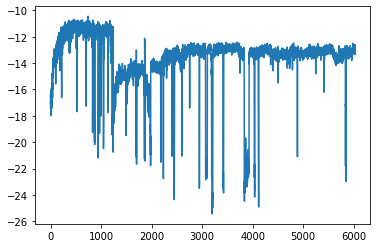

In [6]:
plt.plot(reward_records_)

In [7]:
import misc

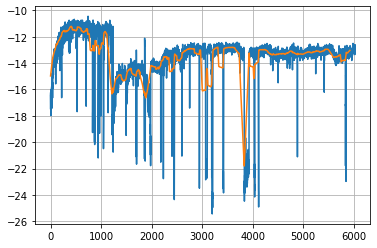

In [8]:
plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()


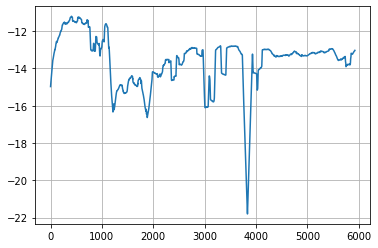

In [9]:
# plt.plot(reward_records_)
plt.plot(misc.smooth(reward_records_,100))
plt.grid()

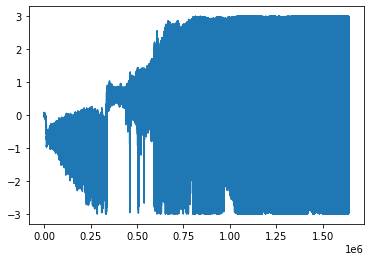

In [10]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,0])

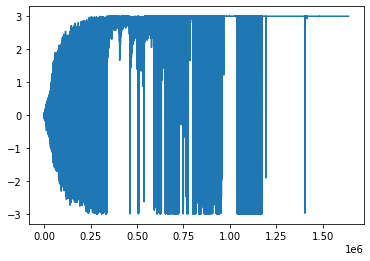

In [11]:
plt.plot(np.array(action_statmean_records).reshape([-1,8])[:,1])

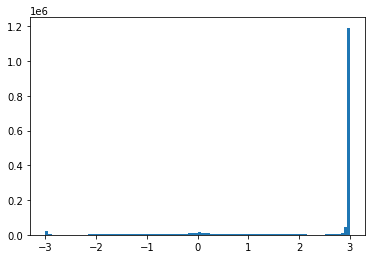

In [12]:
_=plt.hist(np.array(action_statmean_records).reshape([-1,8])[:,1],bins=100)

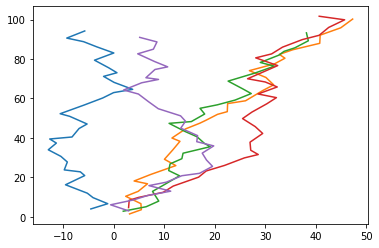

In [13]:
for these_actions in actions[:5]:
    plt.plot(np.cumsum(these_actions[:,0]),np.cumsum(these_actions[:,1]))

In [14]:
# actor_model.save('actor_model_vanilla_det_singleImg_Adv')

In [1]:
for these_actions in actions[:5]:
    plt.plot(np.cumsum(these_actions[:,0]),np.cumsum(these_actions[:,1]))

NameError: name 'actions' is not defined